In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import pickle
from Bio.Seq import Seq
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, to_hex
from matplotlib import collections  as mc
from scipy.special import expit
from scipy.stats import percentileofscore
import torch
from collections import defaultdict
from Bio.Seq import Seq
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# DMS data

Single mutant scores

In [2]:
dms_df = pd.read_csv("../results/final_variant_scores/final_variant_scores.csv", index_col="mutation", dtype=dict(position_IMTG=pd.Int16Dtype()))
# remove linker sites
dms_df = dms_df[dms_df.chain != "link"]
# add indicator for wildtype data
dms_df["WT"] = dms_df.wildtype == dms_df.mutant
assert dms_df.position_IMTG.max() < 1000
dms_df["site"] = [f"{chain}-{str(pos).zfill(3)}" for chain, pos in zip(dms_df.chain, dms_df.position_IMTG)]
dms_df

target wildtype  position  position_IMTG chain mutant codon  \
mutation                                                                   
E1(H)A    CGG_naive        E         1              1     H      A   GAG   
E1(H)C    CGG_naive        E         1              1     H      C   GAG   
E1(H)D    CGG_naive        E         1              1     H      D   GAG   
E1(H)E    CGG_naive        E         1              1     H      E   GAG   
E1(H)F    CGG_naive        E         1              1     H      F   GAG   
...             ...      ...       ...            ...   ...    ...   ...   
R124(L)S  CGG_naive        R       235            124     L      S   CGT   
R124(L)T  CGG_naive        R       235            124     L      T   CGT   
R124(L)V  CGG_naive        R       235            124     L      V   CGT   
R124(L)W  CGG_naive        R       235            124     L      W   CGT   
R124(L)Y  CGG_naive        R       235            124     L      Y   CGT   

         single_nt      bind  delta_bind  ...      expr  delta_expr  \
mutation                                  ...                         
E1(H)A        True  10.48829     0.03110  ...  10.44614    -0.00453   
E1(H)C       False  10.44477    -0.01243  ...  10.32364    -0.12703   
E1(H)D        True  10.42771    -0.02948  ...  10.51618     0.06551   
E1(H)E        True  10.45719     0.00000  ...  10.45067     0.00000   
E1(H)F       False  10.51899     0.06180  ...  10.33163    -0.11904   
...            ...       ...         ...  ...       ...         ...   
R124(L)S      True  10.44756    -0.00963  ...  10.54313     0.09246   
R124(L)T     False  10.43023    -0.02696  ...  10.53860     0.08793   
R124(L)V     False  10.38231    -0.07488  ...  10.48707     0.03640   
R124(L)W     False  10.48219     0.02500  ...  10.38698    -0.06369   
R124(L)Y     False  10.47297     0.01577  ...  10.48454     0.03387   

          n_bc_expr  n_libs_expr      psr  delta_psr  n_bc_psr  n_libs_psr  \
mutation                                                                     
E1(H)A         19.0          2.0  6.78608   -0.07452      17.0         2.0   
E1(H)C         20.0          2.0  7.44234    0.58174      17.0         2.0   
E1(H)D         16.0          2.0  6.95940    0.09880      13.0         2.0   
E1(H)E      21170.0          2.0  6.86060    0.00000   18910.0         2.0   
E1(H)F         24.0          2.0  6.91372    0.05313      21.0         2.0   
...             ...          ...      ...        ...       ...         ...   
R124(L)S       39.0          2.0  6.93925    0.07866      33.0         2.0   
R124(L)T       36.0          2.0  6.88956    0.02896      34.0         2.0   
R124(L)V       27.0          2.0  6.78160   -0.07899      24.0         2.0   
R124(L)W       33.0          2.0  6.91474    0.05415      29.0         2.0   
R124(L)Y       34.0          2.0  6.96378    0.10318      32.0         2.0   

             WT   site  
mutation                
E1(H)A    False  H-001  
E1(H)C    False  H-001  
E1(H)D    False  H-001  
E1(H)E     True  H-001  
E1(H)F    False  H-001  
...         ...    ...  
R124(L)S  False  L-124  
R124(L)T  False  L-124  
R124(L)V  False  L-124  
R124(L)W  False  L-124  
R124(L)Y  False  L-124  

[4400 rows x 22 columns]

## Position maps for scFv

In [3]:
pos_df = pd.read_csv("../data/CGGnaive_sites.csv", dtype=dict(site=pd.Int16Dtype()), index_col="site_scFv")
pos_df

amino_acid chain  site KI_codon
site_scFv                                
1                  E     H     1      GAG
2                  V     H     2      GTG
3                  Q     H     3      CAG
4                  L     H     4      CTT
5                  Q     H     5      CAG
...              ...   ...   ...      ...
231                L     L   120      CTA
232                E     L   121      GAA
233                I     L   122      ATA
234                K     L   123      AAA
235                R     L   124      CGT

[235 rows x 4 columns]

### Add CDR/FWR annotations from IMGT VQUEST

In [5]:
pos_df.loc[(pos_df.chain == "H") & (pos_df.site <= 26), "region"] = "FR1"
pos_df.loc[(pos_df.chain == "H") & (27 <= pos_df.site) & (pos_df.site <= 38), "region"] = "CDR1"
pos_df.loc[(pos_df.chain == "H") & (39 <= pos_df.site) & (pos_df.site <= 55), "region"] = "FR2"
pos_df.loc[(pos_df.chain == "H") & (56 <= pos_df.site) & (pos_df.site <= 65), "region"] = "CDR2"
pos_df.loc[(pos_df.chain == "H") & (66 <= pos_df.site) & (pos_df.site <= 104), "region"] = "FR3"
pos_df.loc[(pos_df.chain == "H") & (105 <= pos_df.site) & (pos_df.site <= 110), "region"] = "CDR3"
pos_df.loc[(pos_df.chain == "H") & (111 <= pos_df.site), "region"] = "FR4"

pos_df.loc[(pos_df.chain == "L") & (pos_df.site <= 26), "region"] = "FR1"
pos_df.loc[(pos_df.chain == "L") & (27 <= pos_df.site) & (pos_df.site <= 38), "region"] = "CDR1"
pos_df.loc[(pos_df.chain == "L") & (39 <= pos_df.site) & (pos_df.site <= 55), "region"] = "FR2"
pos_df.loc[(pos_df.chain == "L") & (56 <= pos_df.site) & (pos_df.site <= 65), "region"] = "CDR2"
pos_df.loc[(pos_df.chain == "L") & (66 <= pos_df.site) & (pos_df.site <= 104), "region"] = "FR3"
pos_df.loc[(pos_df.chain == "L") & (105 <= pos_df.site) & (pos_df.site <= 113), "region"] = "CDR3"
pos_df.loc[(pos_df.chain == "L") & (114 <= pos_df.site) & (pos_df.site <= 123), "region"] = "FR4"

pos_df.to_csv("output/CGGnaive_sites_annotated.csv")
pos_df

amino_acid chain  site KI_codon region
site_scFv                                       
1                  E     H     1      GAG    FR1
2                  V     H     2      GTG    FR1
3                  Q     H     3      CAG    FR1
4                  L     H     4      CTT    FR1
5                  Q     H     5      CAG    FR1
...              ...   ...   ...      ...    ...
231                L     L   120      CTA    FR4
232                E     L   121      GAA    FR4
233                I     L   122      ATA    FR4
234                K     L   123      AAA    FR4
235                R     L   124      CGT    NaN

[235 rows x 5 columns]

In [6]:
igh_pos_map = pos_df.loc[pos_df.chain == "H", "site"].reset_index(drop=True)
igk_pos_map = pos_df.loc[pos_df.chain == "L", "site"].reset_index(drop=True)

## Heatmaps indicating inaccessible first-step mutations

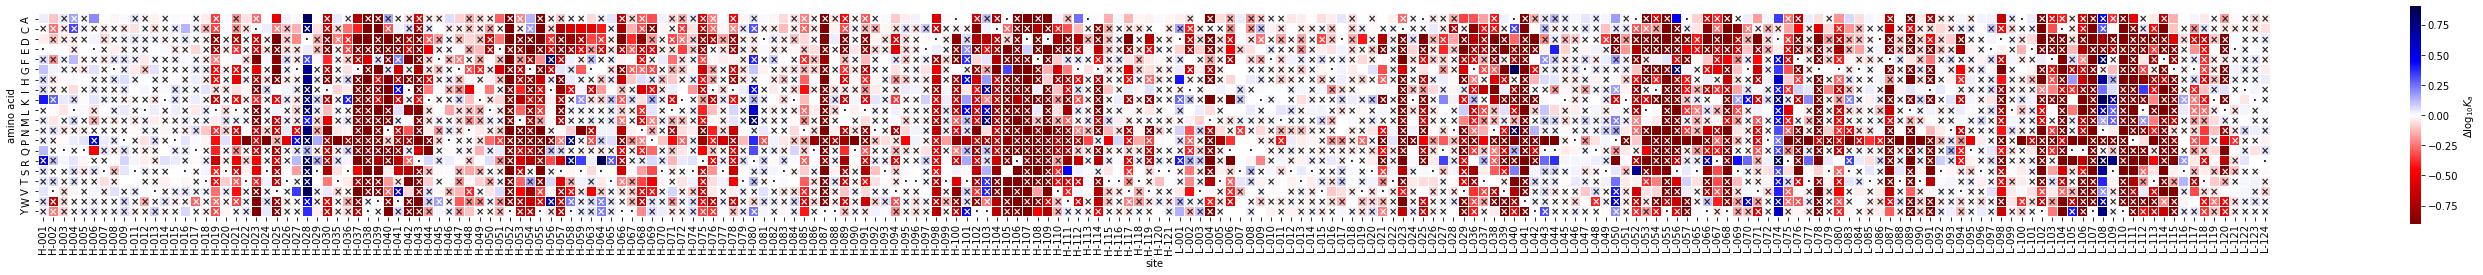

In [7]:
bind_df = dms_df.pivot(index="mutant", columns="site", values="delta_bind")

accessible_df = dms_df.pivot(index="mutant", columns="site", values="single_nt")
wt_df = dms_df.pivot(index="mutant", columns="site", values="WT")

annot = pd.DataFrame(np.empty_like(bind_df, dtype=str), index=bind_df.index, columns=bind_df.columns)
annot.iloc[wt_df.values.astype(bool)] = "\u00B7"
annot.iloc[~accessible_df.values.astype(bool)] = "\u00D7"

vmax = dms_df.delta_bind.max()
vmin = -vmax

plt.figure(figsize=(50, 4))
sns.heatmap(bind_df, center=0, vmin=vmin, vmax=vmax, annot=annot, fmt="", annot_kws=dict(fontweight="bold"),
            cmap="seismic_r", cbar_kws=dict(label=r"$\Delta\log_{10} K_a$"), linewidths=.1, square=True)
plt.xlabel("site")
plt.ylabel("amino acid")
plt.savefig("output/plots/bind_heatmap.pdf")
plt.show()

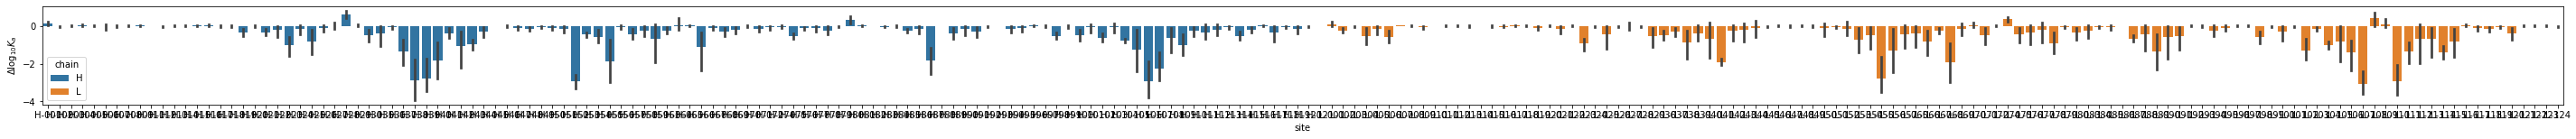

In [8]:
plt.figure(figsize=(50, 2))
sns.barplot(data=dms_df[(~dms_df.WT) & dms_df.single_nt], x="site", y="delta_bind", hue="chain", dodge=False)
plt.ylabel(r"$\Delta\log_{10} K_a$")
plt.savefig("output/plots/bind_boxplot.pdf")
plt.show()

In [9]:
pa = ProteinAnalysis("".join(pos_df.amino_acid))

gravy_naive = pa.gravy()
charge_naive = pa.charge_at_pH(7.4)

for row_idx, row in dms_df.iterrows():
    aa_seq = pos_df.amino_acid.copy()
    assert aa_seq.loc[row.position] == row.wildtype
    aa_seq.loc[row.position] = row.mutant
    pa = ProteinAnalysis("".join(aa_seq))
    dms_df.loc[row_idx, "delta_gravy"] = pa.gravy() - gravy_naive
    dms_df.loc[row_idx, "delta_charge"] = pa.charge_at_pH(7.4) - charge_naive
    region = pos_df.region[(pos_df.chain == dms_df.loc[row_idx, "chain"]) & (pos_df.site == dms_df.loc[row_idx, "position_IMTG"])]
    assert len(region) == 1
    dms_df.loc[row_idx, "region"] = region.values[0]
dms_df["region type"] = dms_df.region.str[:-1]

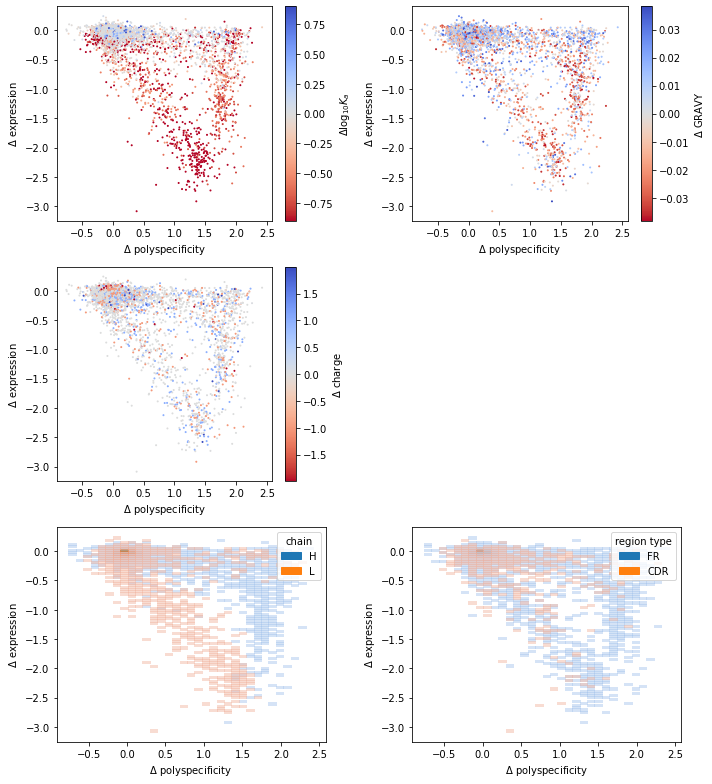

In [10]:
plt.figure(figsize=(10, 11))

plt.subplot(3, 2, 1)
order = np.argsort(dms_df.delta_bind)
plt.scatter(dms_df.delta_psr.iloc[order], dms_df.delta_expr.iloc[order], c=dms_df.delta_bind.iloc[order], s=1, cmap="coolwarm_r", vmin=vmin, vmax=vmax)
plt.xlabel(r"$\Delta$ polyspecificity")
plt.ylabel(r"$\Delta$ expression")
plt.colorbar(label=r"$\Delta\log_{10}K_a$")

plt.subplot(3, 2, 2)
plt.scatter(dms_df.delta_psr, dms_df.delta_expr, c=dms_df.delta_gravy, s=1, cmap="coolwarm_r")#, vmin=-0.04, vmax=0.04)
plt.xlabel(r"$\Delta$ polyspecificity")
plt.ylabel(r"$\Delta$ expression")
plt.colorbar(label=r"$\Delta$ GRAVY")

plt.subplot(3, 2, 3)
plt.scatter(dms_df.delta_psr, dms_df.delta_expr, c=dms_df.delta_charge, s=1, cmap="coolwarm_r")#, vmin=-2, vmax=2)
plt.xlabel(r"$\Delta$ polyspecificity")
plt.ylabel(r"$\Delta$ expression")
plt.colorbar(label=r"$\Delta$ charge")

plt.subplot(3, 2, 5)
sns.histplot(data=dms_df, x="delta_psr", y="delta_expr", hue="chain", alpha=0.5)
plt.xlabel(r"$\Delta$ polyspecificity")
plt.ylabel(r"$\Delta$ expression")

plt.subplot(3, 2, 6)
sns.histplot(data=dms_df, x="delta_psr", y="delta_expr", hue="region type", alpha=0.5)
plt.xlabel(r"$\Delta$ polyspecificity")
plt.ylabel(r"$\Delta$ expression")


plt.tight_layout()
plt.savefig("output/plots/3Dscatter.pdf")
plt.show()

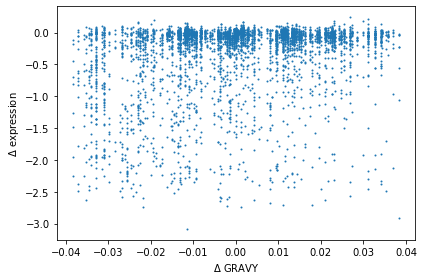

In [11]:
plt.scatter(dms_df.delta_gravy, dms_df.delta_expr, s=1, cmap="coolwarm_r")#, vmin=-2, vmax=2)
plt.xlabel(r"$\Delta$ GRAVY")
plt.ylabel(r"$\Delta$ expression")
plt.tight_layout()
plt.show()

# Replay tree data

In [12]:
trees = {f.split("/")[2]: pickle.load(open(f, "rb")) for f in glob.glob("data/*/*/gctree.out.inference.1.p")}

In [13]:
igh_frame = 1
igk_frame = 1
igk_idx = 336

In [14]:
def local_branching(tree, τ=1, τ0=0.1):
    r"""Add local branching statistics (Neher et al. 2014) as tree node
    features to the ETE tree attribute of a ``gctree.CollapsedTree`` object.
    
    Args:
        τ: decay timescale
        τ0: effective branch length for branches with zero mutations
    """
    # the fixed integral contribution for clonal cells indicated by abundance annotations
    clone_contribution = τ * (1 - np.exp(-τ0 / τ))

    # post-order traversal to populate downward integral for each node
    for node in tree.tree.traverse(strategy="postorder"):
        if node.is_leaf():
            node.add_feature("LB_down", node.abundance * clone_contribution
                                        if node.abundance > 1 else 0
                            )
        else:
            node.add_feature("LB_down",
                             node.abundance * clone_contribution
                             + sum(τ * (1 - np.exp(-child.dist / τ))
                                   + np.exp(-child.dist / τ) * child.LB_down
                                   for child in node.children)
                            )

    # pre-order traversal to populate upward integral for each node
    for node in tree.tree.traverse(strategy="preorder"):
        if node.is_root():
            node.add_feature("LB_up", 0)
        else:
            node.add_feature("LB_up",
                             τ * (1 - np.exp(-node.dist / τ))
                             + np.exp(-node.dist / τ) * (node.up.LB_up + node.up.LB_down)
                            )

    # finally, compute LBI (LBR) as the sum (ratio) of upward and downward integrals at each node
    for node in tree.tree.traverse():
        node.add_feature("LBI", node.LB_down + node.LB_up)
        node.add_feature("LBR", node.LB_down / node.LB_up if not node.is_root() else np.nan)

In [15]:
def aa(seq, frame):
    return Seq(seq[(frame - 1) : (frame - 1 + (3 * ((len(seq) - (frame - 1)) // 3)))]).translate()

def mutations(naive_aa, aa, pos_map, chain_annotation):
    return [f"{aa1}{pos_map[pos]}{chain_annotation}{aa2}"
            for pos, (aa1, aa2) in enumerate(zip(naive_aa, aa))
            if aa1 != aa2]

def tree_nt_seq_to_dms_aa_seq(sequence):

    igh_aa = aa(sequence[:igk_idx], igh_frame)
    igk_aa = aa(sequence[igk_idx:], igk_frame)

    aa_dms = pos_df.amino_acid.copy()
    aa_dms.iloc[pos_df.chain == "H"] = igh_aa
    # note: replay light chains are shorter than dms seq by one aa
    aa_dms.iloc[(pos_df.chain == "L") & (pos_df.index < pos_df.index[-1])] = igk_aa
    
    return "".join(aa_dms)

In [16]:
tdms_model = torch.load("data/mse.model")
tdms_model.eval()

FullyConnected(
  (latent_layer): Linear(in_features=4935, out_features=2, bias=False)
  (nonlinearity_1): Linear(in_features=2, out_features=5, bias=True)
  (output_layer): Linear(in_features=5, out_features=2, bias=True)
)

In [17]:
# Using this as a hack for now to deal with tdms bias problem
tdms_prediction_naive = tdms_model(tdms_model.seq_to_binary(tree_nt_seq_to_dms_aa_seq(trees["gc31HK"].tree.sequence))).detach()
tdms_prediction_naive

tensor([-0.1611,  0.2952])

In [18]:
# trees_df = pd.DataFrame()

for gc, tree in trees.items():
    
    # rename tuple names with last element of tuple (possible danger)
    if isinstance(tree.tree.name, tuple):
        tree.tree.name = tree.tree.name[-1]
    
    local_branching(tree)

    naive_igh_aa = aa(tree.tree.sequence[:igk_idx], igh_frame)
    naive_igk_aa = aa(tree.tree.sequence[igk_idx:], igk_frame)

    for node in tree.tree.traverse():

        igh_aa = aa(node.sequence[:igk_idx], igh_frame)
        igk_aa = aa(node.sequence[igk_idx:], igk_frame)
        igh_mutations = mutations(naive_igh_aa, igh_aa, igh_pos_map, "(H)")
        igk_mutations = mutations(naive_igk_aa, igk_aa, igk_pos_map, "(L)")        
        all_mutations = igh_mutations + igk_mutations
        if any("*" in x for x in all_mutations):
            delta_bind = None
            delta_expr = None
            delta_psr = None
        else:
            delta_bind = dms_df.delta_bind[all_mutations].sum()
            delta_expr = dms_df.delta_expr[all_mutations].sum()
            delta_psr = dms_df.delta_psr[all_mutations].sum()

        node.add_feature("delta_bind_additive", delta_bind)
        node.add_feature("delta_expr_additive", delta_expr)
        node.add_feature("delta_psr_additive", delta_psr)
            
        tdms_prediction = tdms_model(tdms_model.seq_to_binary(tree_nt_seq_to_dms_aa_seq(node.sequence))).detach() - tdms_prediction_naive
        
        node.add_feature("delta_bind_tdms", tdms_prediction[0].item())
        node.add_feature("delta_expr_tdms", tdms_prediction[1].item())

## Color map $\Delta\log_{10} K_a$ on trees

- Warm colors indicate $\Delta\log_{10} K_a < 0$
- Cool colors indicate $\Delta\log_{10} K_a > 0$

gc31HK


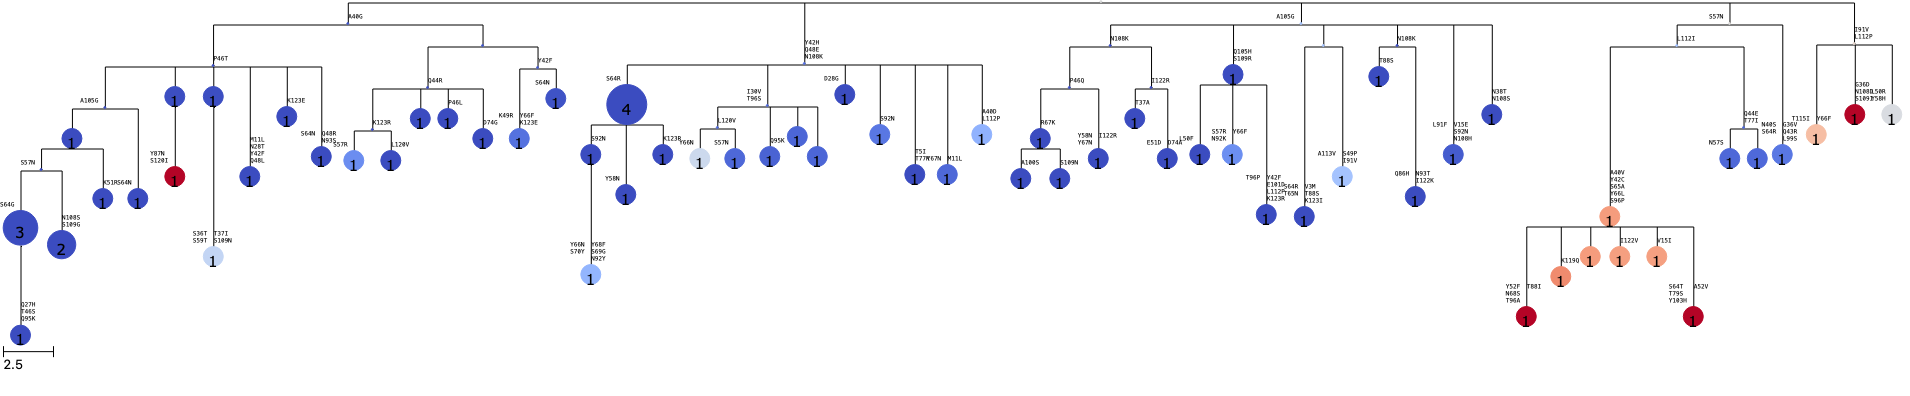

gc50HK


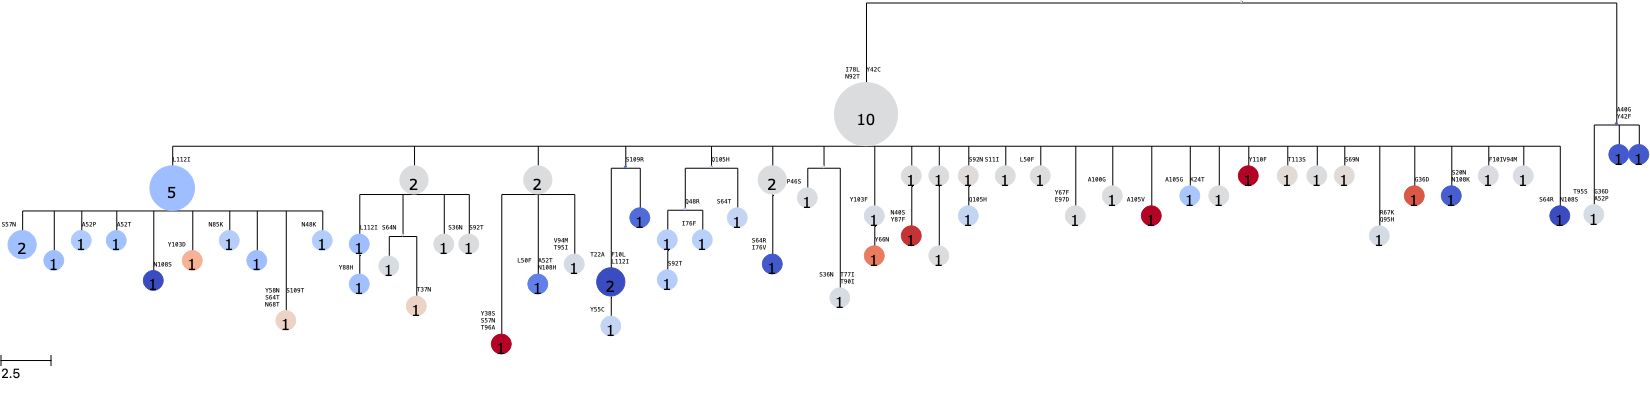

gc59HK


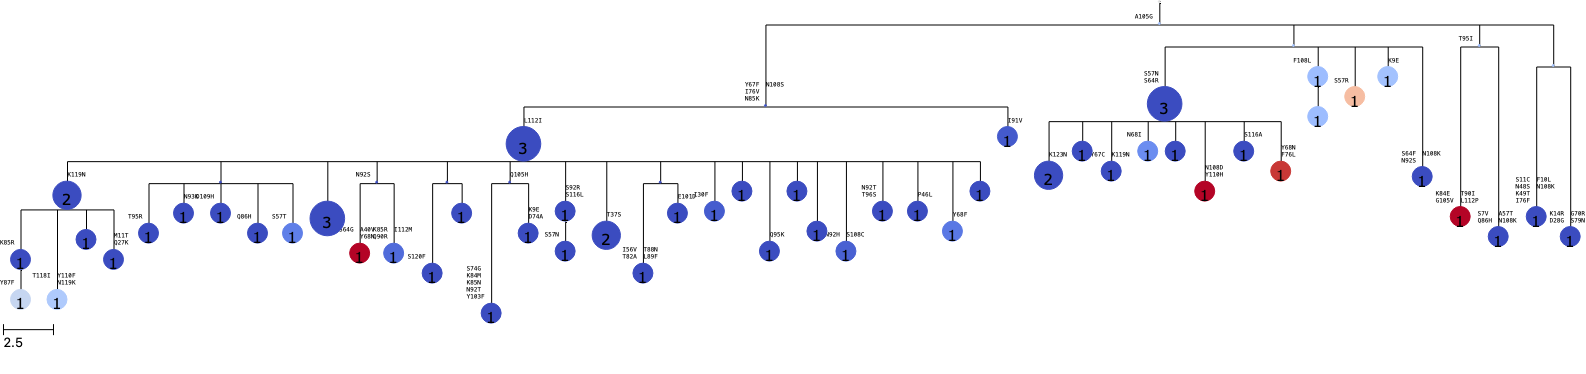

gc17HK


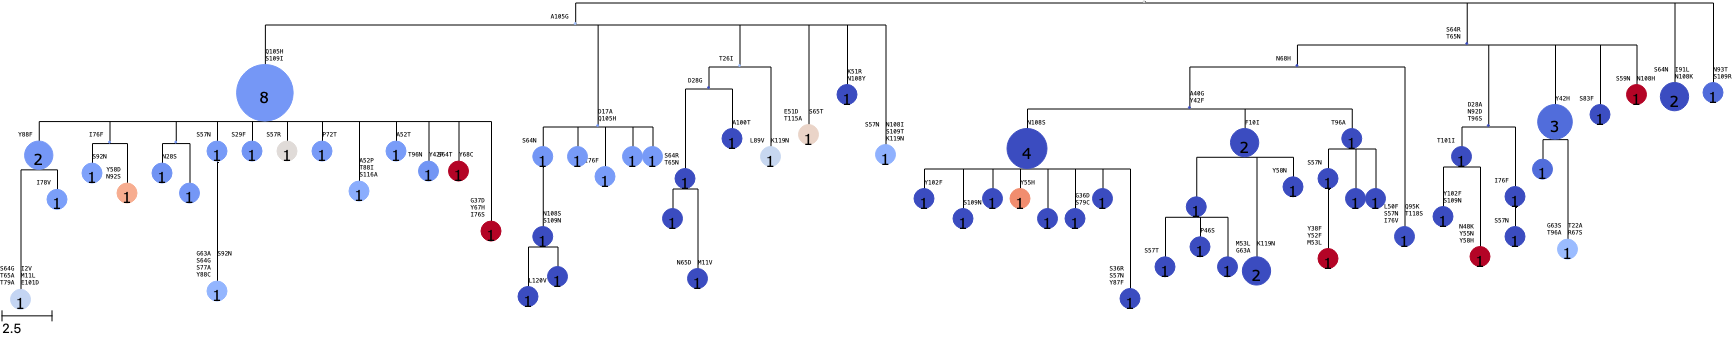

gc56HK


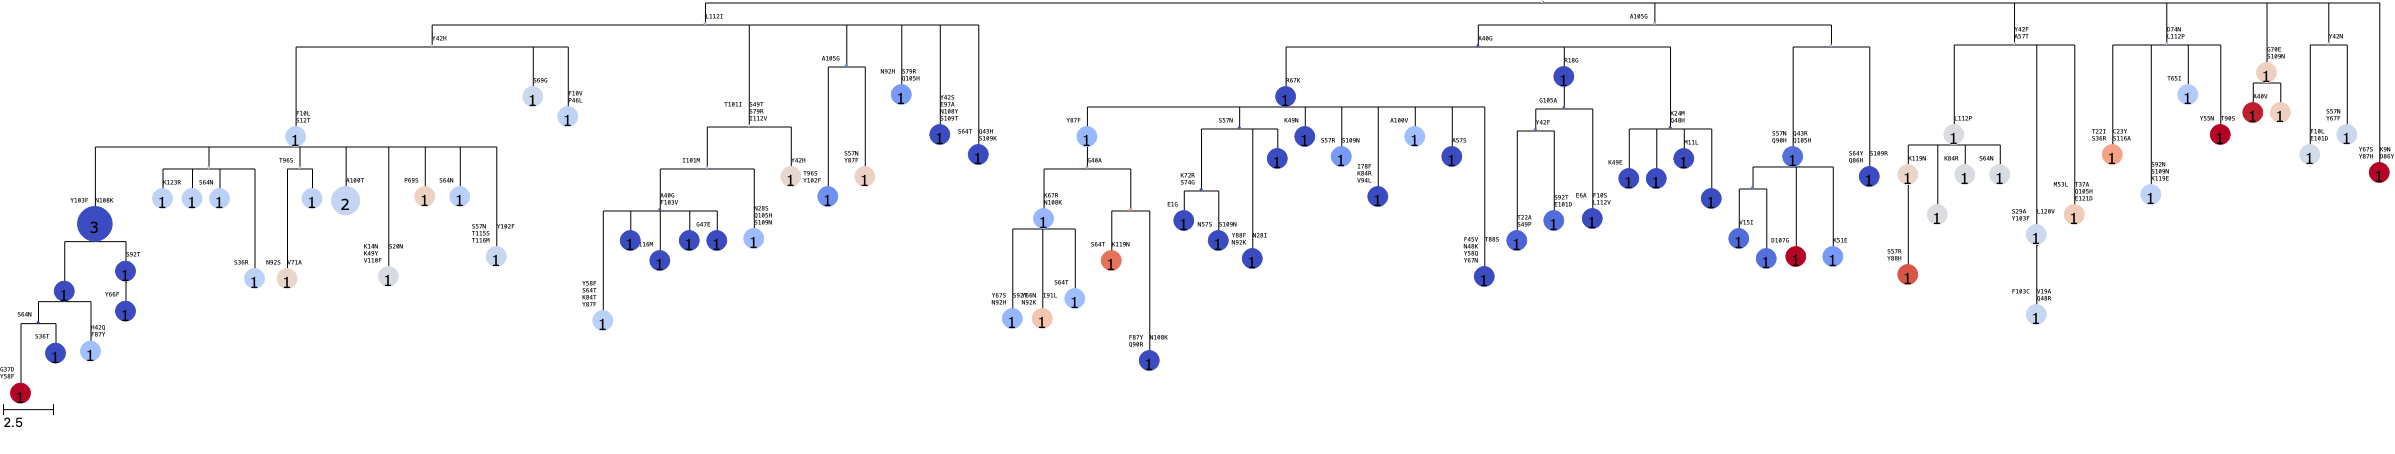

gc39HK


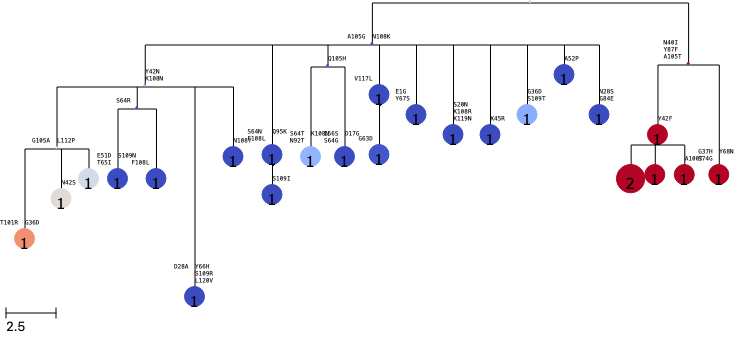

gc77HK


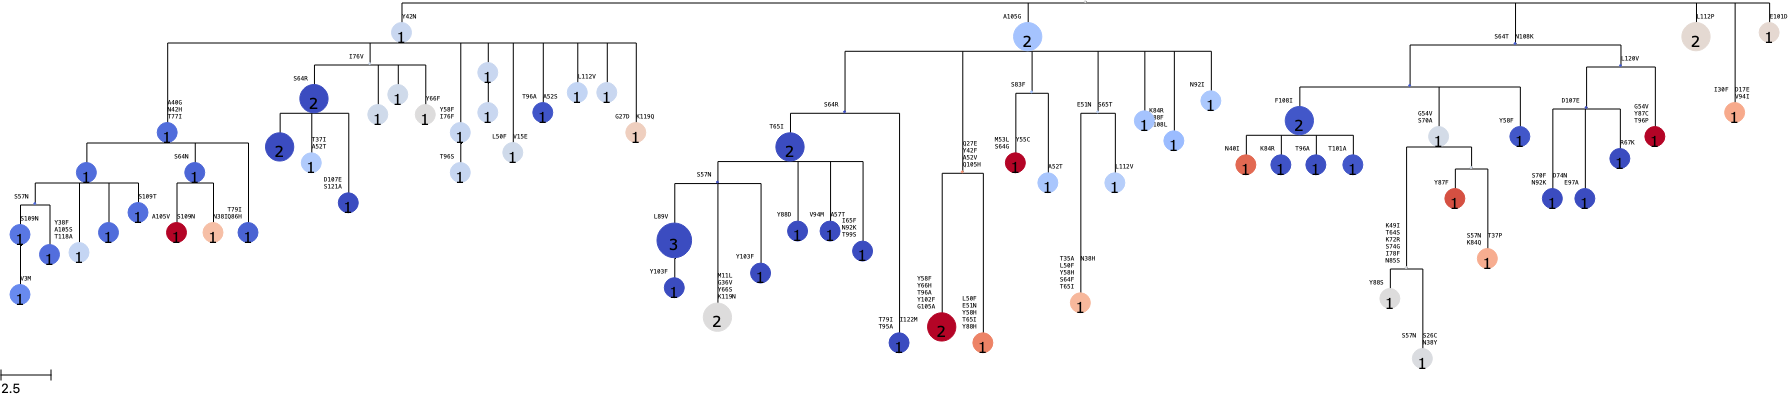

gc16HK


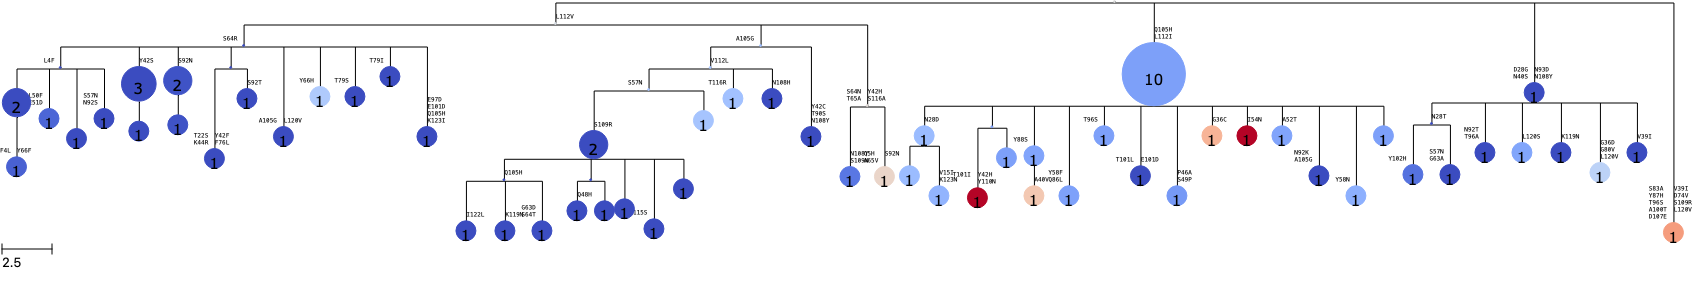

gc46HK


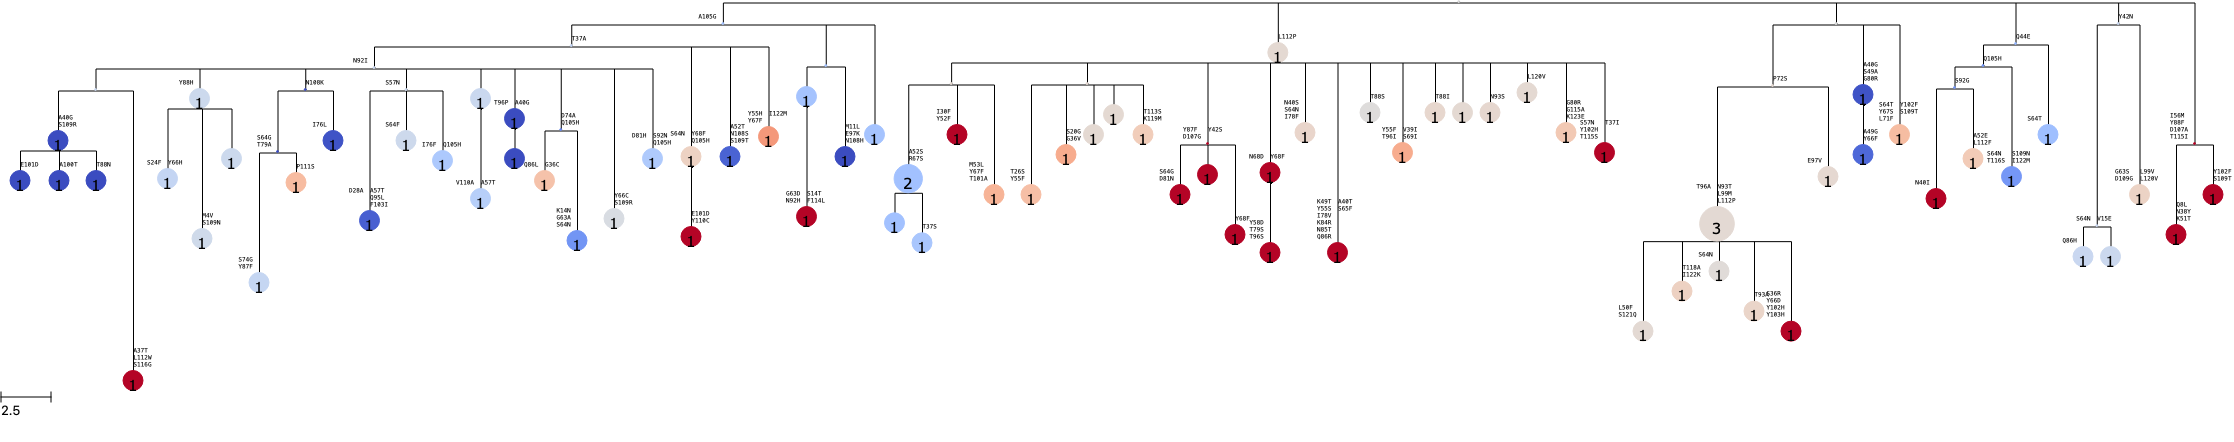

gc30HK


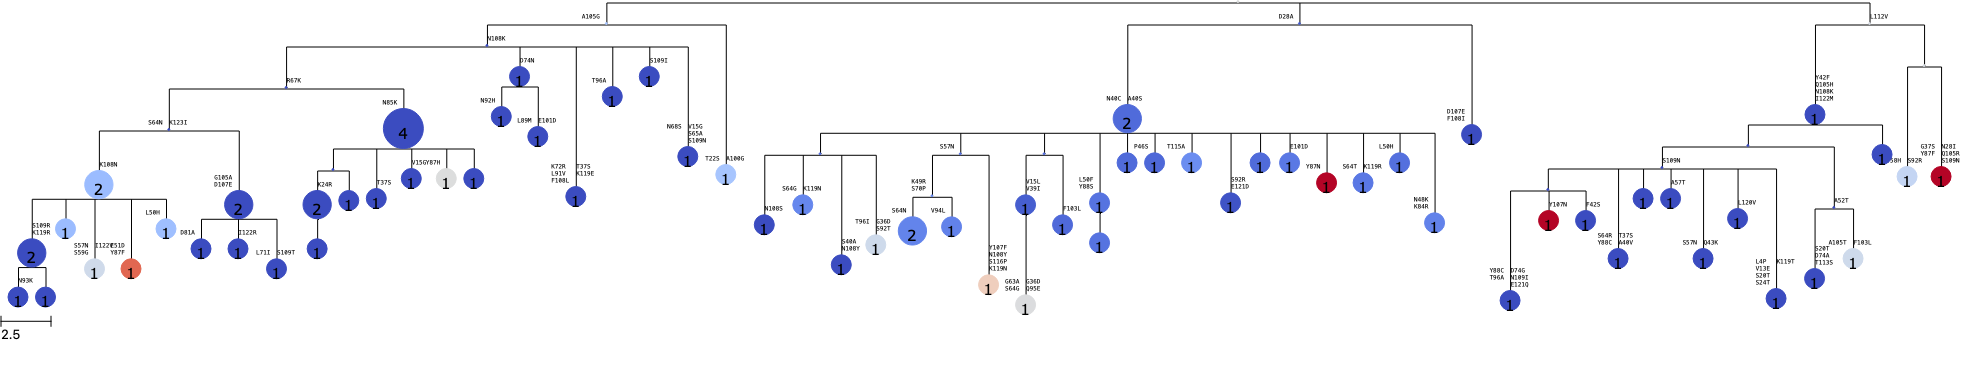

gc14HK


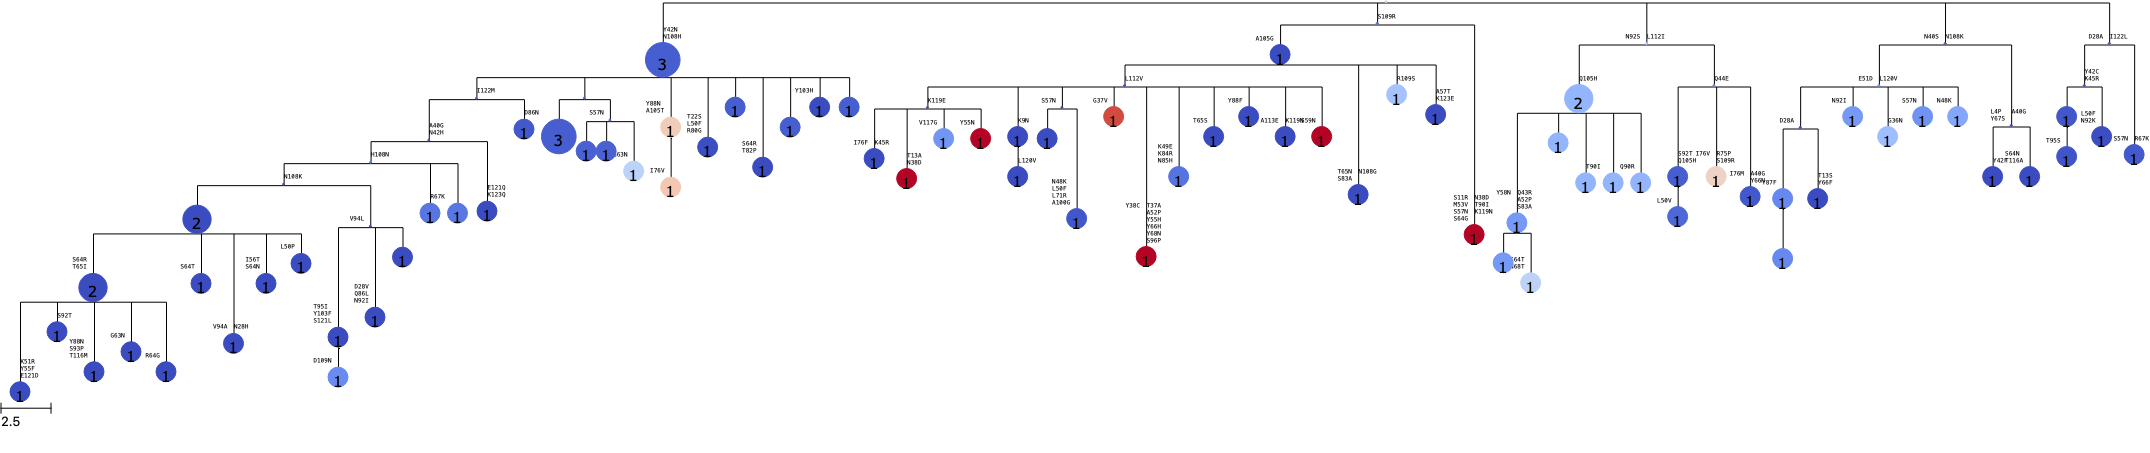

gc6HK


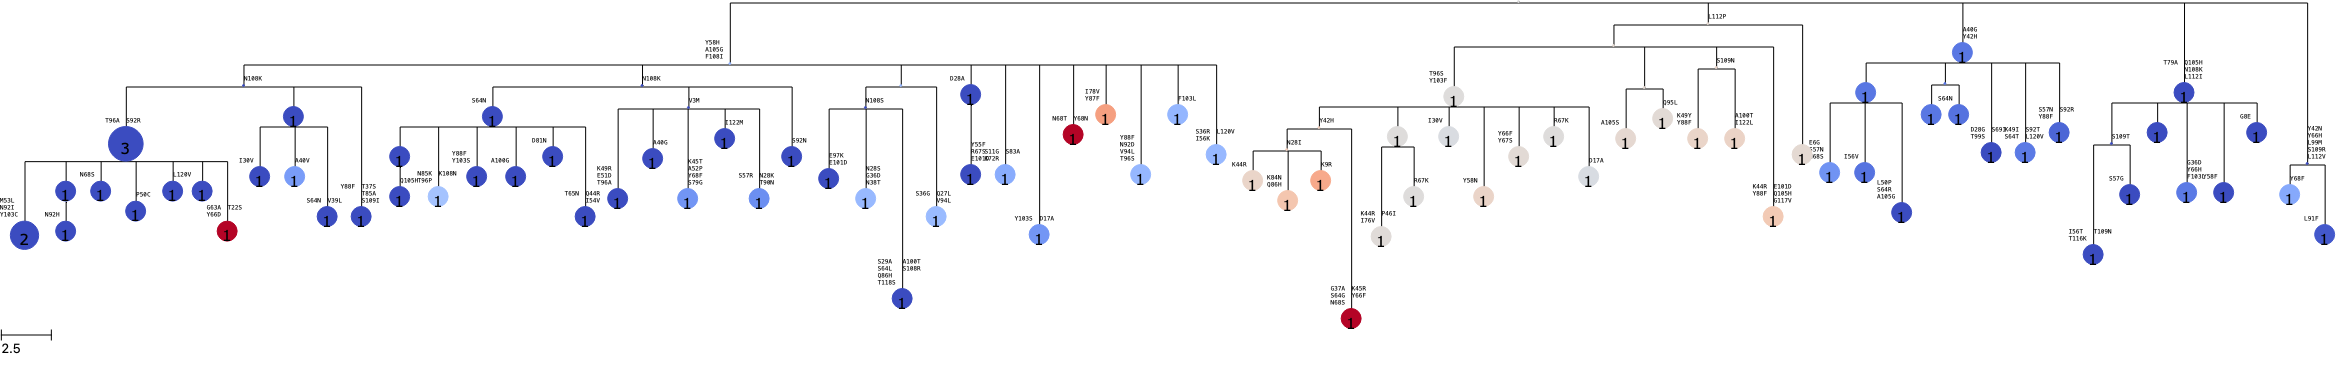

gc2HK


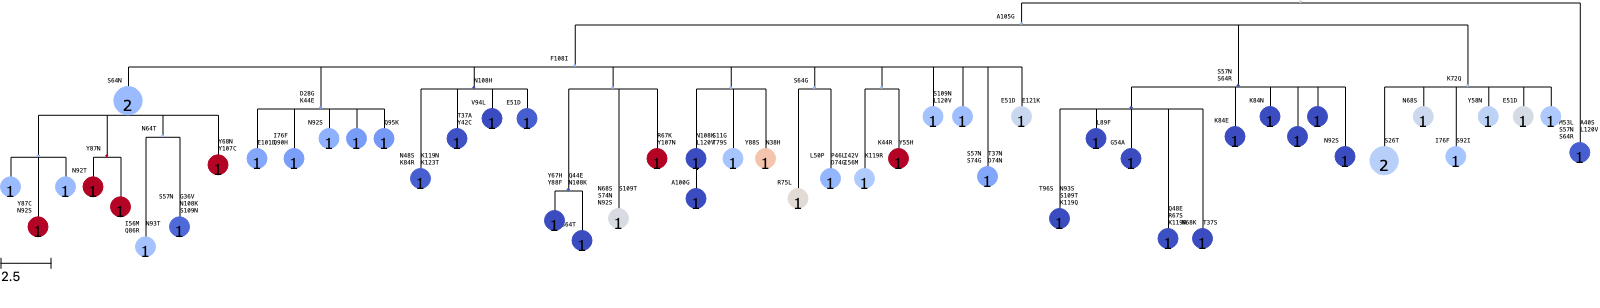

gc81HK


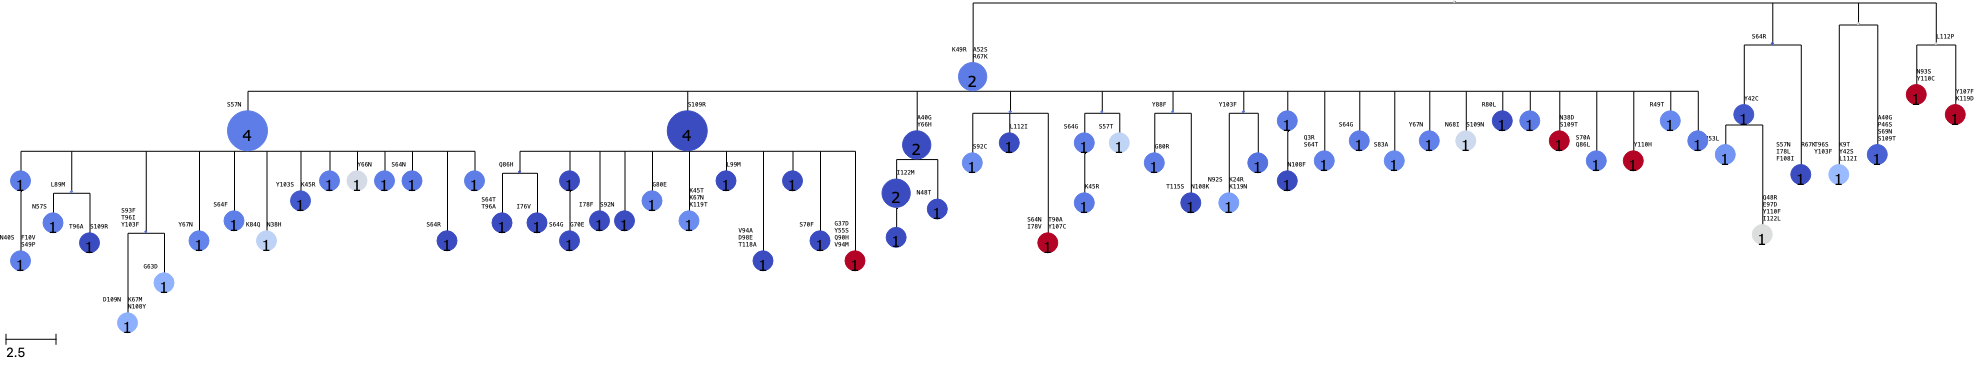

gc1HK


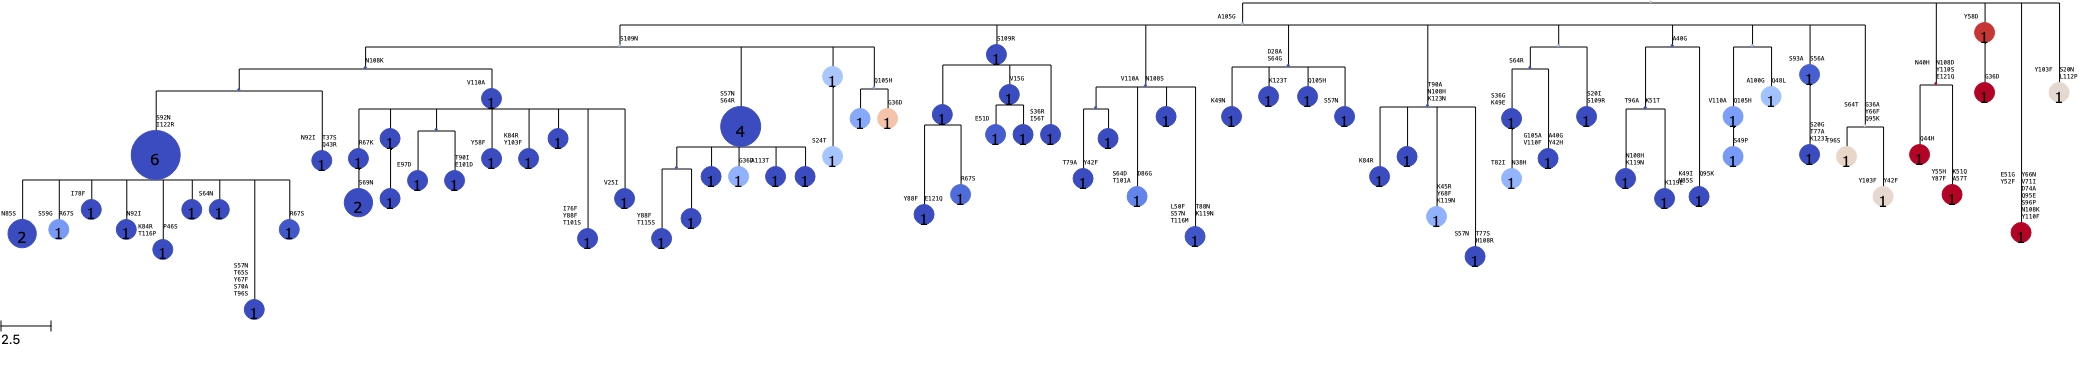

gc68HK


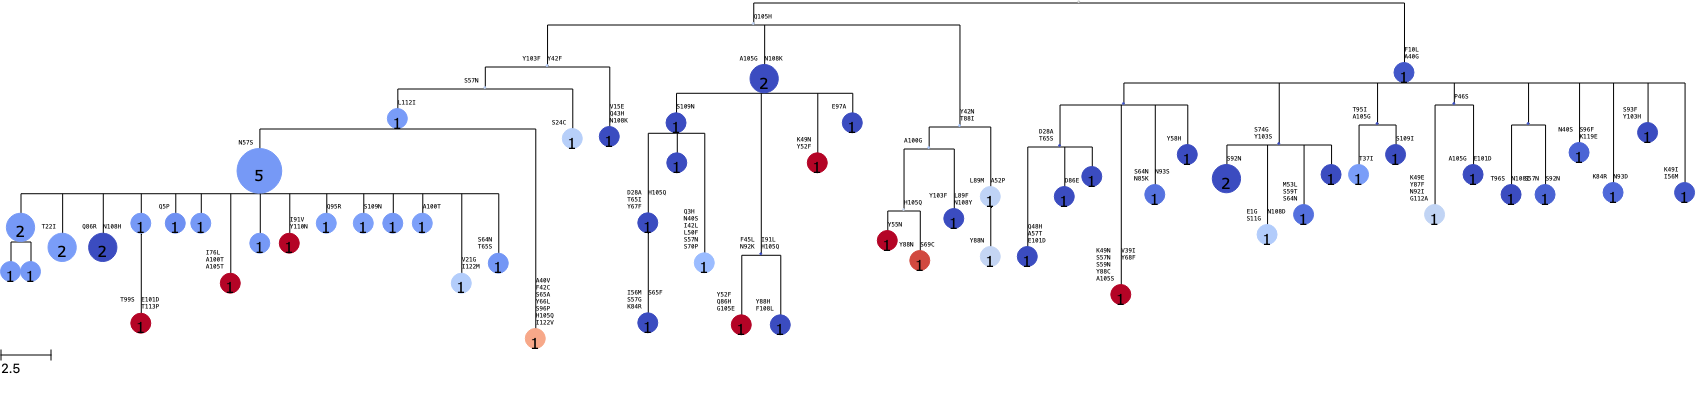

gc79HK


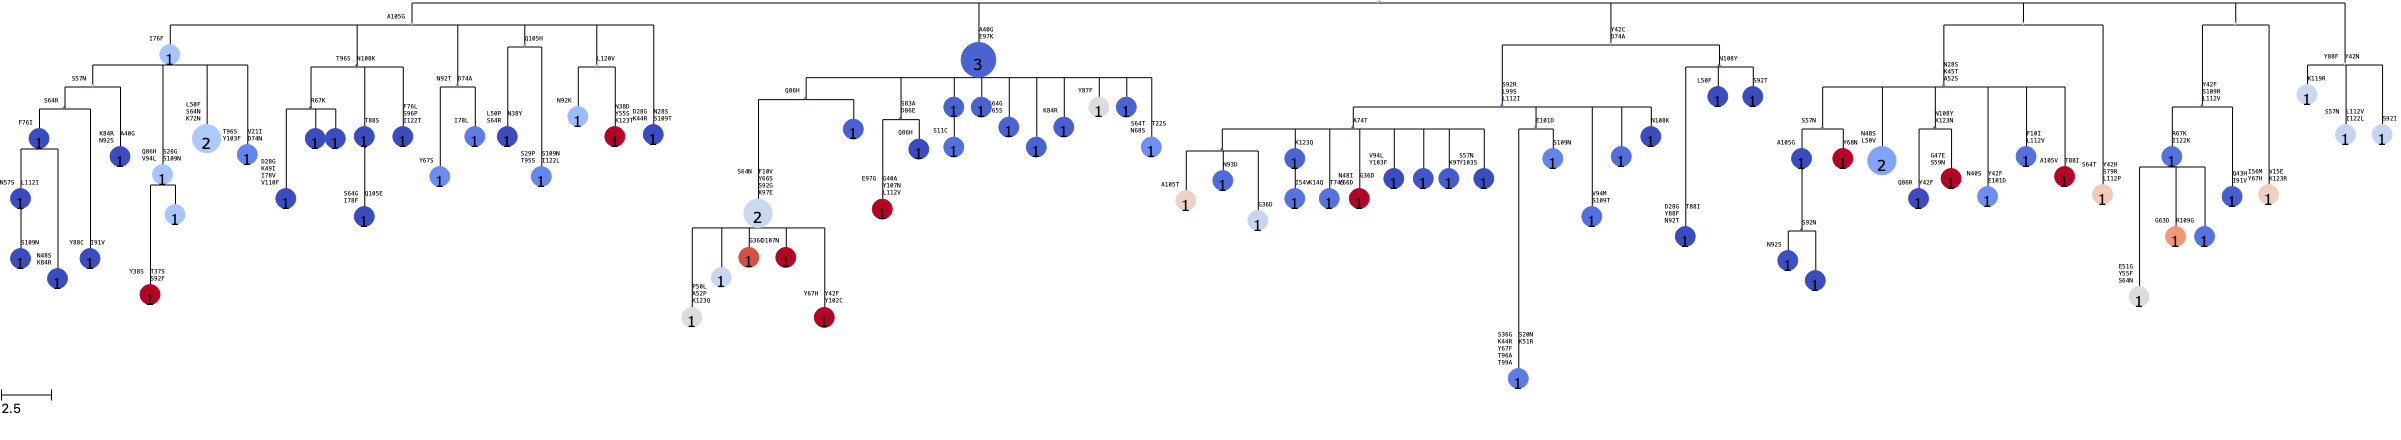

gc80HK


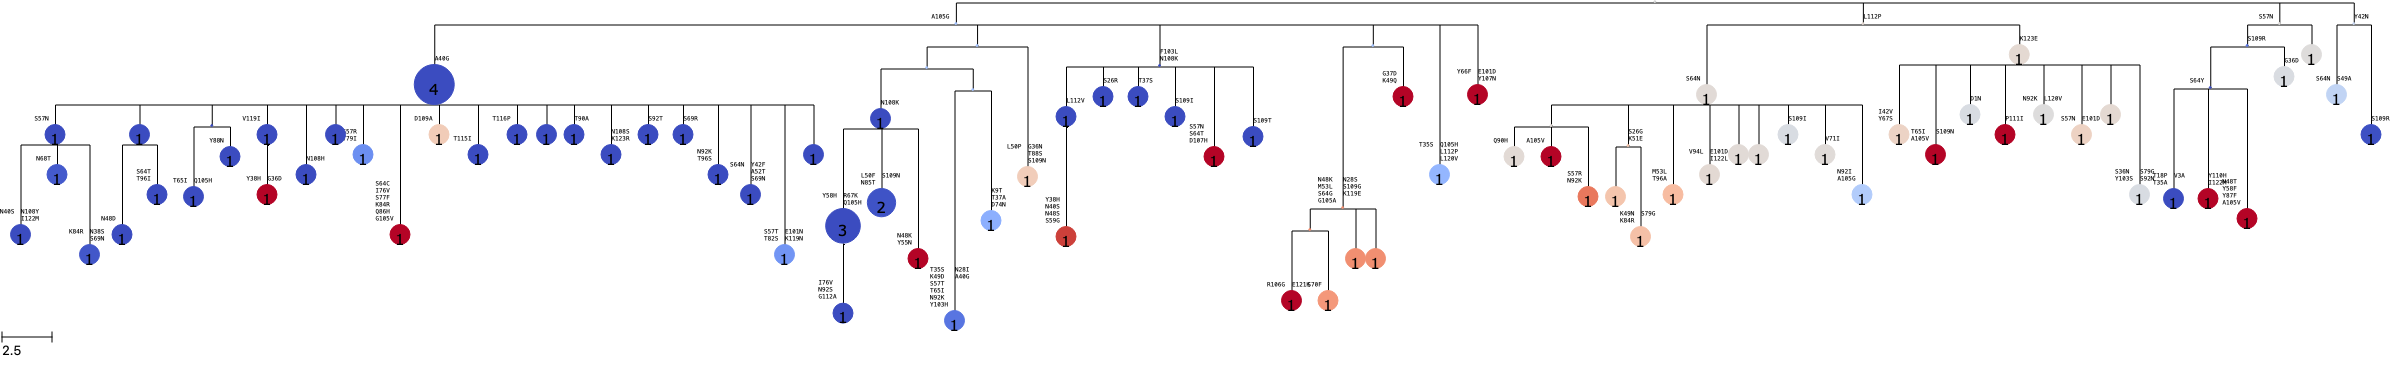

gc69HK


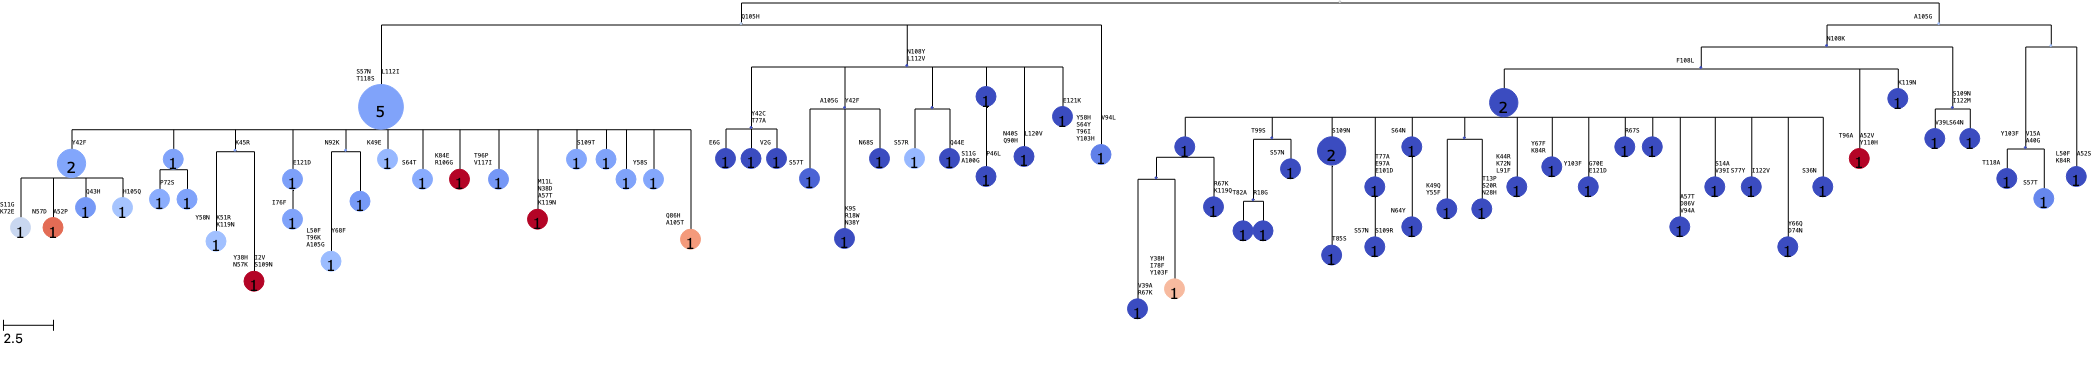

gc70HK


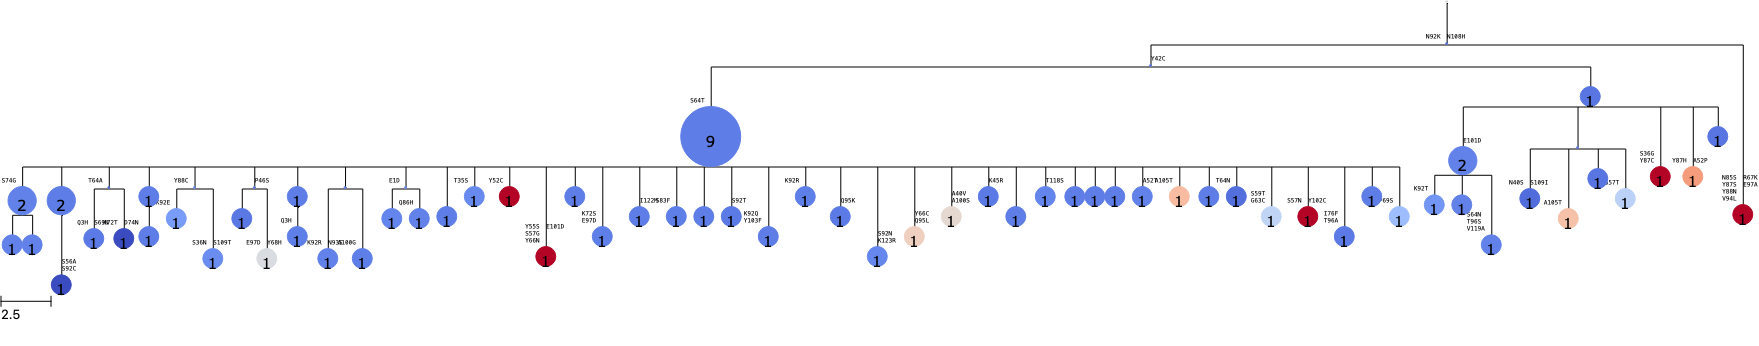

gc15HK


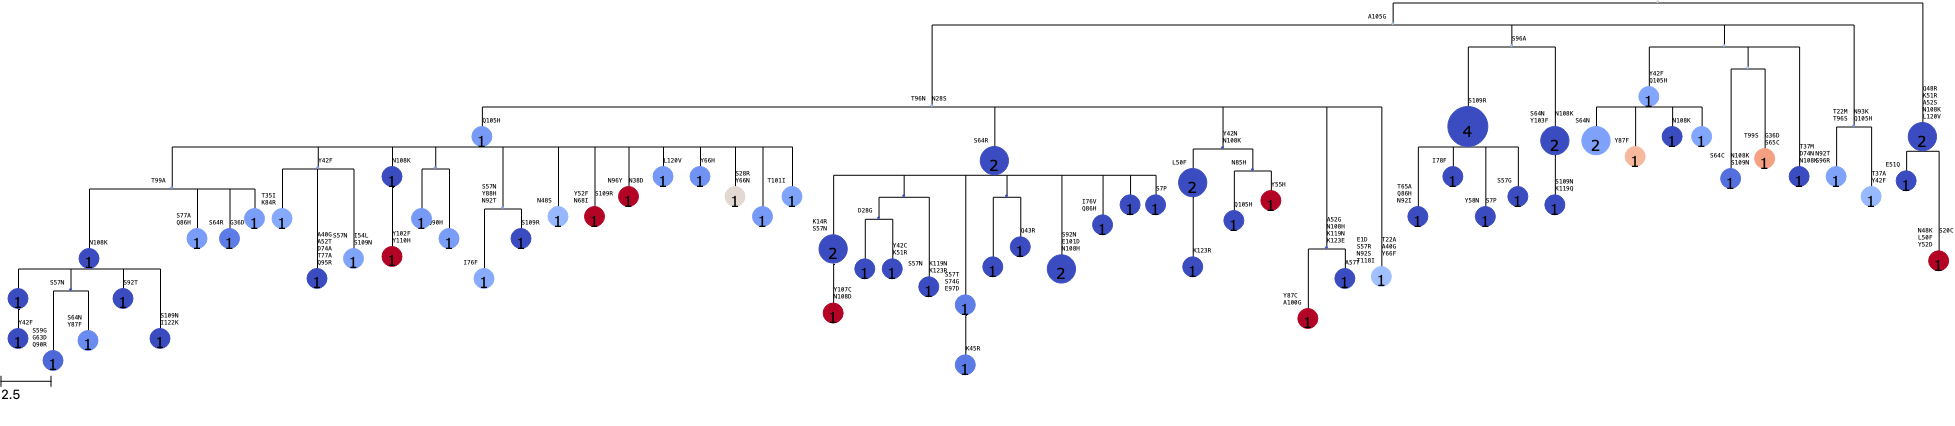

gc32HK


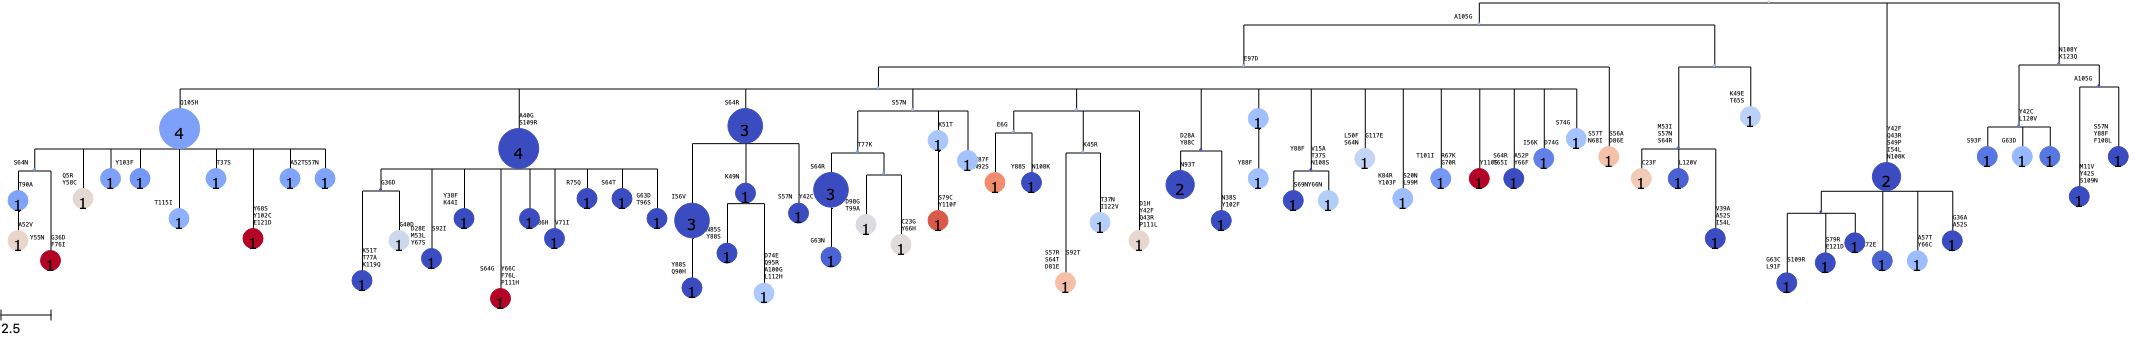

gc20HK-BC1


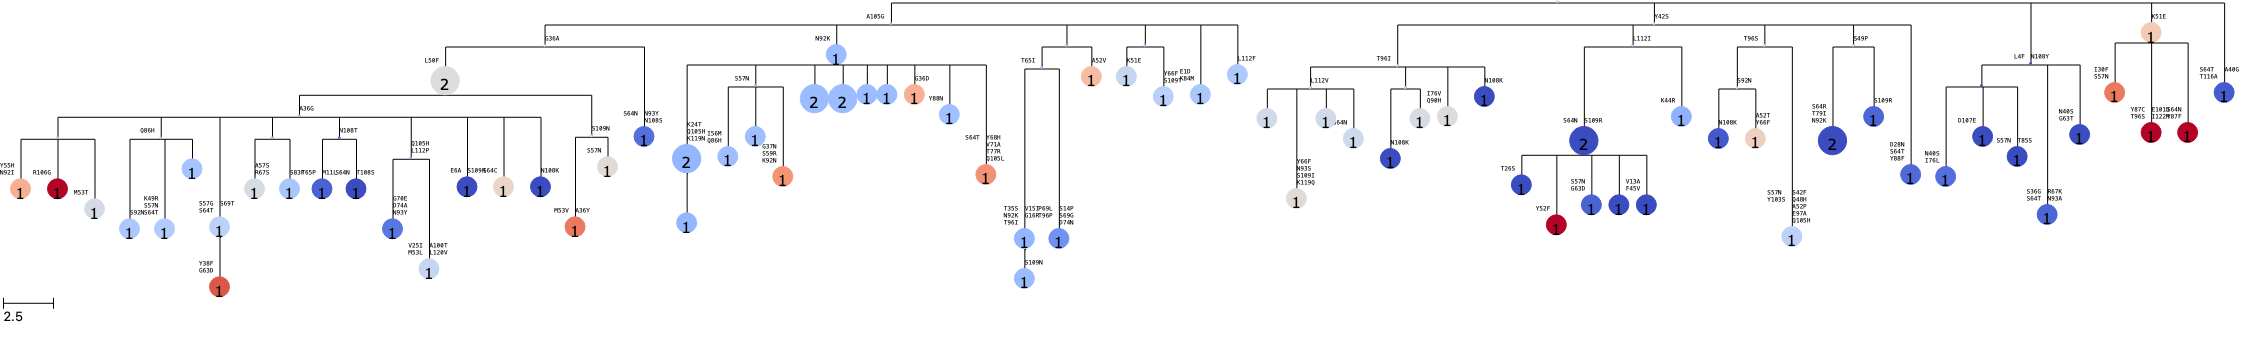

gc38HK-2


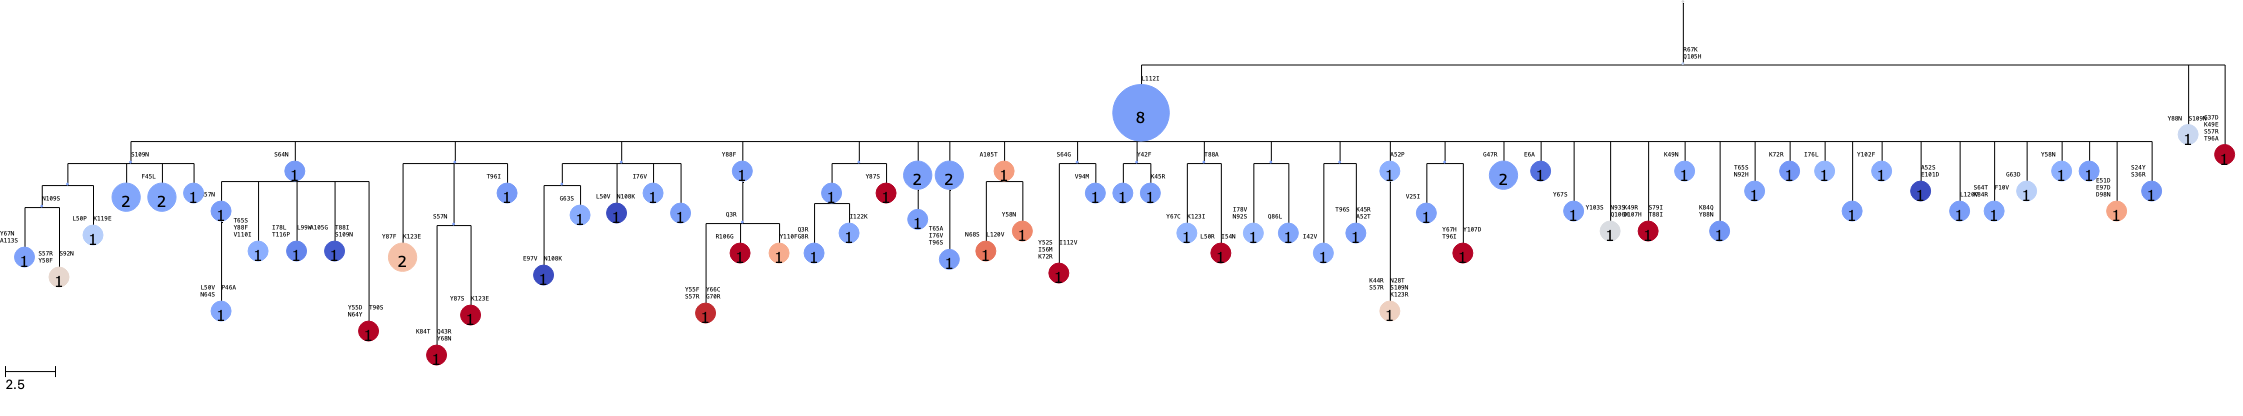

gc72HK-2


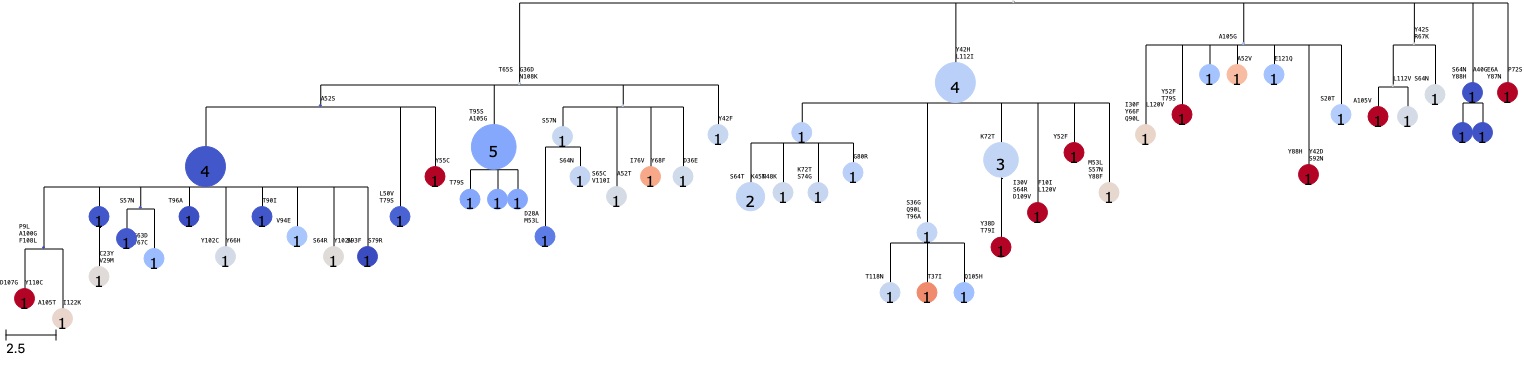

gc73HK-2


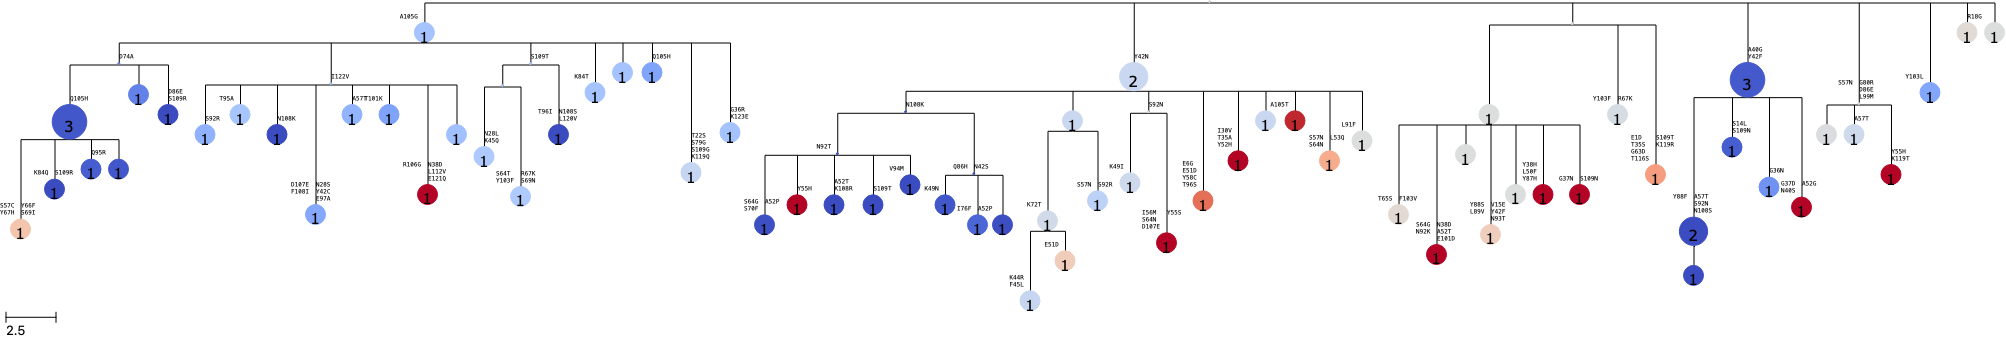

gc58HK-2


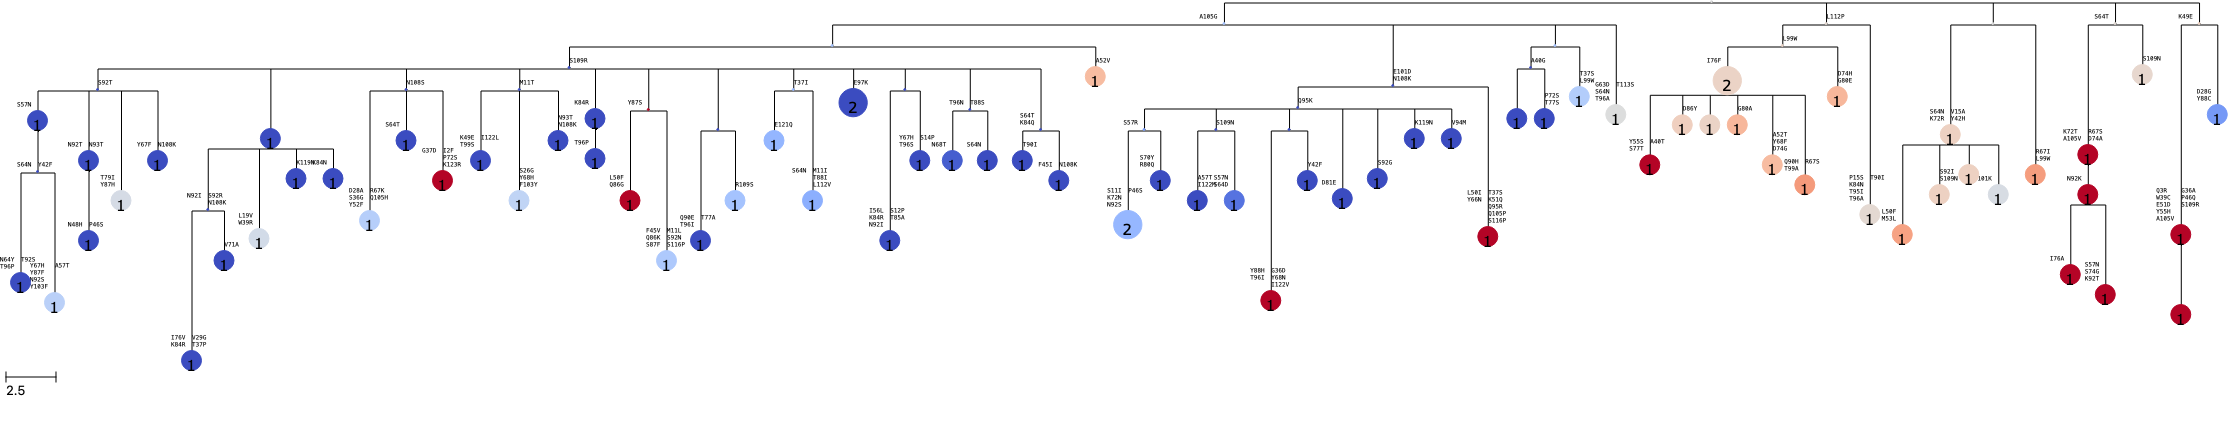

gc74HK-2


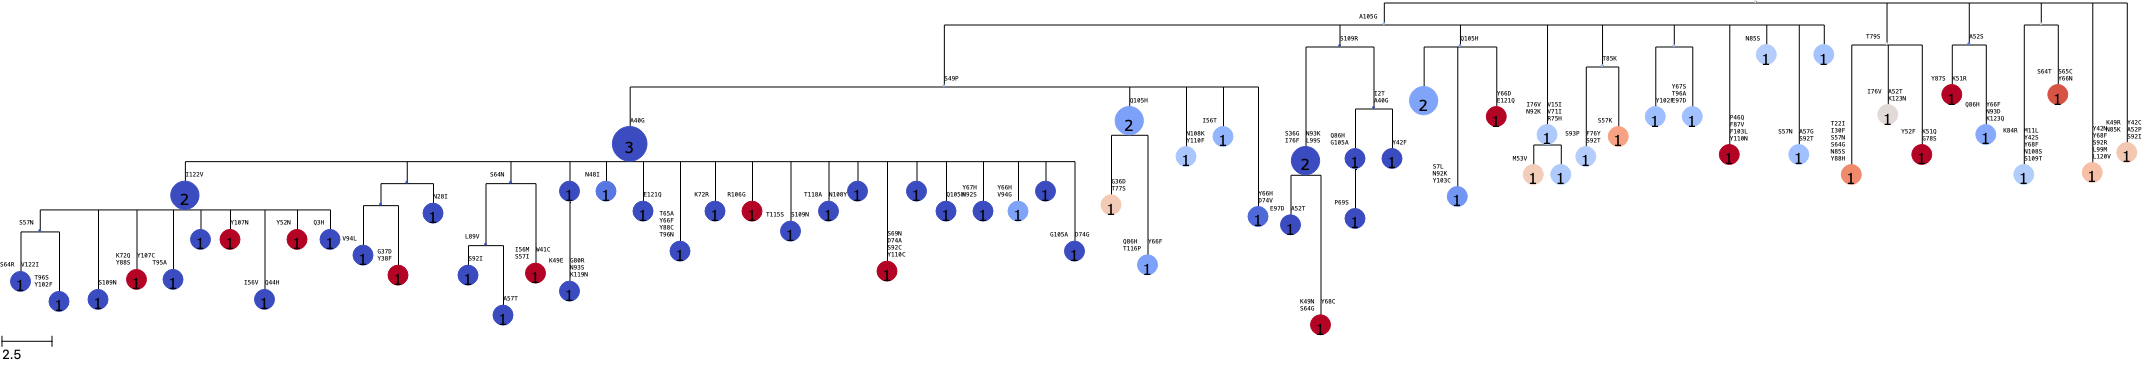

gc48HK-2


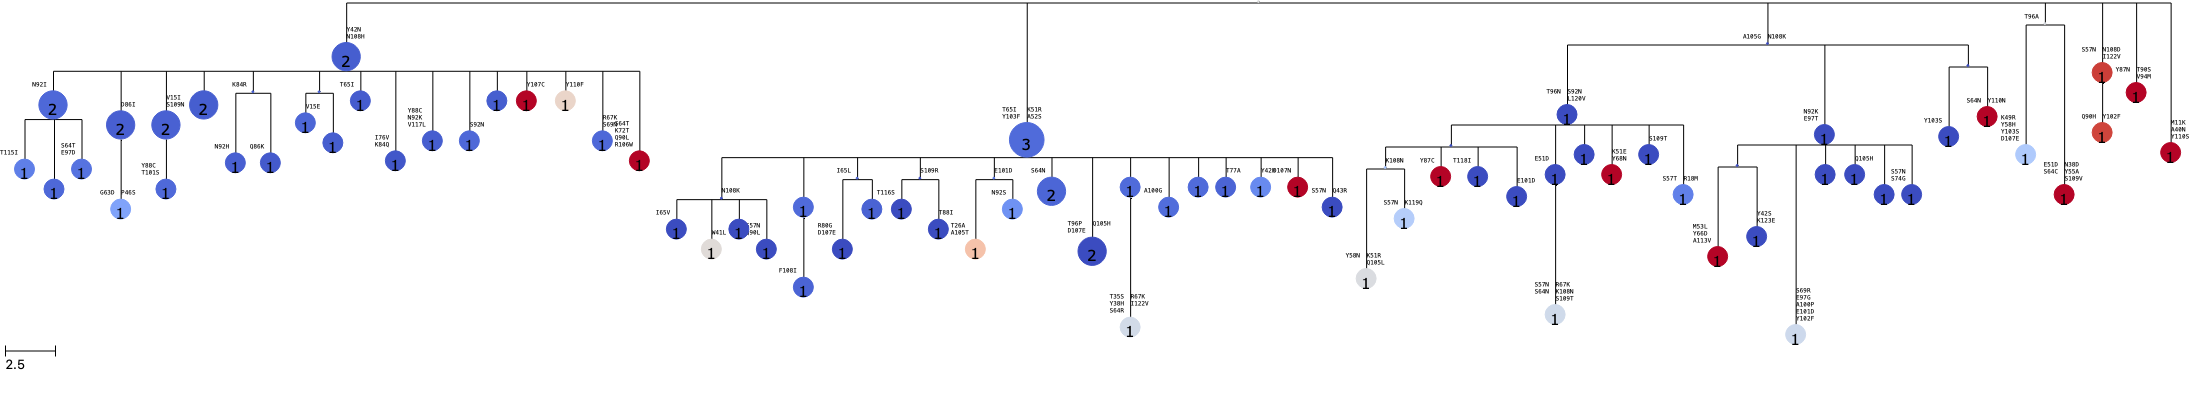

gc47HK-2


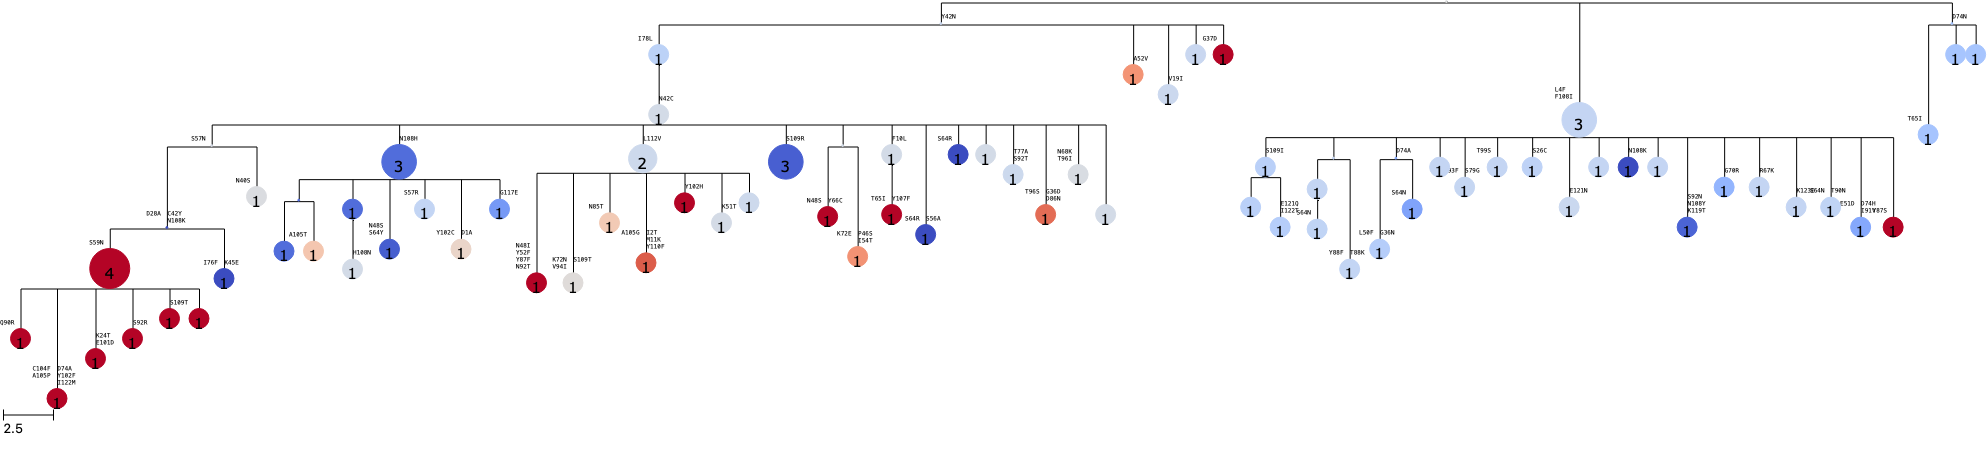

gc78HK-2


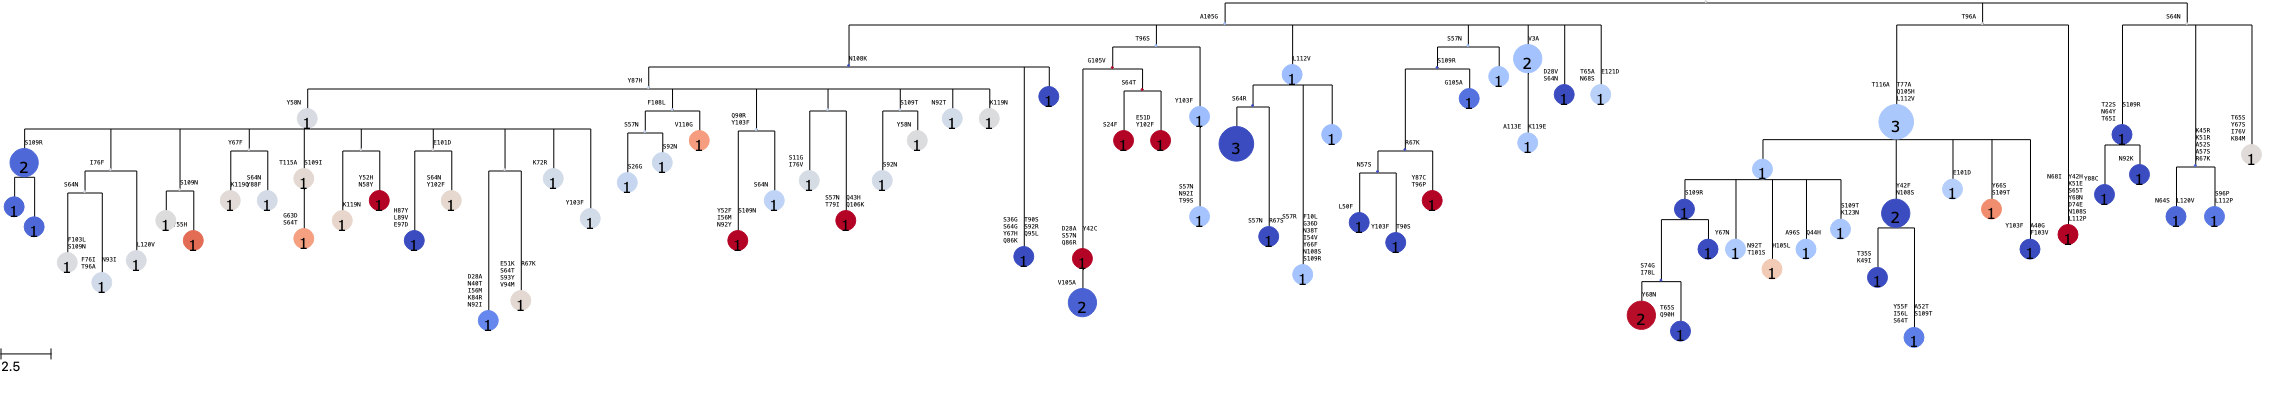

gc55HK-2


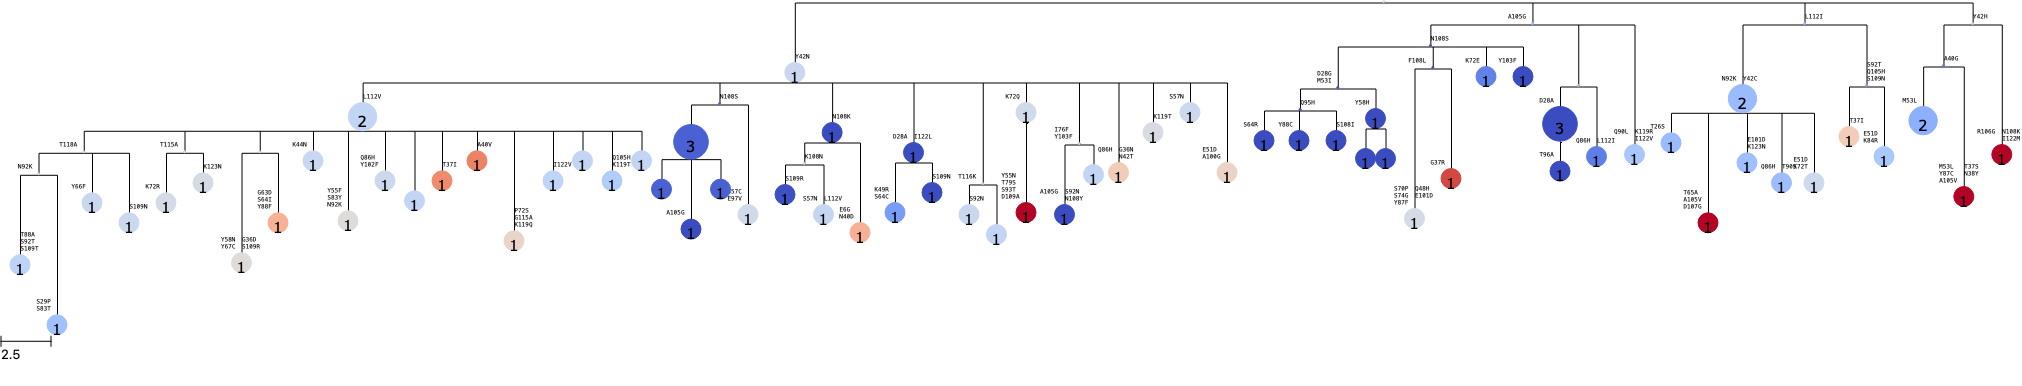

gc82HK-2


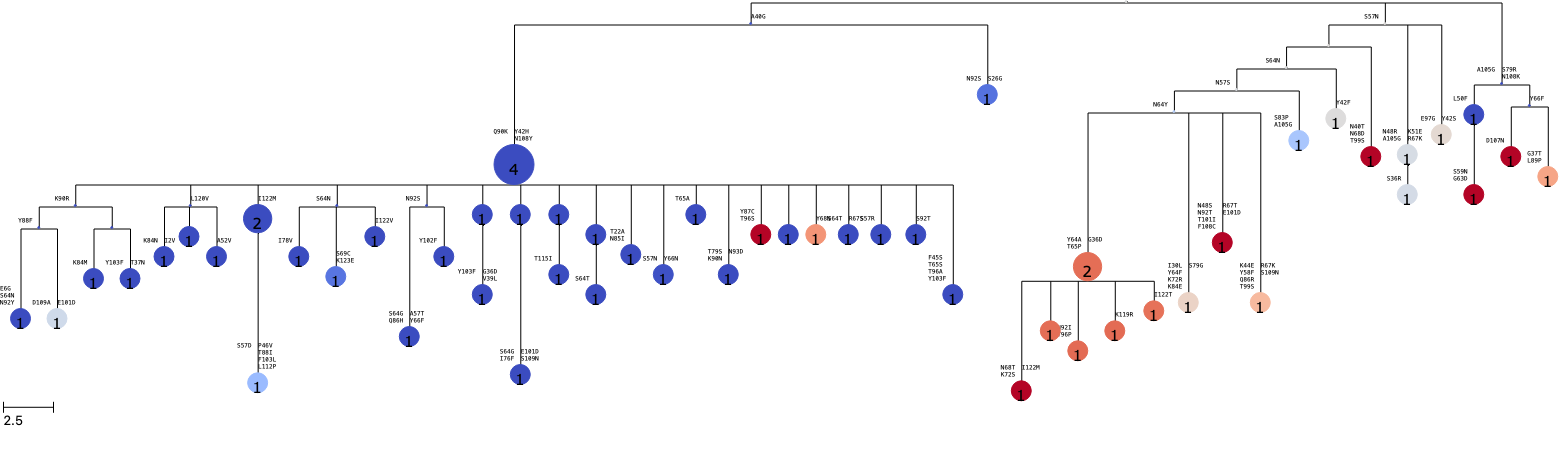

gc83HK-2


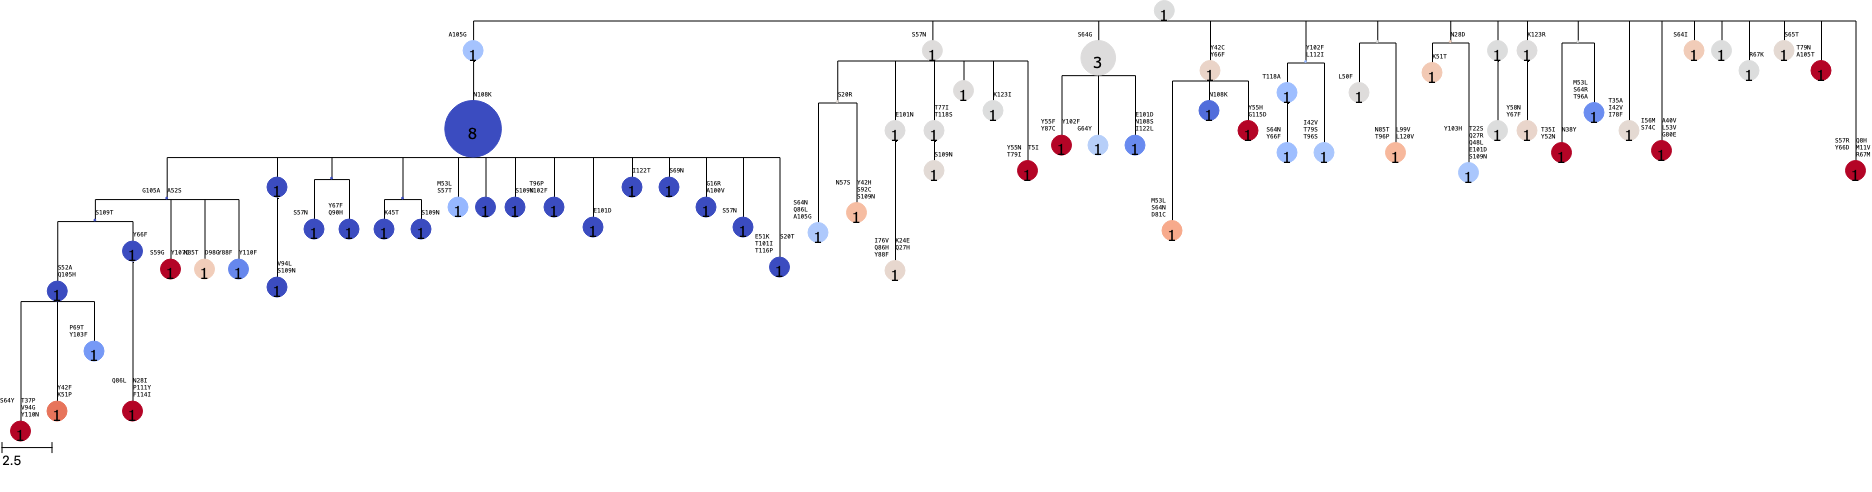

In [25]:
cmap = cm.get_cmap("coolwarm_r")
norm = Normalize(vmin=vmin, vmax=vmax)

for gc, tree in trees.items():
    print(gc)
    colormap = {node.name: to_hex(cmap(norm(node.delta_bind_additive)))
                for node in tree.tree.traverse()}
    for file in (f"output/plots/colormapped_gctrees/{gc}.delta_bind.svg", "%%inline"):
        rendering = tree.render(file, scale=20,
                            colormap=colormap,
                            frame=igh_frame, frame2=igk_frame, chain_split=igk_idx,
                            position_map=igh_pos_map, position_map2=igk_pos_map)
    display(rendering)

## Color map local branching index (LBI or LBR)

gc31HK


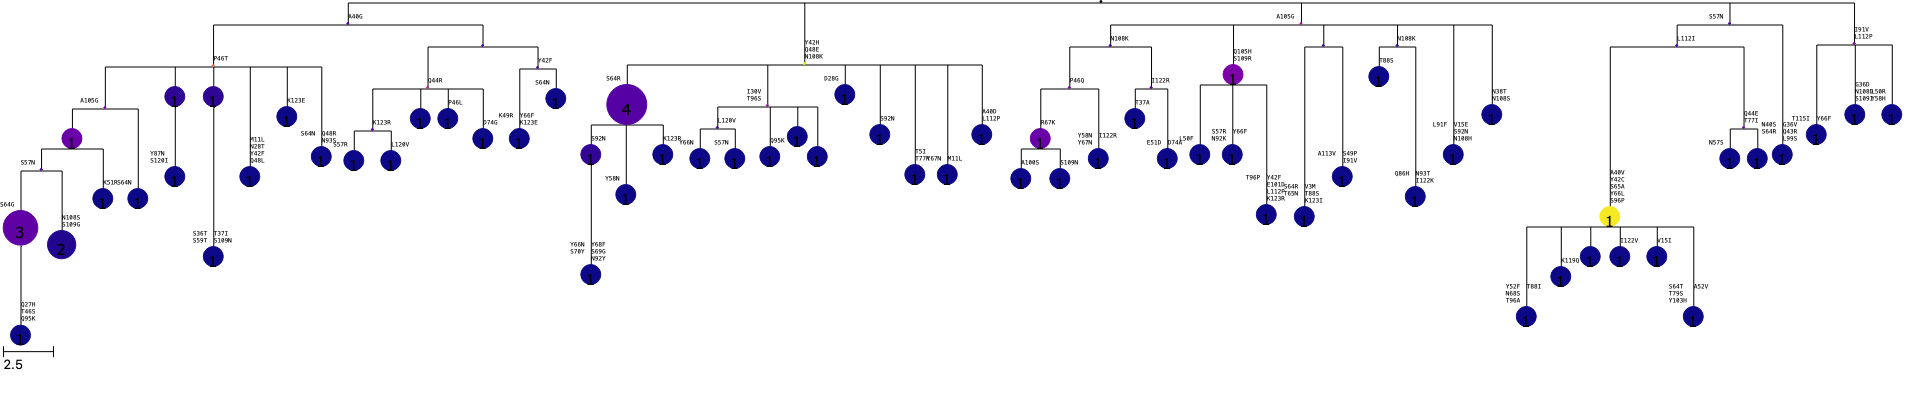

gc50HK


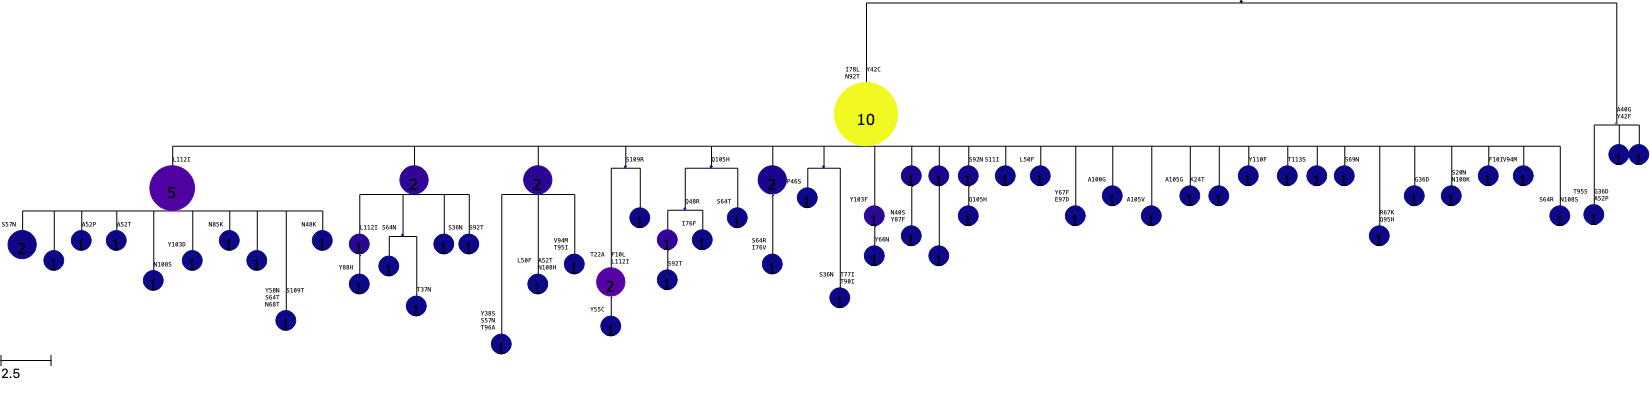

gc59HK


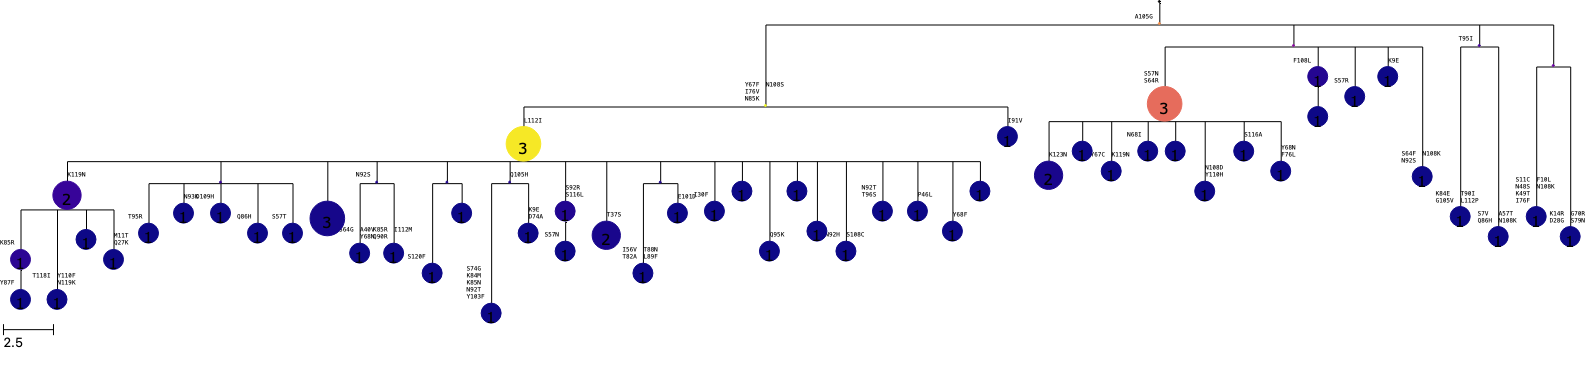

gc17HK


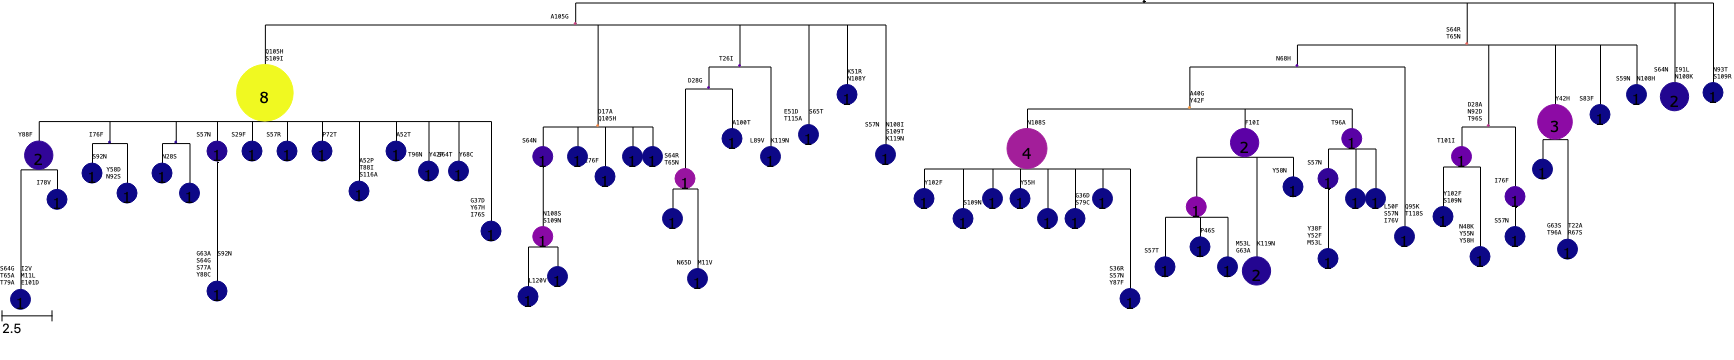

gc56HK


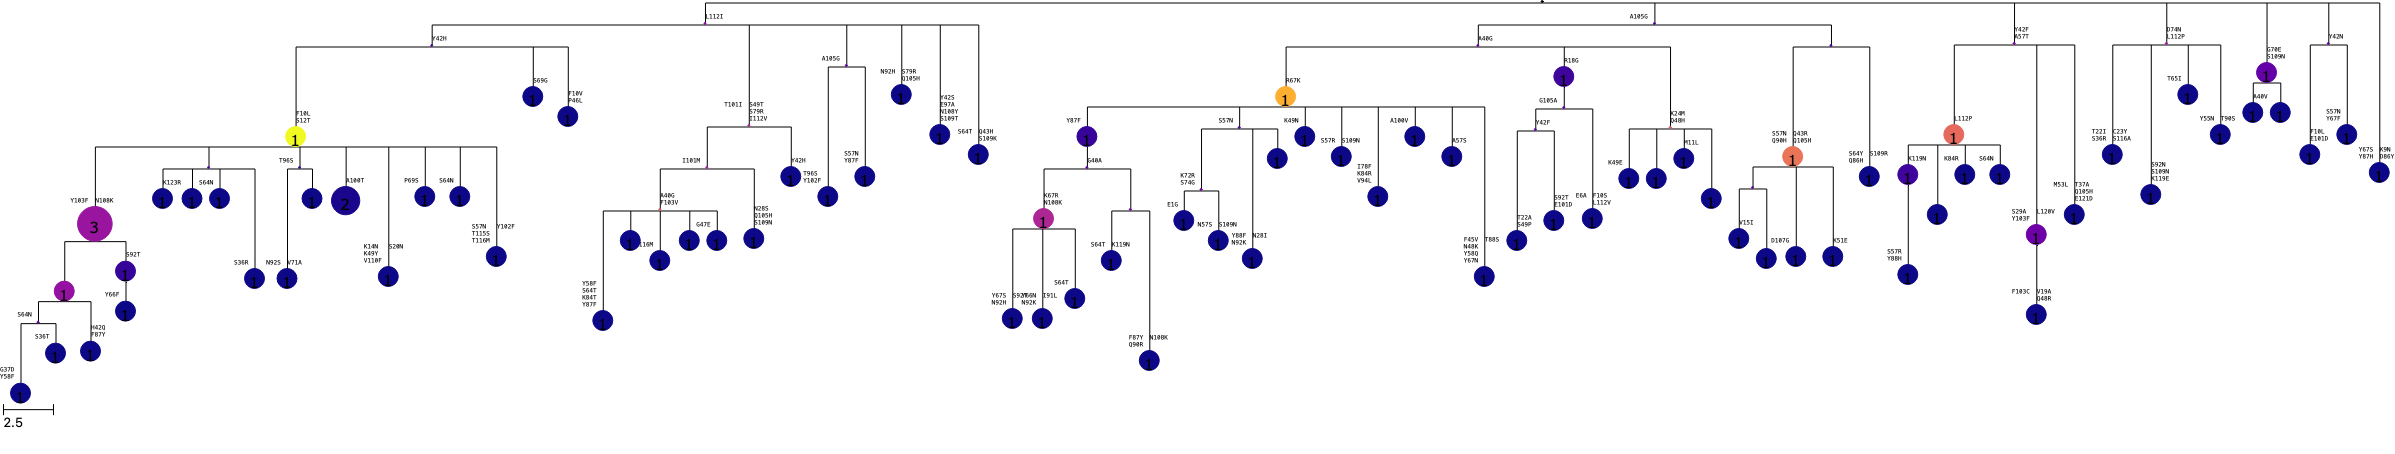

gc39HK


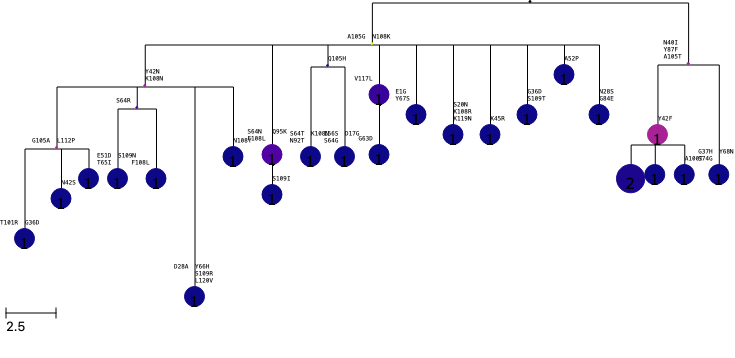

gc77HK


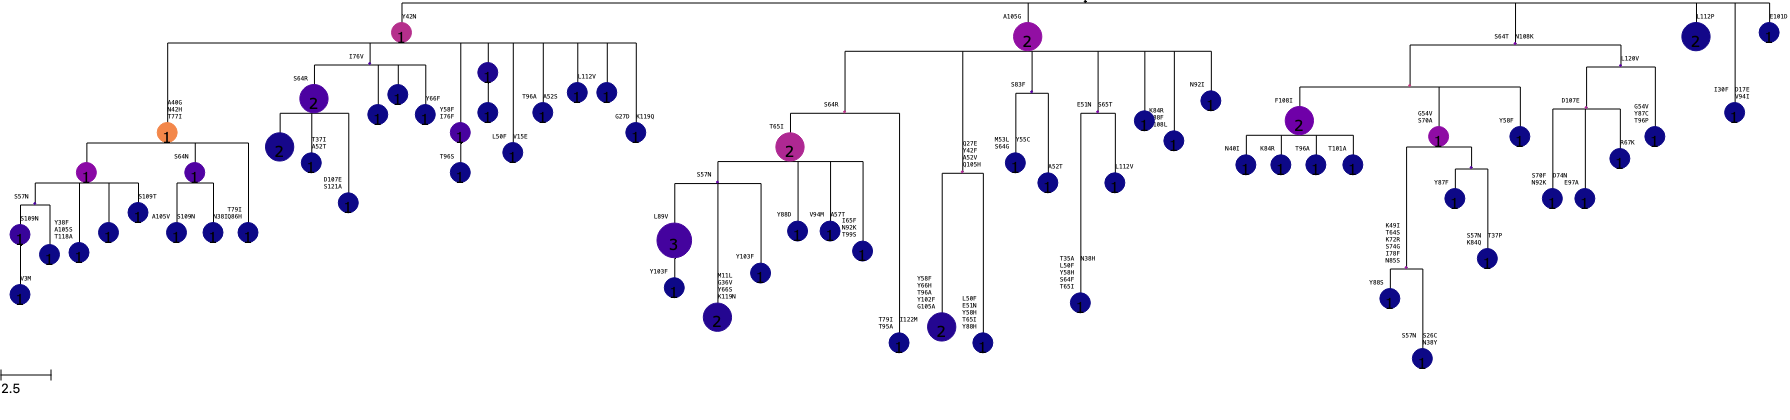

gc16HK


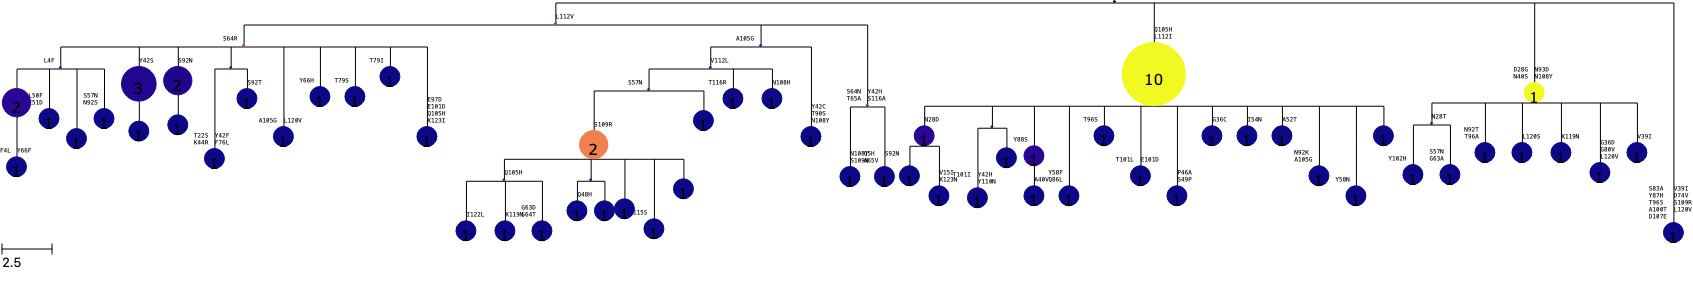

gc46HK


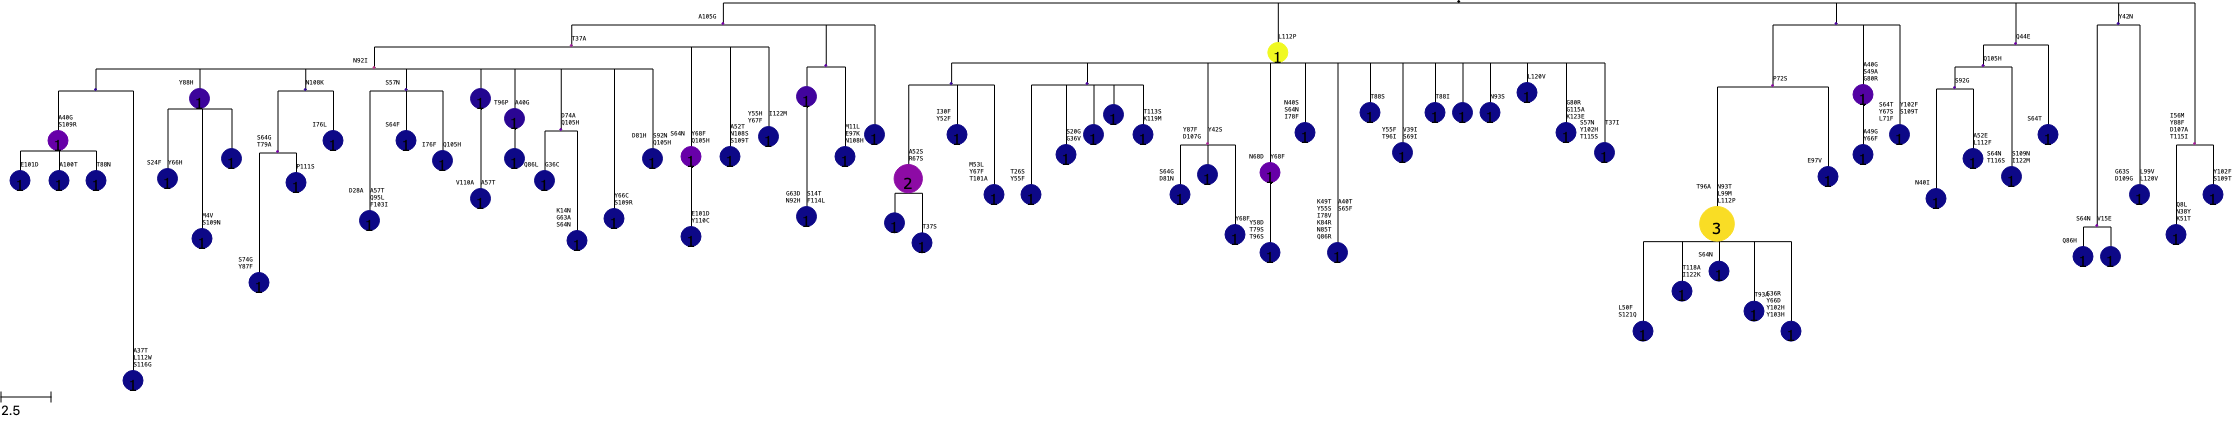

gc30HK


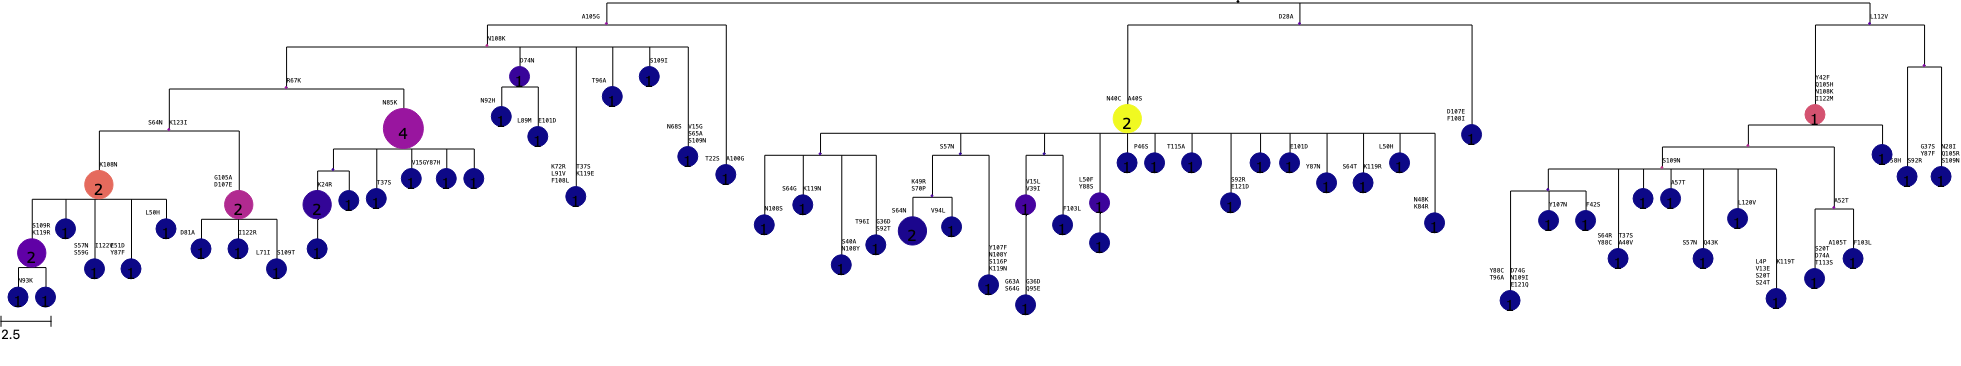

gc14HK


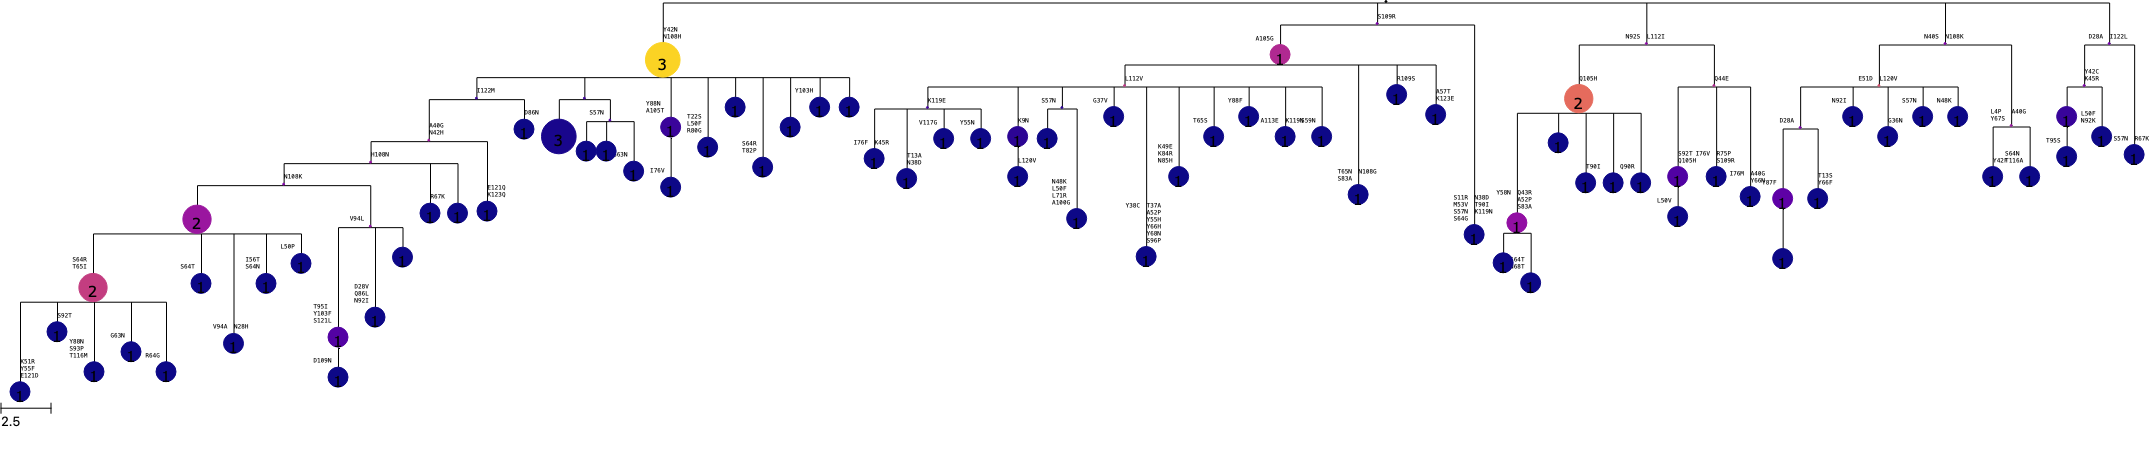

gc6HK


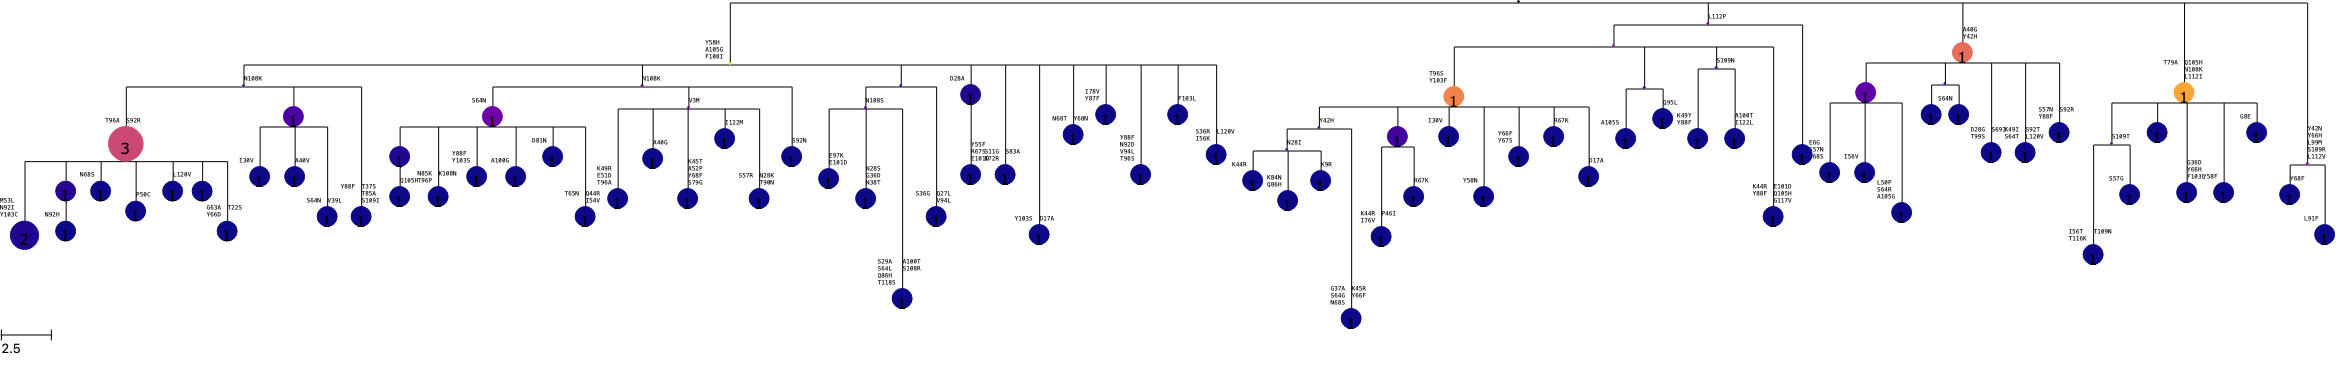

gc2HK


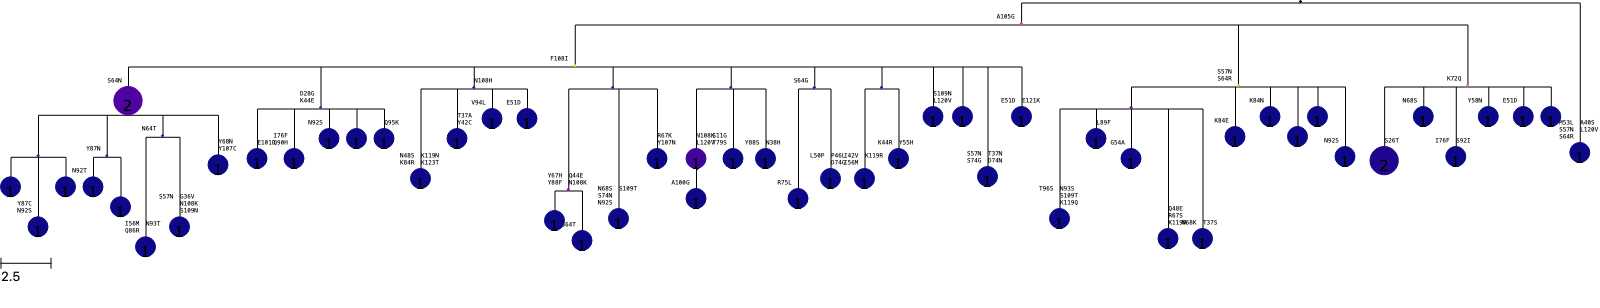

gc81HK


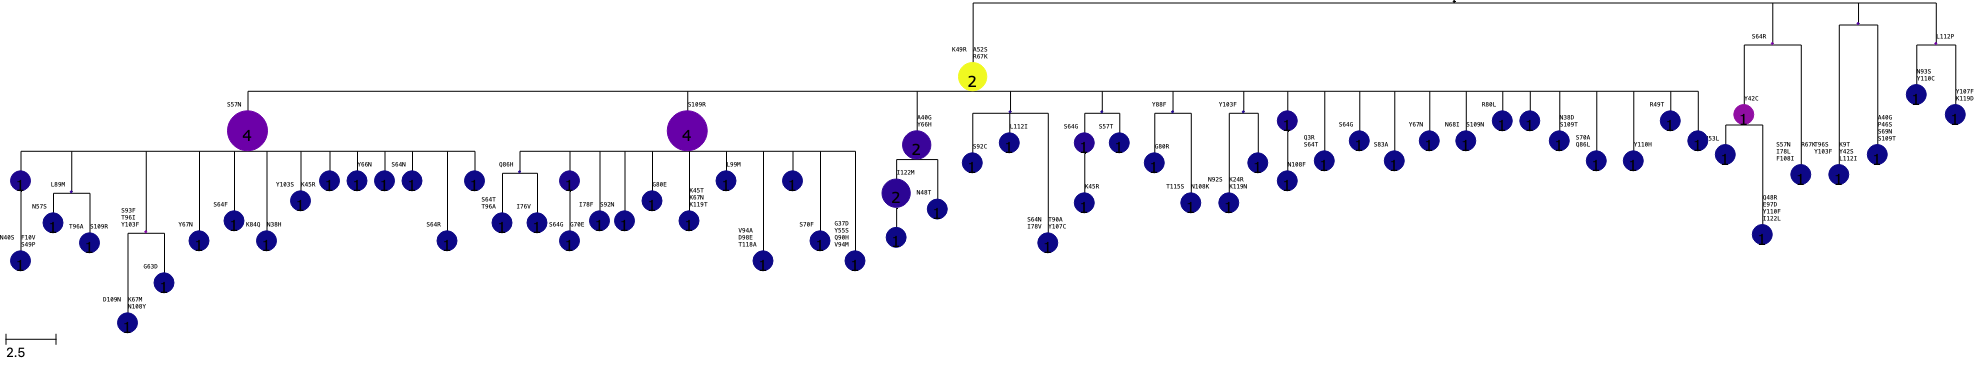

gc1HK


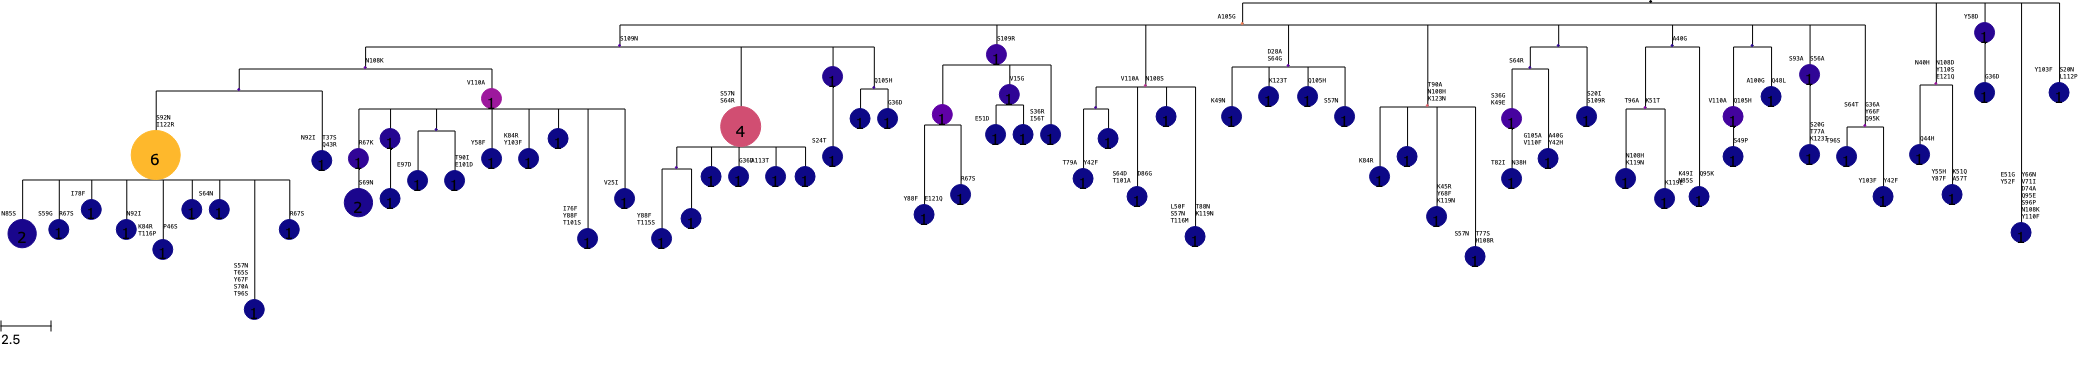

gc68HK


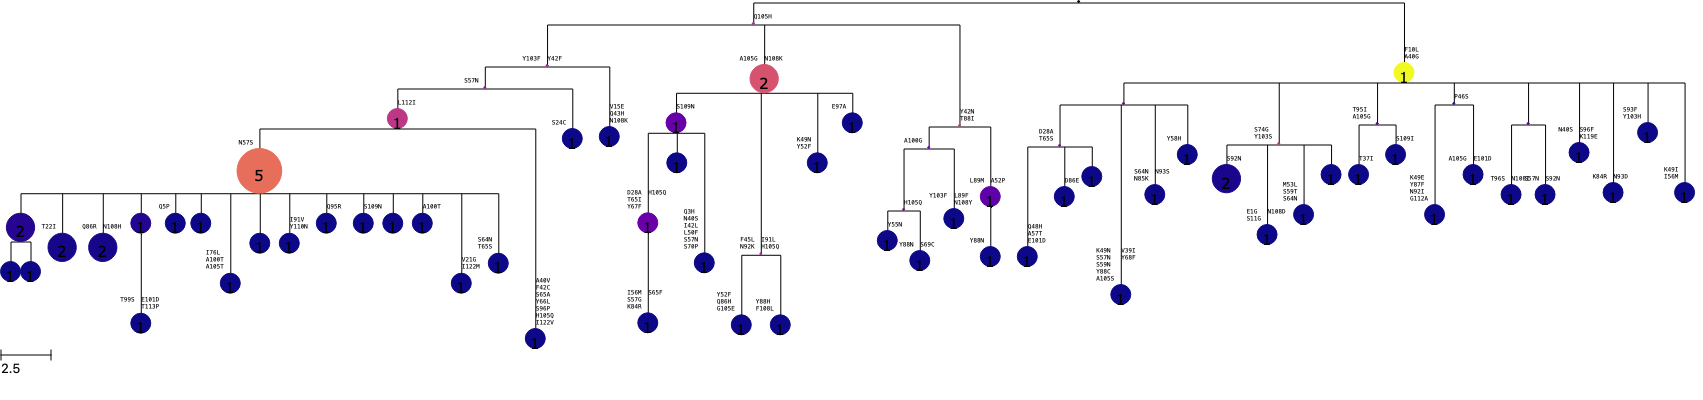

gc79HK


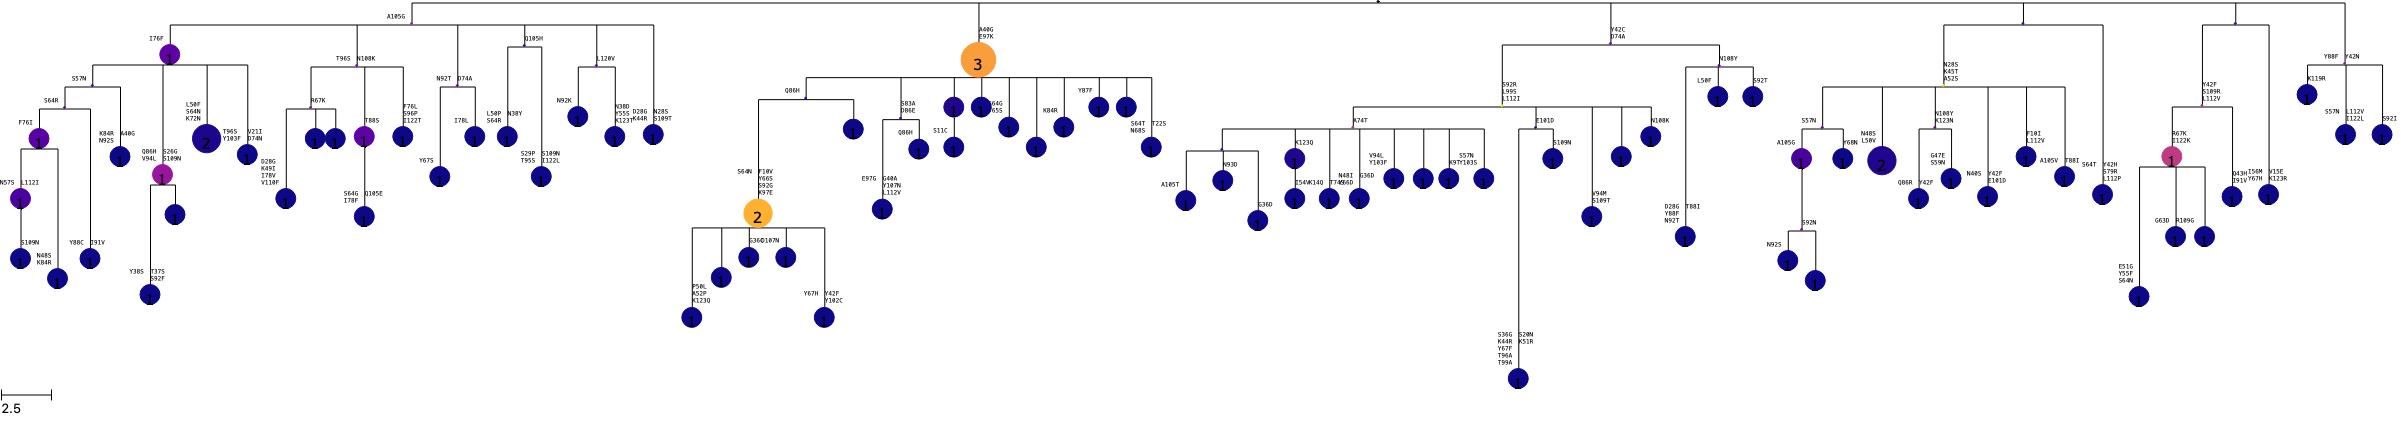

gc80HK


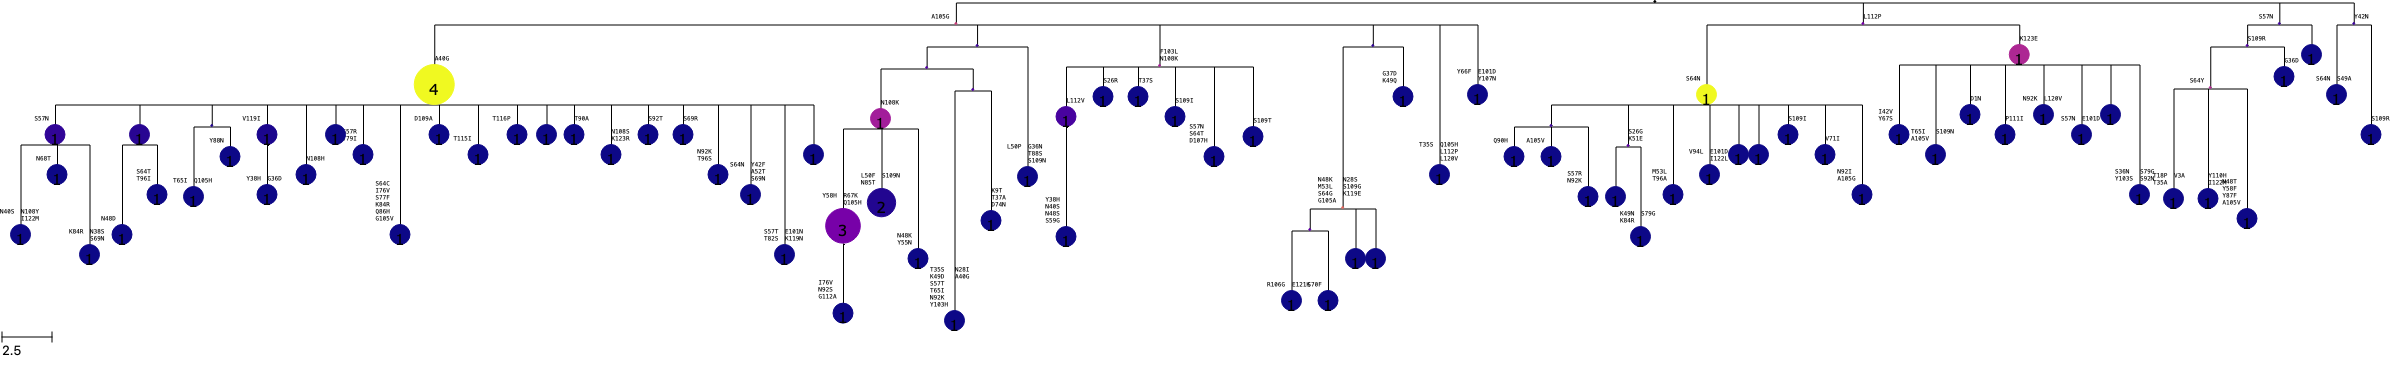

gc69HK


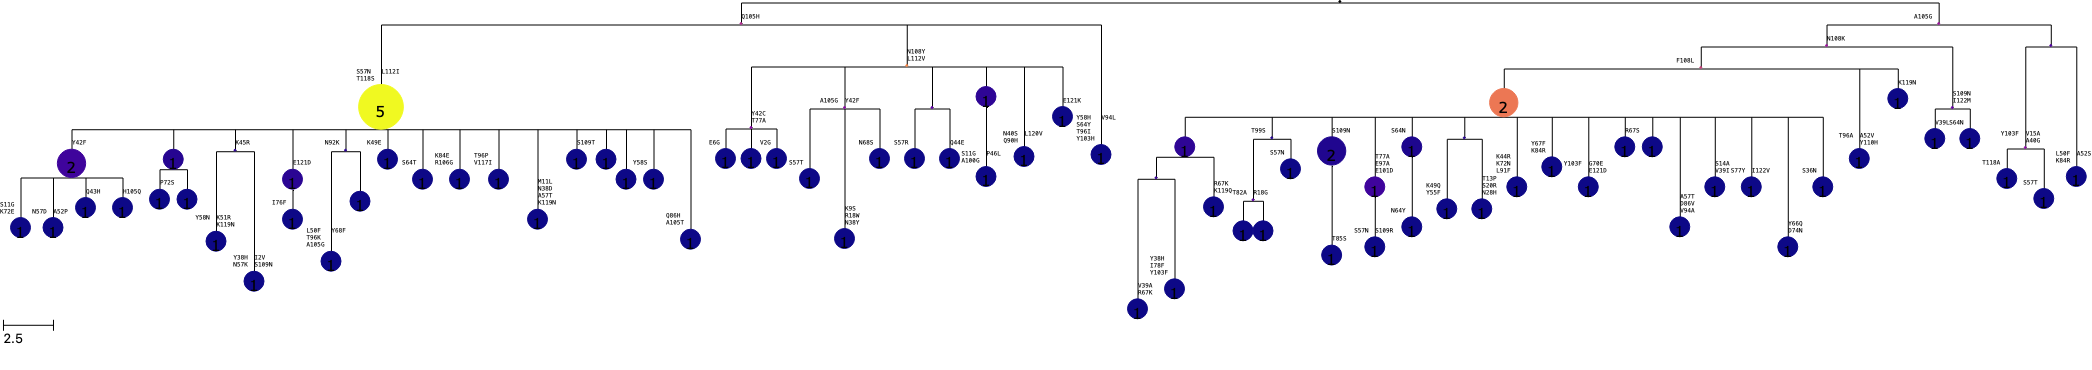

gc70HK


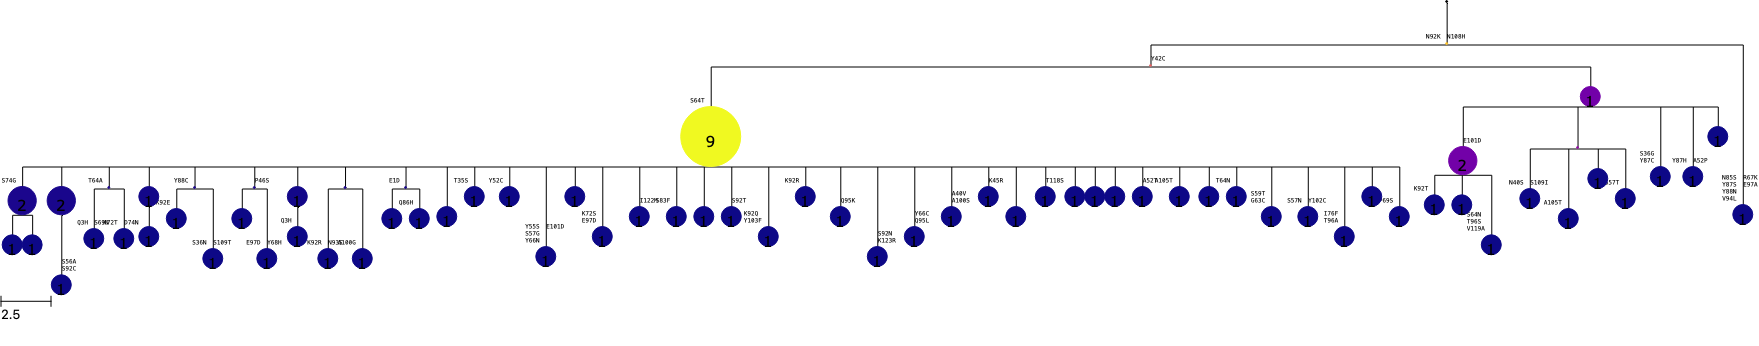

gc15HK


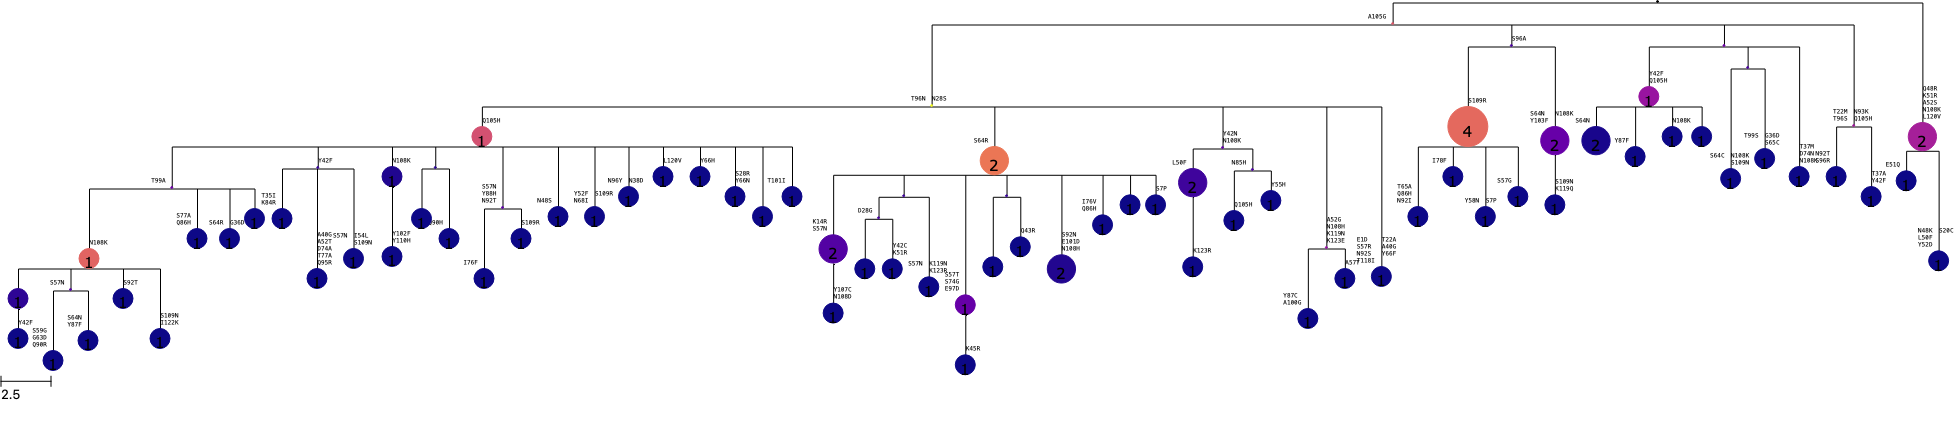

gc32HK


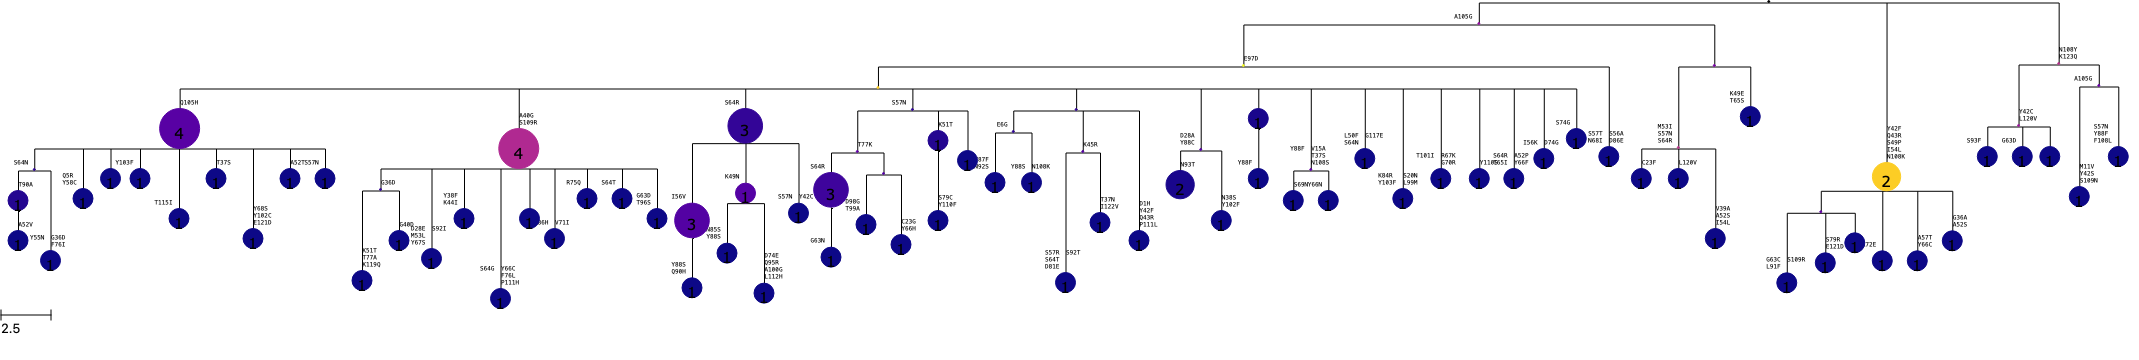

gc20HK-BC1


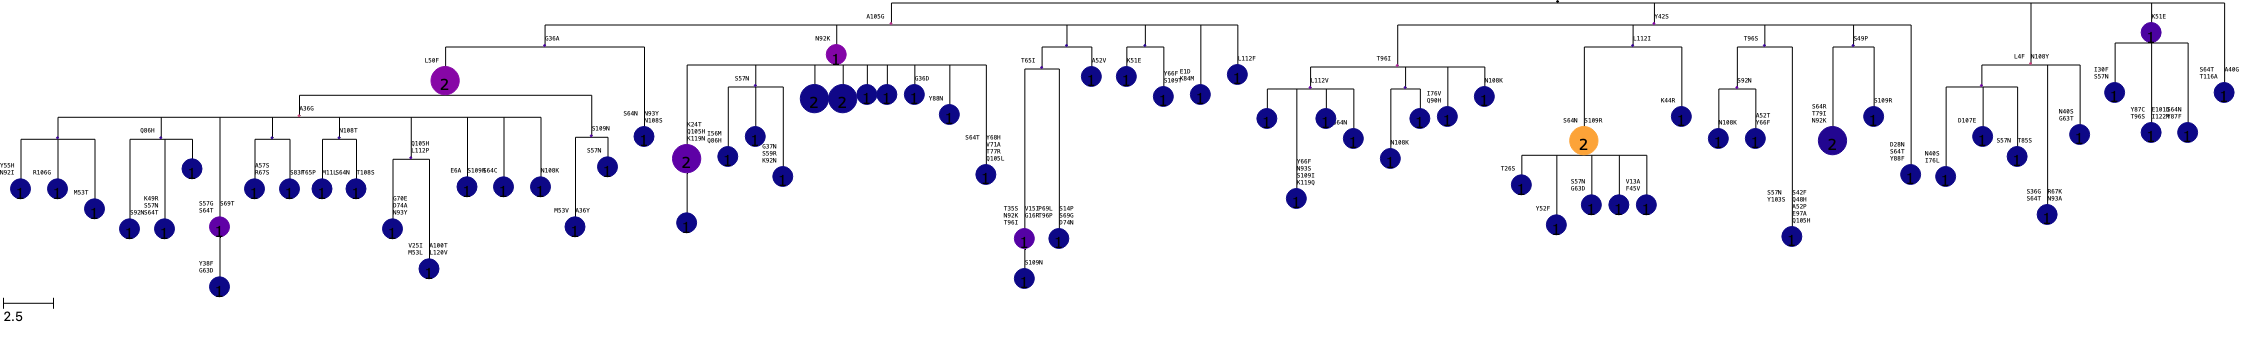

gc38HK-2


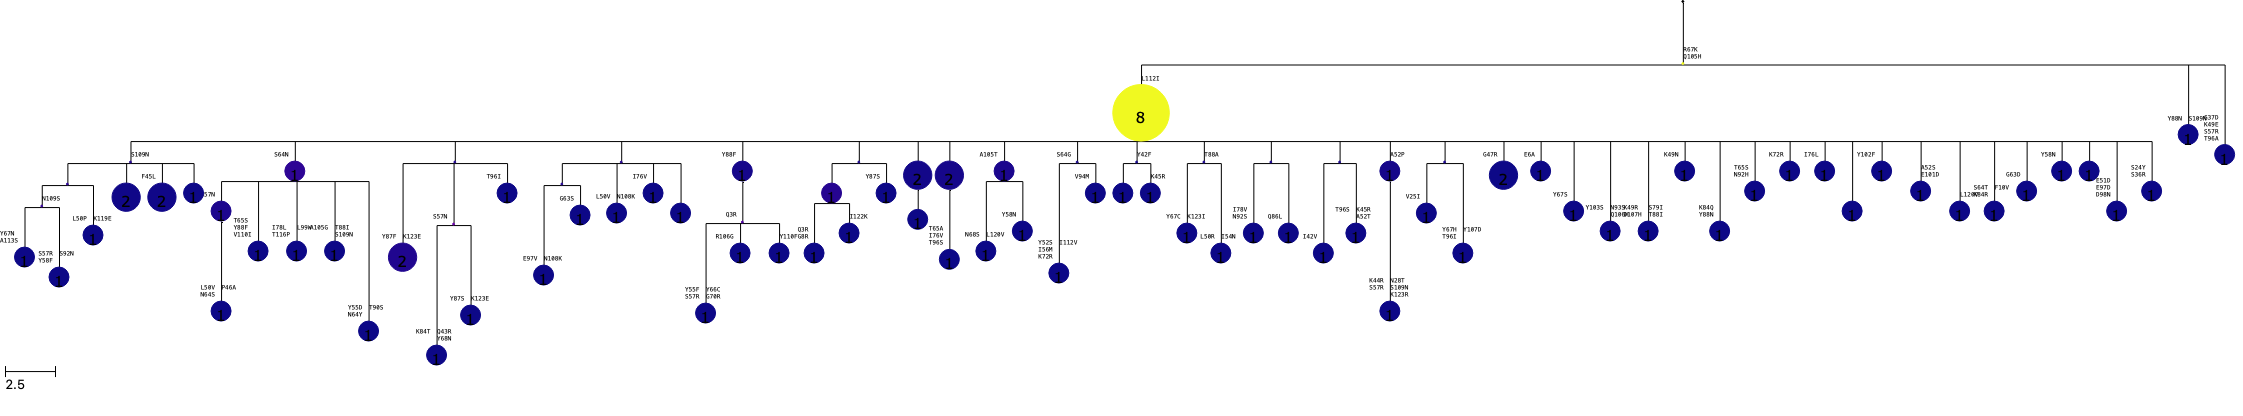

gc72HK-2


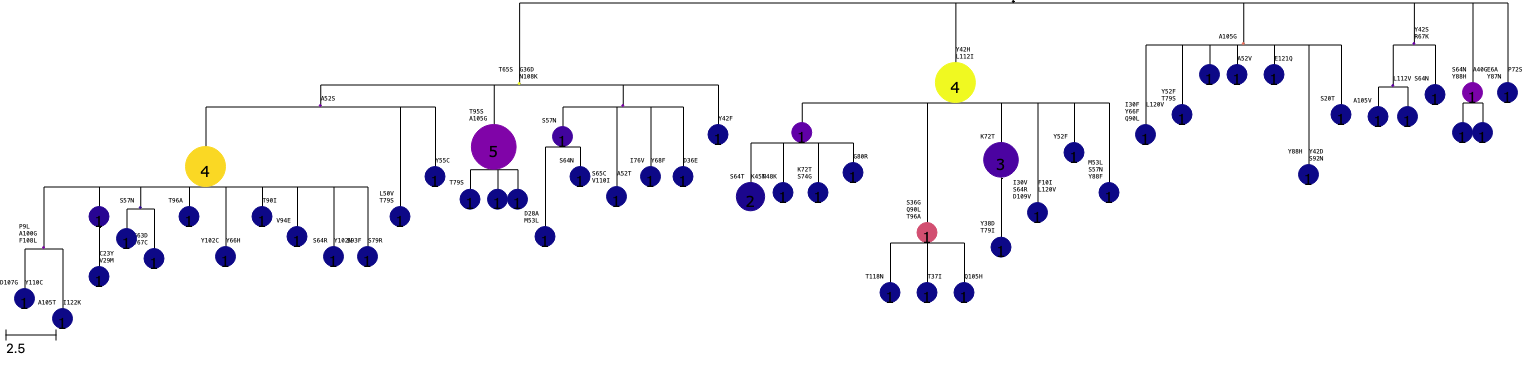

gc73HK-2


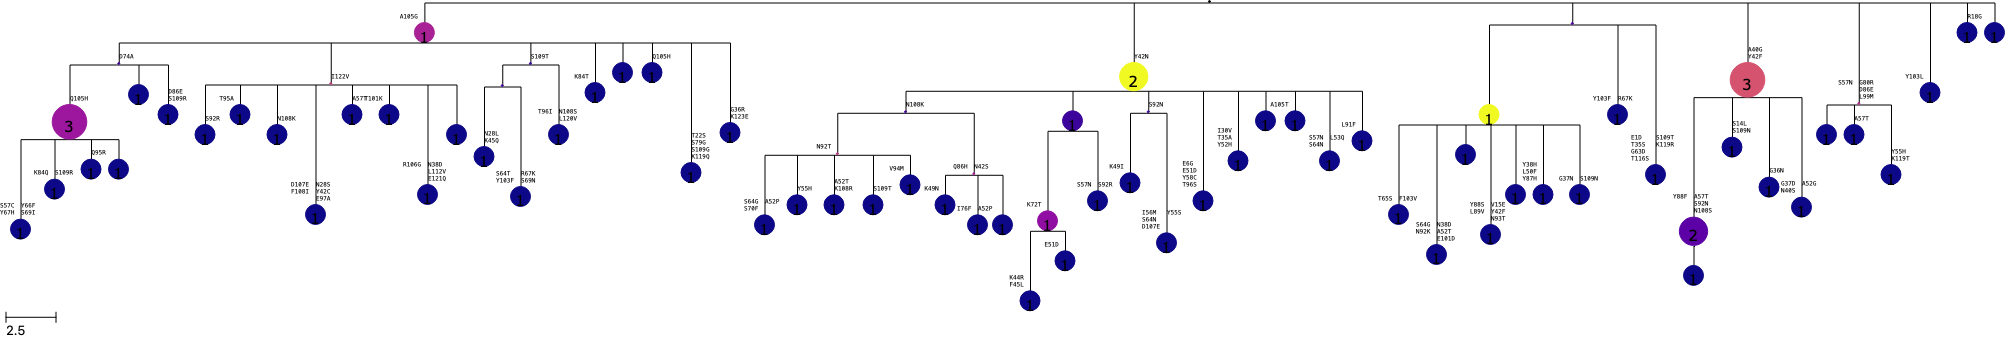

gc58HK-2


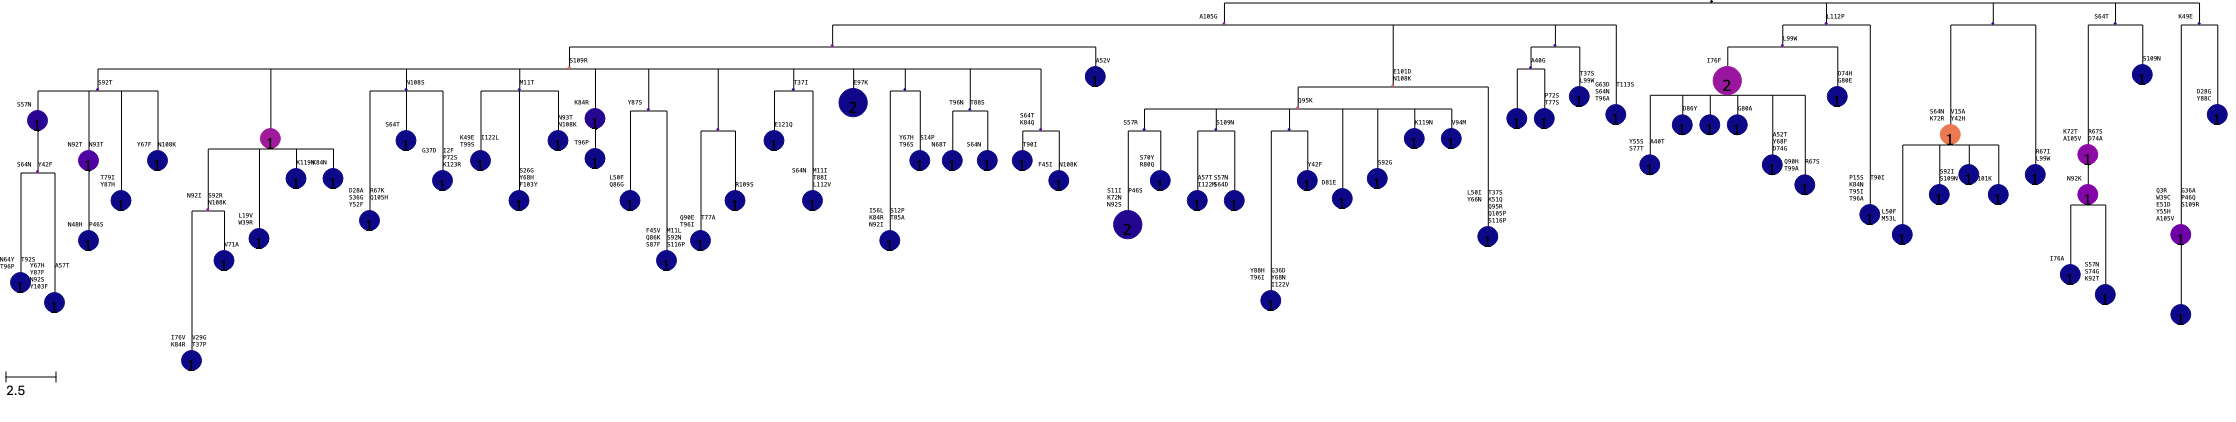

gc74HK-2


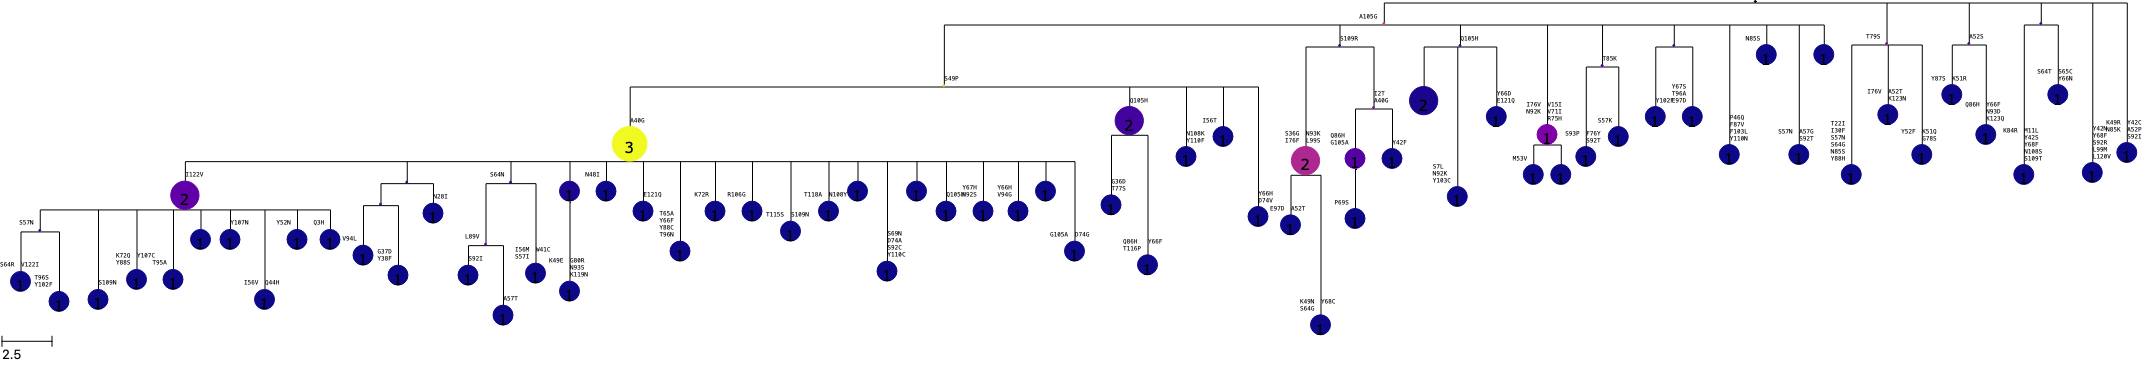

gc48HK-2


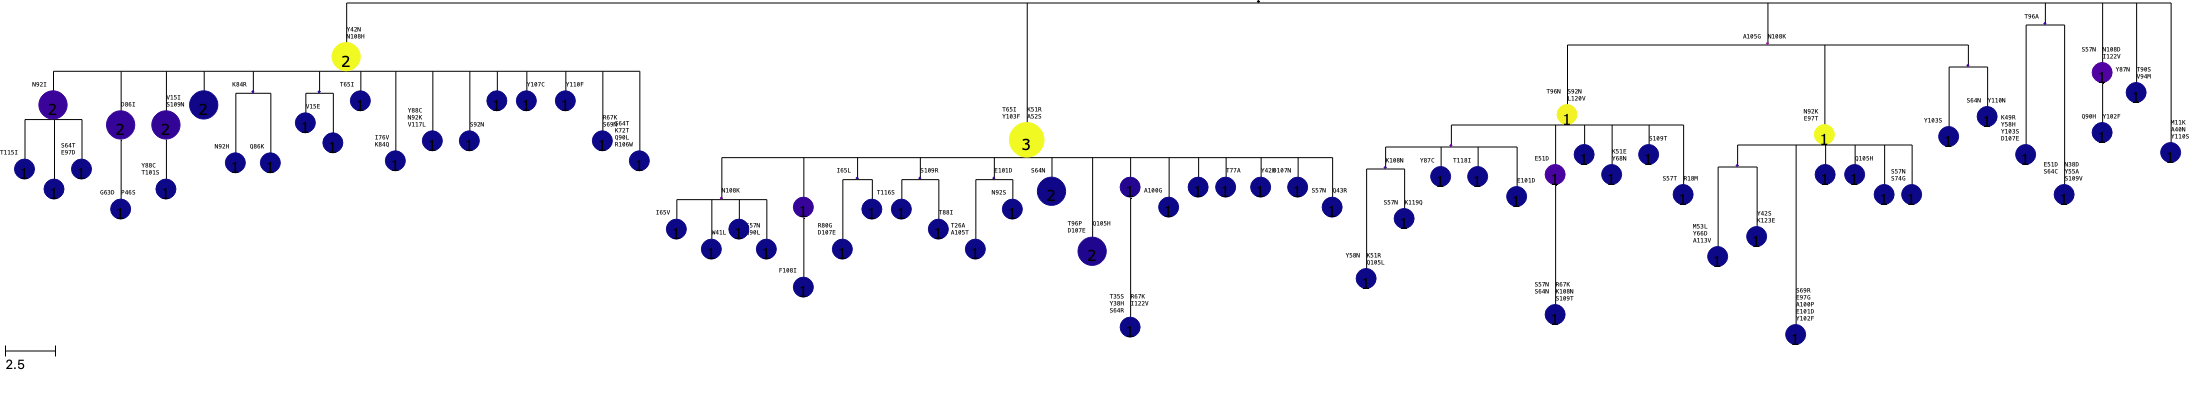

gc47HK-2


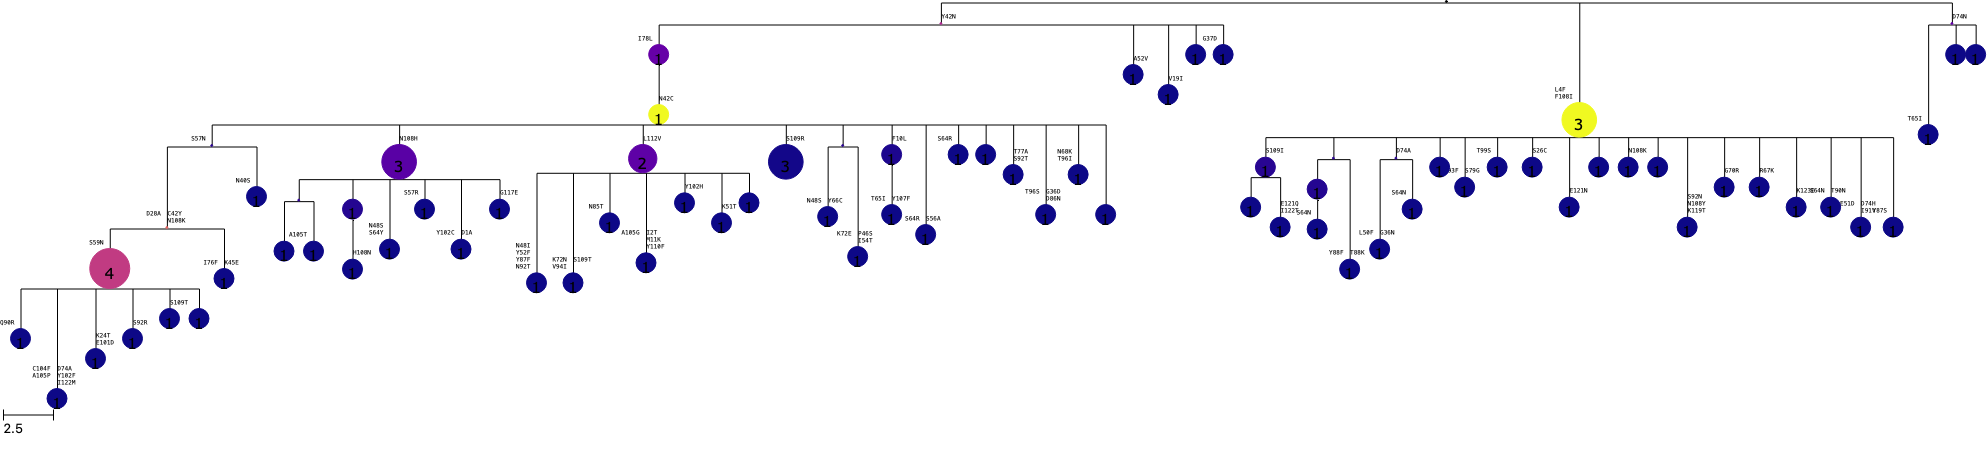

gc78HK-2


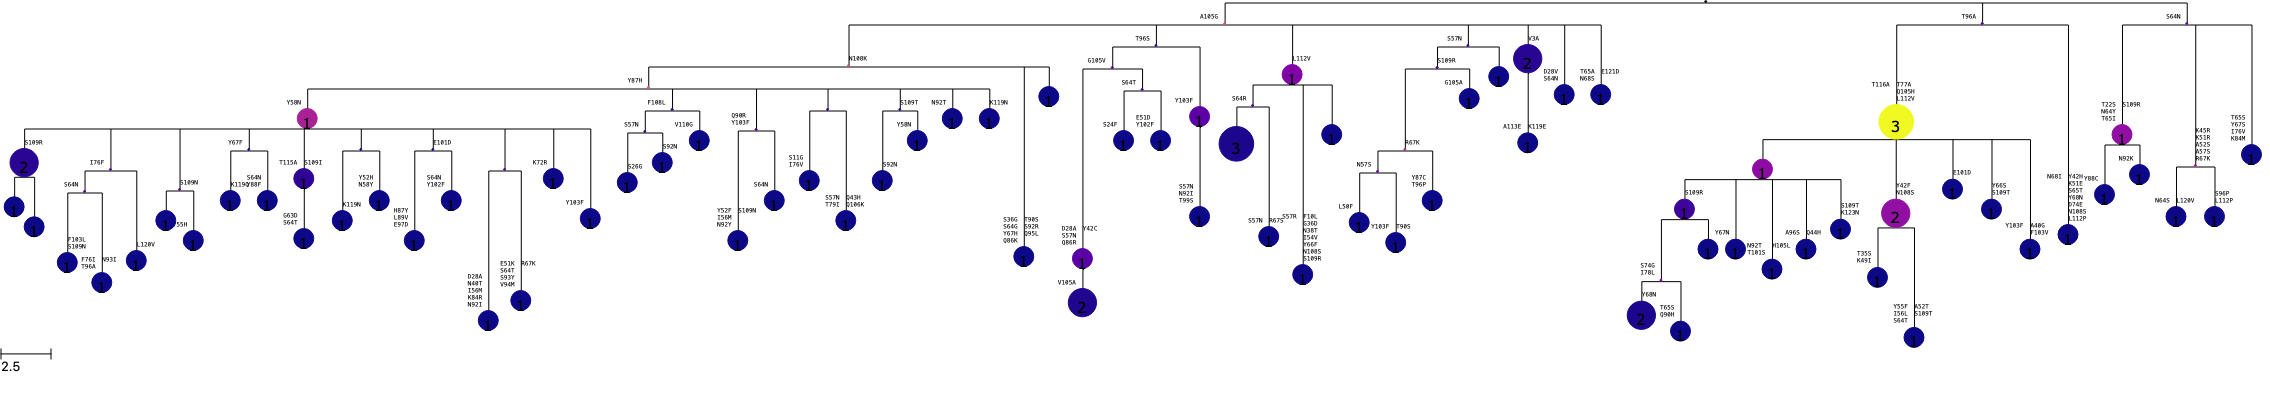

gc55HK-2


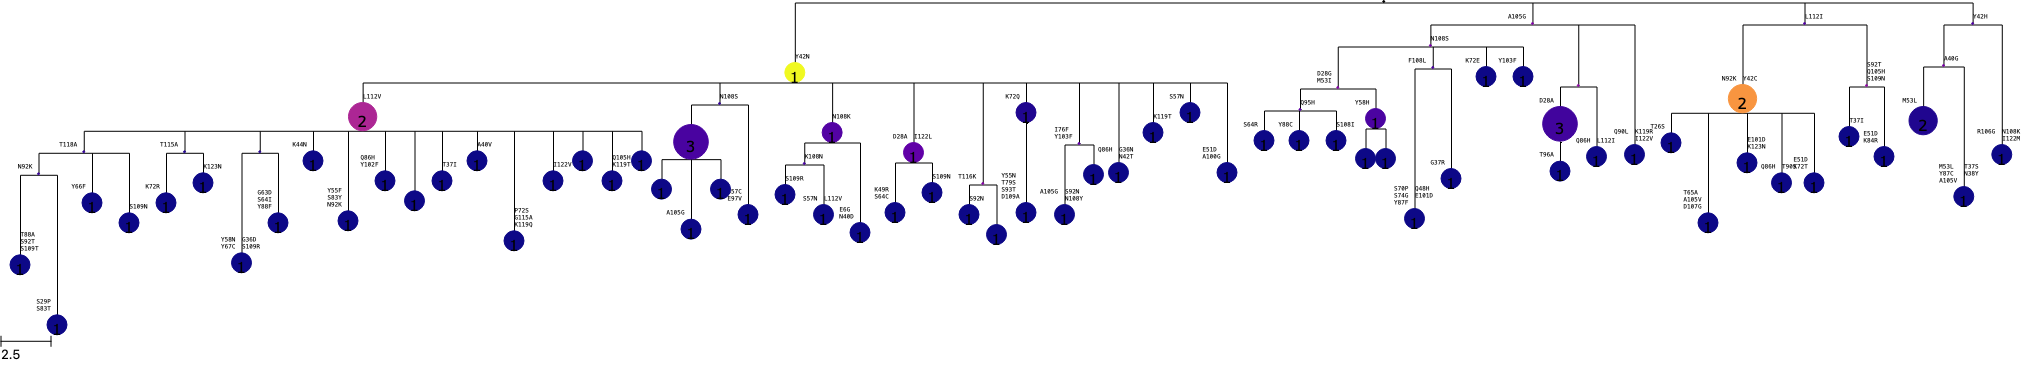

gc82HK-2


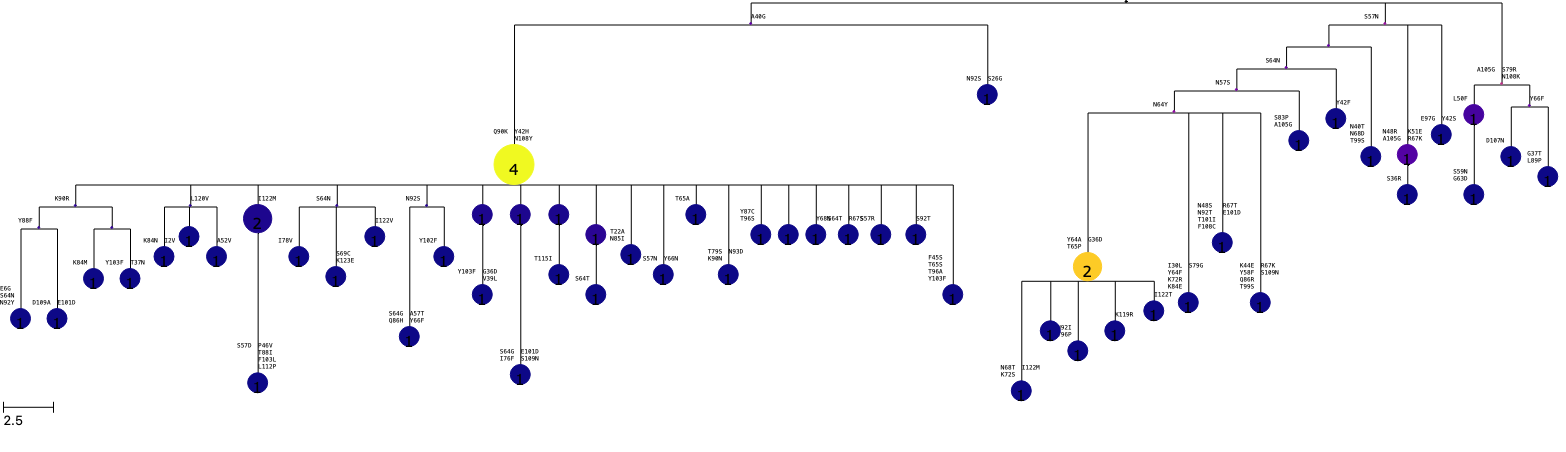

gc83HK-2


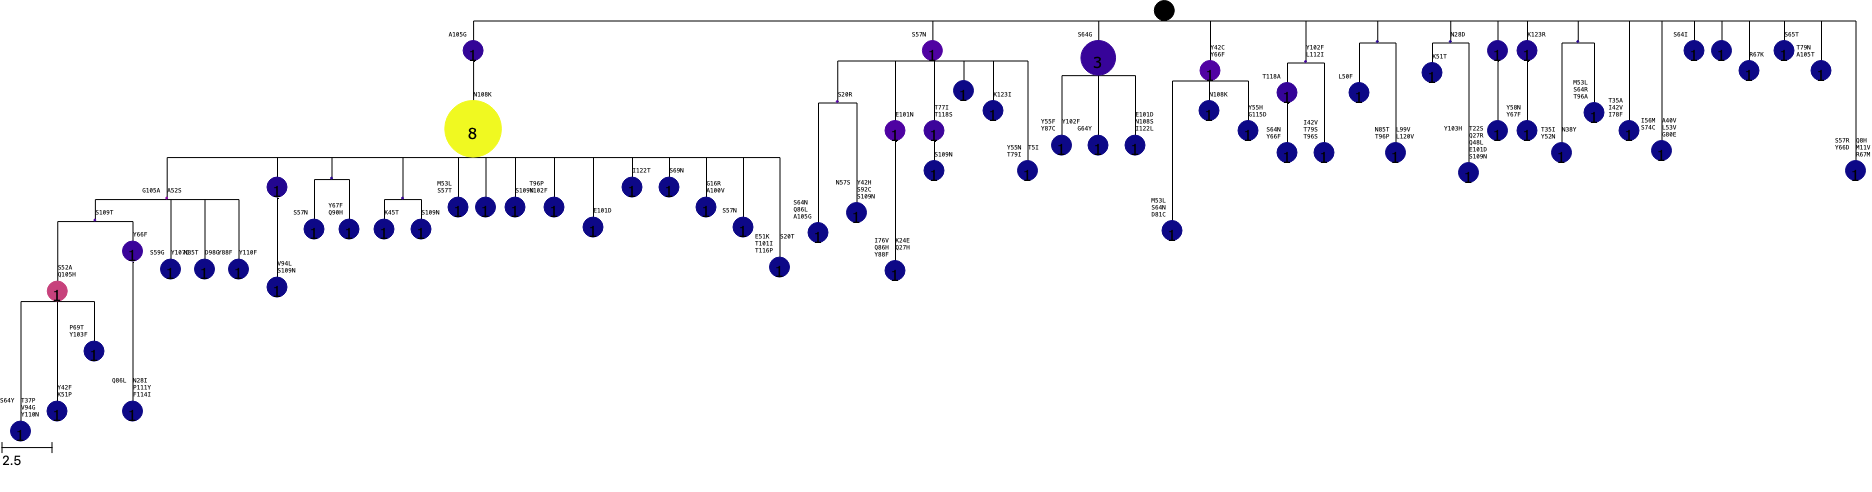

In [49]:
cmap = cm.get_cmap("plasma")
vmin_LB = 0
vmax_LB = 5
norm = Normalize(vmin=vmin_LB, vmax=vmax_LB)
for gc, tree in trees.items():
    print(gc)
    colormap = {node.name: to_hex(cmap(norm(node.LBR))) for node in tree.tree.traverse()}
    for file in (f"output/plots/colormapped_gctrees/{gc}.LBR.svg", "%%inline"):
        rendering = tree.render(file, scale=20,
                            colormap=colormap,
                            frame=igh_frame, frame2=igk_frame, chain_split=igk_idx,
                            position_map=igh_pos_map, position_map2=igk_pos_map)
    display(rendering)

## Compare TorchDMS to naive additive model

on tree nodes

In [28]:
tdmsVSadditive_df = pd.DataFrame()
for gc, tree in trees.items():
    for node in tree.tree.traverse():
        if node.abundance:
            new_row = pd.Series({"delta_bind_tdms": node.delta_bind_tdms,
                                 "delta_bind_additive": node.delta_bind_additive,
                                 "delta_expr_tdms": node.delta_expr_tdms,
                                 "delta_expr_additive": node.delta_expr_additive})
            tdmsVSadditive_df = tdmsVSadditive_df.append(new_row, ignore_index=True, verify_integrity=True)
tdmsVSadditive_df

delta_bind_tdms  delta_bind_additive  delta_expr_tdms  \
0            0.631612              0.02777        -1.021183   
1           -0.601261             -1.51624        -2.353238   
2            0.191244             -0.26601        -1.389293   
3            1.007847              0.72164        -1.581321   
4            0.622931              1.01620        -0.671044   
...               ...                  ...              ...   
2288         0.619968              1.02962        -0.498781   
2289        -0.346078             -1.74805        -4.018593   
2290         0.874365              0.57016        -1.563043   
2291         0.284425             -0.60392        -2.583671   
2292        -0.420179             -3.30400        -4.134657   

      delta_expr_additive  
0                -0.00359  
1                -0.40323  
2                -0.25516  
3                -0.34072  
4                -0.05767  
...                   ...  
2288              0.06592  
2289             -1.65148  
2290             -0.26490  
2291             -2.14966  
2292             -1.13774  

[2293 rows x 4 columns]

...and for single mutants

In [29]:
def single_mut_seq(row):
    aa_seq = pos_df.amino_acid.copy()
    assert aa_seq[row.position] == row.wildtype
    aa_seq[row.position] = row.mutant
    aa_seq = "".join(aa_seq)
    tdms_prediction = tdms_model(tdms_model.seq_to_binary(aa_seq)).detach() - tdms_prediction_naive
    return tdms_prediction

dms_df[["delta_bind_tdms", "delta_expr_tdms"]] = dms_df.apply(single_mut_seq, axis=1, result_type="expand")
dms_df

target wildtype  position  position_IMTG chain mutant codon  \
mutation                                                                   
E1(H)A    CGG_naive        E         1              1     H      A   GAG   
E1(H)C    CGG_naive        E         1              1     H      C   GAG   
E1(H)D    CGG_naive        E         1              1     H      D   GAG   
E1(H)E    CGG_naive        E         1              1     H      E   GAG   
E1(H)F    CGG_naive        E         1              1     H      F   GAG   
...             ...      ...       ...            ...   ...    ...   ...   
R124(L)S  CGG_naive        R       235            124     L      S   CGT   
R124(L)T  CGG_naive        R       235            124     L      T   CGT   
R124(L)V  CGG_naive        R       235            124     L      V   CGT   
R124(L)W  CGG_naive        R       235            124     L      W   CGT   
R124(L)Y  CGG_naive        R       235            124     L      Y   CGT   

         single_nt      bind  delta_bind  ...  n_bc_psr  n_libs_psr     WT  \
mutation                                  ...                                
E1(H)A        True  10.48829     0.03110  ...      17.0         2.0  False   
E1(H)C       False  10.44477    -0.01243  ...      17.0         2.0  False   
E1(H)D        True  10.42771    -0.02948  ...      13.0         2.0  False   
E1(H)E        True  10.45719     0.00000  ...   18910.0         2.0   True   
E1(H)F       False  10.51899     0.06180  ...      21.0         2.0  False   
...            ...       ...         ...  ...       ...         ...    ...   
R124(L)S      True  10.44756    -0.00963  ...      33.0         2.0  False   
R124(L)T     False  10.43023    -0.02696  ...      34.0         2.0  False   
R124(L)V     False  10.38231    -0.07488  ...      24.0         2.0  False   
R124(L)W     False  10.48219     0.02500  ...      29.0         2.0  False   
R124(L)Y     False  10.47297     0.01577  ...      32.0         2.0  False   

           site  delta_gravy  delta_charge  region  region type  \
mutation                                                          
E1(H)A    H-001     0.022553      0.940401     FR1           FR   
E1(H)C    H-001     0.025532      0.865548     FR1           FR   
E1(H)D    H-001     0.000000     -0.109502     FR1           FR   
E1(H)E    H-001     0.000000      0.000000     FR1           FR   
E1(H)F    H-001     0.026809      0.890051     FR1           FR   
...         ...          ...           ...     ...          ...   
R124(L)S  L-124     0.015745     -0.999975     NaN          NaN   
R124(L)T  L-124     0.016170     -0.999975     NaN          NaN   
R124(L)V  L-124     0.037021     -0.999975     NaN          NaN   
R124(L)W  L-124     0.015319     -0.999975     NaN          NaN   
R124(L)Y  L-124     0.013617     -1.002480     NaN          NaN   

          delta_bind_tdms  delta_expr_tdms  
mutation                                    
E1(H)A           0.244597        -0.186581  
E1(H)C          -0.132102        -0.274669  
E1(H)D           0.252542        -0.218353  
E1(H)E           0.000000         0.000000  
E1(H)F           0.177596        -0.237737  
...                   ...              ...  
R124(L)S        -0.024307        -0.131894  
R124(L)T         0.085354        -0.293233  
R124(L)V         0.260967        -0.262684  
R124(L)W         0.307585        -0.276739  
R124(L)Y         0.180067        -0.235369  

[4400 rows x 28 columns]

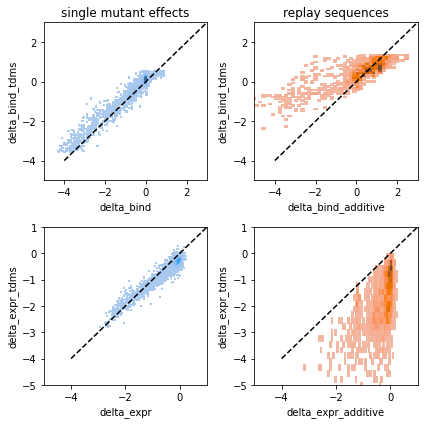

In [30]:
plt.figure(figsize=(6, 6))

plt.subplot(2, 2, 1)
g = sns.histplot(data=dms_df, x="delta_bind", y="delta_bind_tdms", color="C0")
plt.plot((-4, 4), (-4, 4), 'k--',)
g.set_xlim(-5, 3)
g.set_ylim(-5, 3)
plt.title("single mutant effects")

plt.subplot(2, 2, 2)
g = sns.histplot(data=tdmsVSadditive_df, x="delta_bind_additive", y="delta_bind_tdms", color="C1")
plt.plot((-4, 4), (-4, 4), 'k--',)
# plt.ylim(tdmsVSadditive_df.delta_bind_tdms.min(), tdmsVSadditive_df.delta_bind_tdms.max())
g.set_xlim(-5, 3)
g.set_ylim(-5, 3)
plt.title("replay sequences")

plt.subplot(2, 2, 3)
g = sns.histplot(data=dms_df, x="delta_expr", y="delta_expr_tdms", color="C0")
plt.plot((-4, 4), (-4, 4), 'k--',)
g.set_xlim(-5, 1)
g.set_ylim(-5, 1)

plt.subplot(2, 2, 4)
g = sns.histplot(data=tdmsVSadditive_df, x="delta_expr_additive", y="delta_expr_tdms", color="C1")
plt.plot((-4, 4), (-4, 4), 'k--',)
# plt.ylim(tdmsVSadditive_df.delta_bind_tdms.min(), tdmsVSadditive_df.delta_bind_tdms.max())
g.set_xlim(-5, 1)
g.set_ylim(-5, 1)

plt.tight_layout()
plt.savefig("output/plots/tdms_Vs_additive.pdf")
plt.show()


## Resample mutations, with a tolerance to recapitulate expression

In [23]:
mutability = pd.read_csv("mutability/MK_RS5NF_mutability.csv", index_col=0, squeeze=True)
substitution = pd.read_csv("mutability/MK_RS5NF_substitution.csv", index_col=0)

naive = tree.tree.sequence

def mutate(sequence):
    sequence_H = "NN" + sequence[:igk_idx] + "NN"
    sequence_K = "NN" + sequence[igk_idx:] + "NN"
    # mutabilities of each nucleotide
    contexts = [sequence_H[(i - 2) : (i + 3)]
                    for i in range(2, len(sequence_H) - 2)
                   ] + [sequence_K[(i - 2) : (i + 3)]
                        for i in range(2, len(sequence_K) - 2)
                       ]
    mutabilities = np.array([mutability[context] for context in contexts])
    i = np.random.choice(len(mutabilities), p=mutabilities / sum(mutabilities))
    sequence = sequence[:i] + np.random.choice(substitution.columns, p=substitution.loc[contexts[i]].fillna(0)) + sequence[(i + 1):]
    return sequence

In [83]:
sim_trees = defaultdict(lambda: ([], []))
expression_threshold = 0.1 #np.inf
for gc, tree in trees.items():
    print(f"GC {gc}")
    for expression_matching in (False, True):
        replicate = 1
        dead = False
        while replicate <= 10:
            print(f"  {'expression matched ' if expression_matching else ''}replicate {replicate}", end="   \r")
            new_tree = tree.tree.copy()
            for node, node_new in zip(tree.tree.traverse(strategy="preorder"), new_tree.traverse(strategy="preorder")):
                assert node.name == node_new.name
                if not node.is_root():
                    success = False
                    closest = np.inf
                    for tries in range(100):
                        node_new.sequence = node_new.up.sequence
                        for _ in range(int(node.dist)):
                            node_new.sequence = mutate(node_new.sequence)
                            igh_aa = aa(node_new.sequence[:igk_idx], igh_frame)
                            igk_aa = aa(node_new.sequence[igk_idx:], igk_frame)
                            igh_mutations = mutations(naive_igh_aa, igh_aa, igh_pos_map, "(H)")
                            igk_mutations = mutations(naive_igk_aa, igk_aa, igk_pos_map, "(L)")        
                            all_mutations = igh_mutations + igk_mutations
                            if any("*" in x for x in all_mutations):
                                node_new.delta_bind_additive = None
                                node_new.delta_expr_additive = None
                                node_new.delta_psr_additive = None
                            else:
                                node_new.delta_bind_additive = dms_df.delta_bind[all_mutations].sum()
                                node_new.delta_expr_additive = dms_df.delta_expr[all_mutations].sum()
                                node_new.delta_psr_additive = dms_df.delta_psr[all_mutations].sum()
                        # note: selecting on additive expression estimate
                        # tdms_prediction_new = tdms_model(tdms_model.seq_to_binary(tree_nt_seq_to_dms_aa_seq(node_new.sequence))).detach() - tdms_prediction_naive
                        # node_new.delta_bind_tdms = tdms_prediction_new[0].item()
                        # node_new.delta_expr_tdms = tdms_prediction_new[1].item()
                        node_new.delta_bind_tdms = None
                        node_new.delta_expr_tdms = None
                        if node_new.delta_expr_additive is None:
                            continue
                        delta = np.abs(node_new.delta_expr_additive - node.delta_expr_additive)
                        if delta < closest:
                            closest = delta
                            closest_seq = node_new.sequence
                            closest_delta_bind = node_new.delta_bind_additive
                            closest_delta_expr = node_new.delta_expr_additive
                            closest_delta_psr = node_new.delta_psr_additive
                        if not expression_matching or delta < expression_threshold:
                            success = True
                            break
                    if not success:
                        node_new.sequence = closest_seq
                        node_new.delta_bind_additive = closest_delta_bind
                        node_new.delta_expr_additive = closest_delta_expr
                        node_new.delta_psr_additive = closest_delta_psr

            sim_trees[gc][expression_matching].append(new_tree)
            replicate += 1
        print()

GC gc31HK
  replicate 10   
  expression matched replicate 10   
GC gc50HK
  replicate 10   
  expression matched replicate 10   
GC gc59HK
  replicate 10   
  expression matched replicate 10   
GC gc17HK
  replicate 10   
  expression matched replicate 10   
GC gc56HK
  replicate 10   
  expression matched replicate 10   
GC gc39HK
  replicate 10   
  expression matched replicate 10   
GC gc77HK
  replicate 10   
  expression matched replicate 10   
GC gc16HK
  replicate 10   
  expression matched replicate 10   
GC gc46HK
  replicate 10   
  expression matched replicate 10   
GC gc30HK
  replicate 10   
  expression matched replicate 10   
GC gc14HK
  replicate 10   
  expression matched replicate 10   
GC gc6HK
  replicate 10   
  expression matched replicate 10   
GC gc2HK
  replicate 10   
  expression matched replicate 10   
GC gc81HK
  replicate 10   
  expression matched replicate 10   
GC gc1HK
  replicate 10   
  expression matched replicate 10   
GC gc68HK
  replicate 10   


In [81]:
# sim_df = pd.DataFrame()
# replicate = 1
# delta_expr_threshold = -3
# fitness_transition = 10
# while replicate < 100:
#     print(f"replicate {replicate + 1}", end="   \r")
#     sequence = naive
#     n_mutations = 0
#     rep_df = pd.DataFrame()
#     dead = False
#     while n_mutations < 11:
#         if n_mutations:
#             new_sequence = mutate(sequence)
#         else:
#             new_sequence = sequence
# #         igh_aa = aa(new_sequence[:igk_idx], igh_frame)
# #         igk_aa = aa(new_sequence[igk_idx:], igk_frame)
# #         igh_mutations = mutations(naive_igh_aa, igh_aa, igh_pos_map, "(H)")
# #         igk_mutations = mutations(naive_igk_aa, igk_aa, igk_pos_map, "(L)")
# #         all_mutations = igh_mutations + igk_mutations
#         all_mutations = igh_mutations + igk_mutations
#         if any("*" in x for x in all_mutations):
#             delta_bind = None
#             delta_expr = None
#             delta_psr = None
#         else:
#             delta_bind = dms_df.delta_bind[all_mutations].sum()
#             delta_expr = dms_df.delta_expr[all_mutations].sum()
#             delta_psr = dms_df.delta_psr[all_mutations].sum()
#         tdms_prediction = tdms_model(tdms_model.seq_to_binary(tree_nt_seq_to_dms_aa_seq(new_sequence))).detach() - tdms_prediction_naive
#         if np.random.rand() < expit(-fitness_transition * (tdms_prediction[1] - delta_expr_threshold)):
#             dead=True
#             break
#         sequence = new_sequence
#         new_row = pd.Series({"delta_bind": tdms_prediction[0].item(),
#                              "delta_expr": tdms_prediction[1].item(),
#                              "n_mutations": n_mutations,
#                              "replicate": replicate})
#         rep_df = rep_df.append(new_row, ignore_index=True, verify_integrity=True)
#         n_mutations += 1
#     if not dead:
#         sim_df = sim_df.append(rep_df, ignore_index=True, verify_integrity=True)
#         replicate += 1
# sim_df

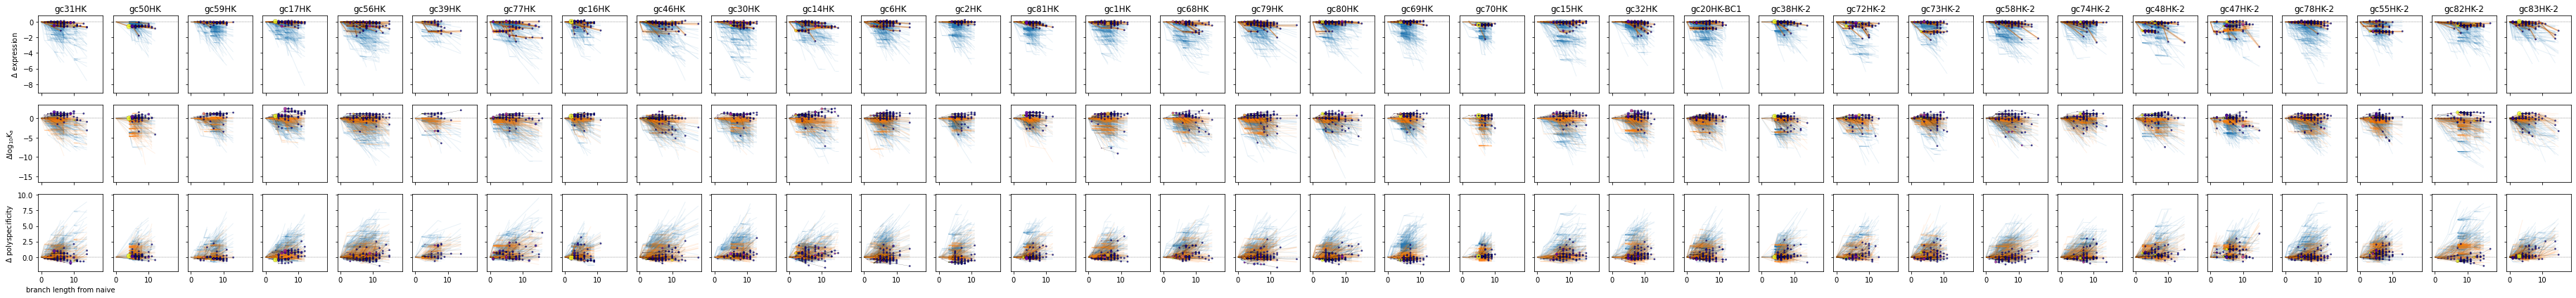

In [87]:
fig, axes = plt.subplots(3, len(trees), figsize=(1.5 * len(trees), 6), sharex=True, sharey="row")

color_by = "LBR" #LBI

for i, (phenotype, phenotype_label) in enumerate(zip(("delta_expr_additive", "delta_bind_additive", "delta_psr_additive"
                                                      ),
                                                     (r"$\Delta$ expression", r"$\Delta \log_{10} K_a$", r"$\Delta$ polyspecificity"
                                                      )
                                                     )):
    for j, (gc, tree) in enumerate(trees.items()):
        points = []
        lines = []
        colors = []
        
        for node in tree.tree.traverse():
            points.append((tree.tree.get_distance(node),
                           getattr(node, phenotype),
                           1 + 5 * node.abundance,
                           getattr(node, color_by)))
            if node.up is not None:
                lines.append([(tree.tree.get_distance(node.up), getattr(node.up, phenotype)),
                              (tree.tree.get_distance(node), getattr(node, phenotype))])
            colors.append(getattr(node, color_by))

        sim_lines = []
        for sim_idx, sim_tree in enumerate(sim_trees[gc][0]):
            for node in sim_tree.traverse():
                if node.up is not None:
                    sim_lines.append([(sim_tree.get_distance(node.up), getattr(node.up, phenotype)),
                                      (sim_tree.get_distance(node), getattr(node, phenotype))])
        sim_lines_matched = []
        for sim_idx, sim_tree in enumerate(sim_trees[gc][1]):
            for node in sim_tree.traverse():
                if node.up is not None:
                    sim_lines_matched.append([(sim_tree.get_distance(node.up), getattr(node.up, phenotype)),
                                              (sim_tree.get_distance(node), getattr(node, phenotype))])
        lc = mc.LineCollection(lines, colors="k", linewidths=0.3, alpha=0.5, zorder=3)
        sim_lc = mc.LineCollection(sim_lines, colors="C0", linewidths=1, alpha=0.1, zorder=2)
        sim_matched_lc = mc.LineCollection(sim_lines_matched, colors="C1", linewidths=1, alpha=0.1, zorder=2)

        ax = axes[i, j]
        ax.axhline(0, c="k", ls="--", lw=0.25, zorder=1)
#         if phenotype == "delta_expr":
#             ax.axhline(delta_expr_threshold, c="r", ls="--", lw=0.25, zorder=1)
        ax.add_collection(lc)
        ax.add_collection(sim_lc)
        ax.add_collection(sim_matched_lc)
        ax.scatter(*zip(*points), cmap=cmap, norm=norm, alpha=0.8, edgecolors="k", linewidths=0.2, zorder=4)
        if i == 0:
            ax.set_title(gc)
        ax.set_xlabel(None)
#         break
    axes[i, 0].set_ylabel(phenotype_label)
axes[-1, 0].set_xlabel("branch length from naive")
plt.tight_layout()
plt.savefig("output/plots/phenotype_trajectories.pdf")
plt.show()

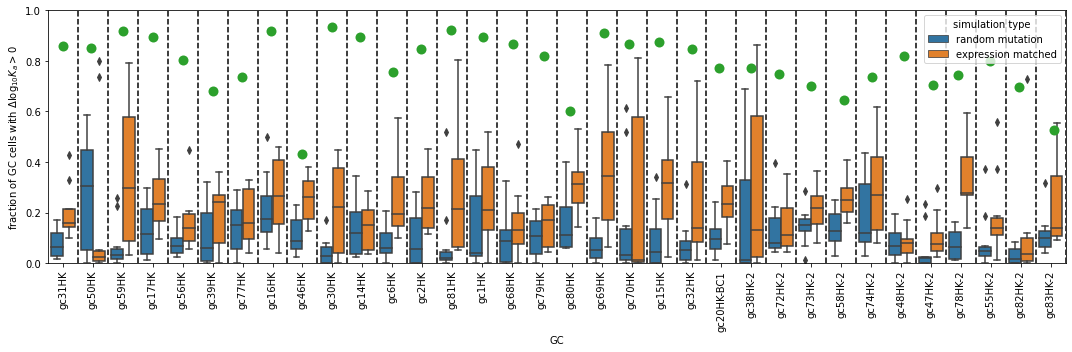

In [103]:
def tree_stat(tree, threshold=0):
    total = 0
    tail_count = 0
    for node in tree.traverse():
        total += node.abundance
        if node.delta_bind_additive > threshold:
            tail_count += node.abundance
    return tail_count / total

dat = []
threshold = 0 #np.log10(2)
for gc, tree in trees.items():
    dat.append([gc, False, None, tree_stat(tree.tree, threshold)])
    for rep_tree in sim_trees[gc][0]:
        dat.append([gc, True, "random mutation", tree_stat(rep_tree, threshold)])
    for rep_tree in sim_trees[gc][1]:
        dat.append([gc, True, "expression matched", tree_stat(rep_tree, threshold)])

stat_df = pd.DataFrame(dat, columns=["GC", "simulation", "simulation type", fr"fraction of GC cells with $\Delta\log_{{10}}K_a>{threshold}$"])    

plt.figure(figsize=(15, 5))
g = sns.boxplot(data=stat_df.loc[stat_df.simulation == True],
                x="GC", y=fr"fraction of GC cells with $\Delta\log_{{10}}K_a>{threshold}$", hue="simulation type",
                dodge=True
#                    split=True, inner="stick"
               )
sns.stripplot(data=stat_df.loc[stat_df.simulation == False],
              x="GC", y=fr"fraction of GC cells with $\Delta\log_{{10}}K_a>{threshold}$",
              color="C2", size=10)
plt.ylim(0, 1)
for item in g.get_xticklabels():
    item.set_rotation(90)
for tick_pos in g.get_xticks():
    plt.axvline(tick_pos + 0.5, c="k", ls="--")
plt.tight_layout()
plt.savefig("output/plots/selection_stat.pdf")
plt.show()

# sns.displot(data=stat_df, col="GC", x=fr"GC fraction with $\Delta\log_{{10}}K_a>{threshold}$", hue="simulation type", col_wrap=4)
# sns.displot(data=stat_df.loc[stat_df.simulation == False], col="GC", x=fr"GC fraction with $\Delta\log_{{10}}K_a>{threshold}$", hue="simulation type", col_wrap=4, rug=True)
# # plt.savefig("output/plots/selection_stat.pdf")
# plt.show()

## Convergent mutations

In [119]:
naive_H = "NN" + naive[:igk_idx] + "NN"
naive_K = "NN" + naive[igk_idx:] + "NN"
# mutabilities of each nucleotide
contexts = [naive_H[(i - 2) : (i + 3)]
                for i in range(2, len(naive_H) - 2)
               ] + [naive_K[(i - 2) : (i + 3)]
                    for i in range(2, len(naive_K) - 2)
                   ]

# note: should change this to get only codon-wise first hits, maybe using leaf function and pre-order traversal
dat = []
for gc, tree in trees.items():
    for node in tree.tree.traverse():
        if node.abundance > 0:
            for i, (nt_naive, nt_mut) in enumerate(zip(naive, node.sequence)):
                if nt_mut != nt_naive:
                    codon_start_idx = 3 * (i // 3)
                    codon_naive = naive[codon_start_idx:(codon_start_idx + 3)]
                    codon_pos = i % 3
                    assert codon_naive[codon_pos] == nt_naive
                    codon_mut = list(codon_naive)
                    codon_mut[codon_pos] = nt_mut
                    codon_mut = "".join(codon_mut)
                    aa_naive = Seq(codon_naive).translate()
                    aa_mut = Seq(codon_mut).translate()
                    if i < igk_idx:
                        chain = "H"
                        pos = igh_pos_map[i // 3]
                    else:
                        chain = "L"
                        pos = igk_pos_map[(i - igk_idx) // 3]
                    dat.append([f"{nt_naive}{i}{nt_mut}",
                                f"{chain}-{str(pos).zfill(3)}",
                                chain,
                                None if aa_mut == aa_naive else f"{aa_naive}{pos}({chain}){aa_mut}",
                                None if f"{aa_naive}{pos}({chain}){aa_mut}" not in dms_df.index else dms_df.loc[f"{aa_naive}{pos}({chain}){aa_mut}", "delta_bind"],
                                mutability[contexts[i]] * substitution.loc[contexts[i], nt_mut],
                                gc,
                                node.LBI,
                                node.LBR])

mut_df = pd.DataFrame(dat, columns=("nt_mutation", "site", "chain", "aa_mutation", "delta_bind", "mutation rate", "GCs", "LBI", "LBR"))
mut_df = mut_df.groupby("nt_mutation").agg({"aa_mutation": "first",
                                            "site": "first",
                                            "chain": "first",
                                            "mutation rate": "first",
                                            "delta_bind": "first",
                                            "GCs": "nunique",
                                            "LBI": "max",
                                            "LBR": "max"})
mut_df.sort_values("GCs", ascending=False)

aa_mutation   site chain  mutation rate  delta_bind  GCs  \
nt_mutation                                                            
G137A              None  H-051     H       0.007471     0.00000   34   
G154A           S57(H)N  H-057     H       0.006154    -0.01297   33   
G166A           S64(H)N  H-064     H       0.004307     0.02258   32   
G644A              None  L-119     L       0.006154     0.00000   32   
C286G          A105(H)G  H-105     H       0.000357     0.33100   32   
...                 ...    ...   ...            ...         ...  ...   
C632G              None  L-115     L       0.000281     0.00000    1   
C62G               None  H-022     H       0.000075     0.00000    1   
C61G            T22(H)S  H-022     H       0.000071    -0.02213    1   
C618A          P111(L)T  L-111     L       0.000051    -0.70825    1   
T99C            W39(H)R  H-039     H       0.000078    -0.76148    1   

                   LBI        LBR  
nt_mutation                        
G137A        15.364017   4.483387  
G154A        22.453079  11.914122  
G166A        22.780201   6.325562  
G644A        10.424919   5.808539  
C286G        24.882726   9.302345  
...                ...        ...  
C632G         1.249037   0.000000  
C62G          1.251589   0.000000  
C61G          1.004830   0.000000  
C618A         1.518034   0.000000  
T99C          1.079338   0.000000  

[1141 rows x 8 columns]

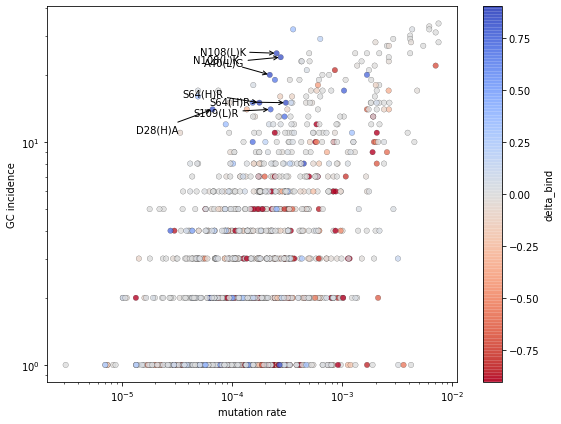

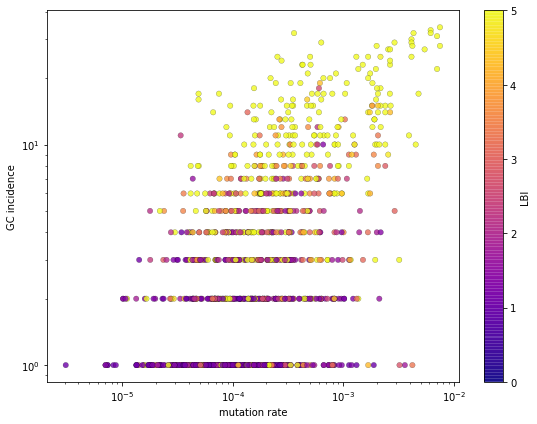

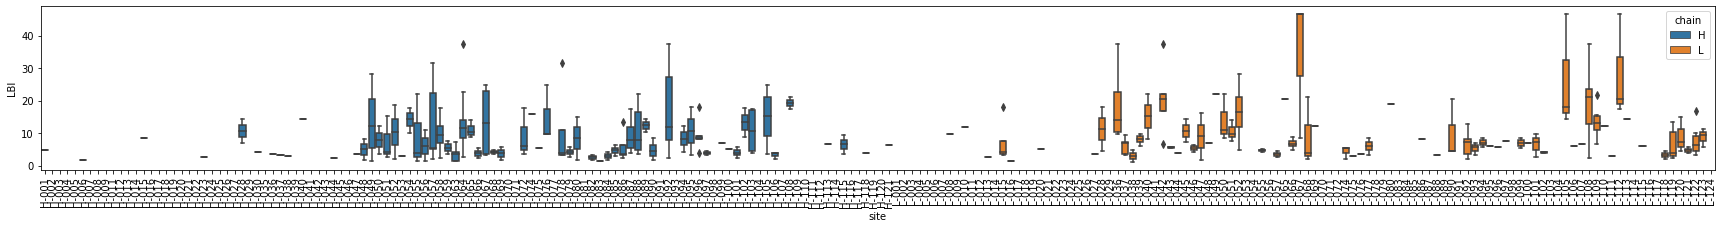

In [121]:
for prop in ("delta_bind", "LBI"):
    if prop == "delta_bind":
        this_cmap = "coolwarm_r"
        this_vmin = vmin
        this_vmax = vmax
    elif prop == "LBI":
        this_cmap = "plasma"
        this_vmin = vmin_LB
        this_vmax = vmax_LB
    plt.figure(figsize=(8, 6))
    plt.scatter(mut_df.loc[mut_df.delta_bind <= 0, "mutation rate"], mut_df.loc[mut_df.delta_bind <= 0, "GCs"], c=mut_df.loc[mut_df.delta_bind <= 0, prop], s=30,
                cmap=this_cmap, vmin=this_vmin, vmax=this_vmax, alpha=0.8, edgecolors="k", linewidths=0.2, zorder=0)
    plt.scatter(mut_df.loc[mut_df.delta_bind > 0, "mutation rate"], mut_df.loc[mut_df.delta_bind > 0, "GCs"], c=mut_df.loc[mut_df.delta_bind > 0, prop], s=30,
                cmap=this_cmap, vmin=this_vmin, vmax=this_vmax, alpha=0.8, edgecolors="k", linewidths=0.2 , zorder=1)
    if prop == "delta_bind":
        for _, row in mut_df.iterrows():
            if row.delta_bind > 0.7 and row.GCs > 13 and row["mutation rate"] < 1e-3:
                xy = np.array([row["mutation rate"], row.GCs])
                xytext = xy * np.array([0.2, 1 - 0.1 * np.random.randn()])
                plt.annotate(row["aa_mutation"], xy, xytext=xytext,
                             arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("mutation rate")
    plt.ylabel("GC incidence")
    plt.colorbar(label=prop)
    plt.tight_layout()
    plt.savefig(f"output/plots/mutation_incidence.{prop}.pdf")
    plt.show()


order = [f"{row.chain}-{str(row.site).zfill(3)}" for _, row in pos_df.iterrows() if row.chain != "link"]

plt.figure(figsize=(30, 3))
g = sns.boxplot(data=mut_df[mut_df.GCs > 5], x="site", y="LBI", hue="chain", dodge=False,
                order=order)
for item in g.get_xticklabels():
    item.set_rotation(90)
plt.show()

# Distributions of affinity effects of mutations on trees

Let's look at phenotypic effects of *sitewise* first-step mutations. We can do this sitewise because we are using an additive model. This would also work with a global epistasis model, with an additive latent space.

In [66]:
# def hit_counts(tree):
#     node_generator = tree.tree.traverse()
#     root = next(node)
#     root.add_feature("hit counts", [0] * len(naive_igh_aa))
#     naive_igh_aa = aa(tree.tree.sequence[:igk_idx], igh_frame)
#     naive_igk_aa = aa(tree.tree.sequence[igk_idx:], igk_frame)
#     for node in node_generator:
#         igh_aa = aa(node.sequence[:igk_idx], igh_frame)
#         igk_aa = aa(node.sequence[igk_idx:], igk_frame)

In [101]:
# def mutation_effects(node):
#     if node.up is None:
#         return []
#     naive_igh_aa = aa(tree.tree.sequence[:igk_idx], igh_frame)
#     naive_igk_aa = aa(tree.tree.sequence[igk_idx:], igk_frame)
#     parent_igh_aa = aa(node.up.sequence[:igk_idx], igh_frame)
#     parent_igk_aa = aa(node.up.sequence[igk_idx:], igk_frame)
#     parent_igh_mutations = mutations(naive_igh_aa, parent_igh_aa, igh_pos_map, "(H)")
#     parent_igk_mutations = mutations(naive_igk_aa, parent_igk_aa, igk_pos_map, "(L)")
#     parent_mutations = parent_igh_mutations + parent_igk_mutations
    
#     igh_aa = aa(node.sequence[:igk_idx], igh_frame)
#     igk_aa = aa(node.sequence[igk_idx:], igk_frame)
#     igh_mutations = mutations(parent_igh_aa, igh_aa, igh_pos_map, "(H)")
#     igk_mutations = mutations(parent_igk_aa, igk_aa, igk_pos_map, "(L)")
#     node_mutations = igh_mutations + igk_mutations

#     for mutation in node_mutations:
#         match = [parent_mutation for parent_mutation in parent_mutations if parent_mutation[1:] == mutation[1:]]
# #         dms_df.mutation[dms_df.mutation.str[1:] == mutation[1:]]
#         assert len(match) < 2
#         print(match)
#         if len(match) = 0:
#             effect = dms_df.delta_bind[dms_df.mutation == mutation].iloc[0]
#             print(effect)
#         else:
#             print
# #         print(mutation)
# #         print(match)
    
# #     print(parent_igh_mutations + parent_igk_mutations)
# #     print(igh_mutations + igk_mutations)
    
# #     sum_delta_bind = dms_df.delta_bind[dms_df.mutation.isin(igh_mutations + igk_mutations)].sum()
    
#     return 

In [623]:
LBI_df = pd.DataFrame()
for gc, tree in trees.items():
    for node in tree.tree:
        new_row = pd.Series({"GC": gc,
                             "LBI": node.LBI,
                             "delta_bind_tdms": node.delta_bind,
                             "delta_bind_additive": node.delta_bind_additive,
                             "delta_expr_tdms": node.delta_expr,
                             "delta_expr_additive": node.delta_expr_additive})
        LBI_df = LBI_df.append(new_row, ignore_index=True)
LBI_df

GC       LBI  delta_bind_tdms  delta_bind_additive  \
0       gc31HK  1.198923         0.631612              0.02777   
1       gc31HK  1.198923        -0.601261             -1.51624   
2       gc31HK  1.073180         0.191244             -0.26601   
3       gc31HK  1.013371         1.007847              0.72164   
4       gc31HK  1.491976        -0.624988             -1.47009   
...        ...       ...              ...                  ...   
1959  gc83HK-2  1.316264        -0.450487             -1.30007   
1960  gc83HK-2  1.002497        -0.346078             -1.74805   
1961  gc83HK-2  1.429431         0.874365              0.57016   
1962  gc83HK-2  1.021380         0.284425             -0.60392   
1963  gc83HK-2  1.007865        -0.420179             -3.30400   

      delta_expr_tdms  delta_expr_additive  
0           -1.021183             -0.00359  
1           -2.353238             -0.40323  
2           -1.389293             -0.25516  
3           -1.581321             -0.34072  
4           -2.205372             -0.57942  
...               ...                  ...  
1959        -1.780970             -0.31524  
1960        -4.018593             -1.65148  
1961        -1.563043             -0.26490  
1962        -2.583671             -2.14966  
1963        -4.134657             -1.13774  

[1964 rows x 6 columns]

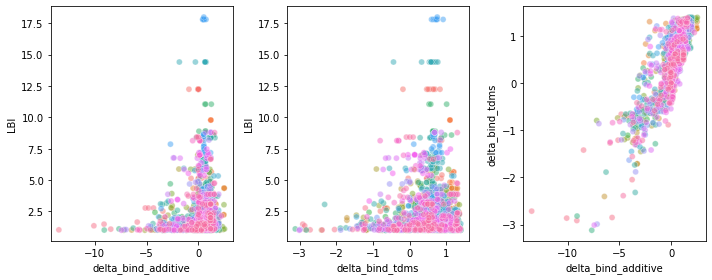

In [645]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
sns.scatterplot(data=LBI_df, x="delta_bind_additive", y="LBI", hue="GC", legend=False, alpha=0.5)
plt.subplot(1, 3, 2)
sns.scatterplot(data=LBI_df, x="delta_bind_tdms", y="LBI", hue="GC", legend=False, alpha=0.5)
plt.subplot(1, 3, 3)
sns.scatterplot(data=LBI_df, x="delta_bind_additive", y="delta_bind_tdms", hue="GC", legend=False, alpha=0.5)
plt.tight_layout()
plt.savefig("output/plots/LBI_scatter.pdf")
plt.show()

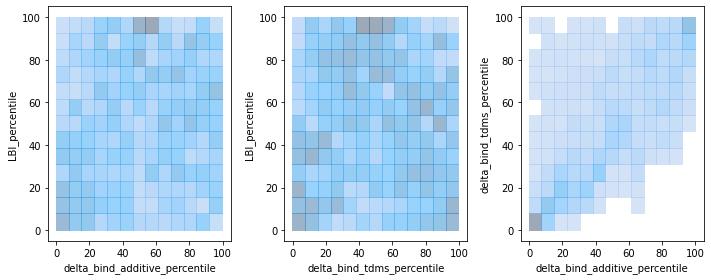

In [649]:
LBI_df["delta_bind_additive_percentile"] = [percentileofscore(LBI_df["delta_bind_additive"], x) for x in LBI_df["delta_bind_additive"]]
LBI_df["delta_bind_tdms_percentile"] = [percentileofscore(LBI_df["delta_bind_tdms"], x) for x in LBI_df["delta_bind_tdms"]]
LBI_df["LBI_percentile"] = [percentileofscore(LBI_df["LBI"], x) for x in LBI_df["LBI"]]

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
sns.histplot(data=LBI_df, x="delta_bind_additive_percentile", y="LBI_percentile", legend=False, alpha=0.5)
plt.subplot(1, 3, 2)
sns.histplot(data=LBI_df, x="delta_bind_tdms_percentile", y="LBI_percentile", legend=False, alpha=0.5)
plt.subplot(1, 3, 3)
sns.histplot(data=LBI_df, x="delta_bind_additive_percentile", y="delta_bind_tdms_percentile", legend=False, alpha=0.5)
plt.tight_layout()
# plt.savefig("output/plots/LBI_scatter.pdf")
plt.show()

## Octet data

In [759]:
octet_df = pd.read_csv("data/211118 DMS vs. octet minimal.csv")

for row_idx, row in octet_df.iterrows():
    igh_mutations = [f"{(y := x.rstrip(','))[:-1]}(H){y[-1]}".rstrip(",") for x in row.HCmut.split() if "GL" not in x]
    igk_mutations = [f"{(y := x.rstrip(','))[:-1]}(L){y[-1]}".rstrip(",") for x in row.LCmut.split() if "GL" not in x]
    all_mutations = igh_mutations + igk_mutations
    if any("*" in x for x in all_mutations):
        delta_bind = None
    else:
        delta_bind = dms_df.delta_bind[all_mutations].sum()
    octet_df.loc[row_idx, "delta_bind_additive"] = delta_bind
    
    aa_seq = pos_df.amino_acid.copy()
    for mutation in all_mutations:
        chain = mutation[-3]
        pos = int(mutation[1:-4])
        wildtype = mutation[0]
        mutant = mutation[-1]
        idx = pos_df.index[(pos_df.site == pos) & (pos_df.chain == chain)]
        assert len(idx) == 1
        idx = idx[0]
        assert aa_seq[idx] == wildtype
        aa_seq[idx] = mutant
    tdms_prediction = tdms_model(tdms_model.seq_to_binary("".join(aa_seq))).detach()# - tdms_prediction_naive
    octet_df.loc[row_idx, "delta_bind_tdms"] = tdms_prediction[0].item()

octet_df["delta_bind_octet"] = np.log10(octet_df.octet_Kd_foldchange_avg)
    
octet_df

ID                   HCmut  \
0      #26 Fab4              K49R, Y58F   
1          A40G                      GL   
2          A40V                      GL   
3   A40V, N108D                      GL   
4          D28A                    D28A   
5           EH1        D28A, K44R, S64G   
6           EH2        D28A, K49R, S64G   
7           EH3  D28A, K44R, K49R, S64G   
8            GL                      GL   
9          K44R                    K44R   
10         K49R                    K49R   
11         m1-1                      GL   
12          m14                      GL   
13        m15-6                      GL   
14          m17                      GL   
15          m20                      GL   
16          m21                      GL   
17        m22-5                      GL   
18        m23-5                      GL   
19        m24-3                      GL   
20        m25-1                      GL   
21        m26-1                      GL   
22         m3-1                      GL   
23           m5                      GL   
24           m7                      GL   
25        N108D                      GL   
26           RH                    K49R   
27         S64G                    S64G   

                                         LCmut  aa_mut_total  \
0                                         A40G             3   
1                                         A40G             1   
2                                         A40V             1   
3                                  A40V, N108D             2   
4                                           GL             1   
5               A40G, Y42F, A52S, Q105H, N108Y             8   
6               A40G, Y42F, A52S, Q105H, N108Y             8   
7               A40G, Y42F, A52S, Q105H, N108Y             9   
8                                           GL             0   
9                                           GL             1   
10                                          GL             1   
11                                        Y42F             1   
12                    A40G, Y42F, Q105H, N108Y             4   
13                                        A52S             1   
14                                        Y55F             1   
15                            A40G, A52S, Y55F             3   
16  A40G Y42F A52S Y55H S69N Q105H N108Y L112I             8   
17                     A40G, Y42F, A52S, N108Y             4   
18              A40G, Y42F, A52S, Q105H, N108Y             5   
19                     A40G, Y42F, A52S, N108S             4   
20              A40G, Y42F, A52S, Q105H, N108S             5   
21                                       N108S             1   
22                                       Q105H             1   
23                                       N108Y             1   
24                                 Q105H N108Y             2   
25                                       N108D             1   
26                     A40G, Y42F, A52S, N108S             5   
27                                          GL             1   

    deltaKd_additive_foldchange  deltaKd_additive  octet_Kd_foldchange_avg  \
0                      7.462082           0.87286                 6.364276   
1                      7.172326           0.85566                 6.952912   
2                      0.193201          -0.71399                 0.642593   
3                      0.031422          -1.50277                 0.376934   
4                      6.835810           0.83479                 5.774278   
5                   2558.998315           3.40807               308.192458   
6                   2154.269337           3.33330               383.495146   
7                   2499.769702           3.39790               361.280488   
8                      1.000000           0.00000                 1.000000   
9                      1.160379           0.06460                 0.986547   
10                     0.976855          -0.01017 

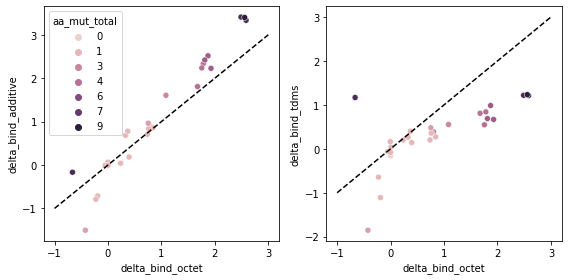

In [782]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
sns.scatterplot(data=octet_df, x="delta_bind_octet", y="delta_bind_additive", hue="aa_mut_total", ax=axes[0])
axes[0].plot((-1, 3), (-1, 3), 'k--')
sns.scatterplot(data=octet_df, x="delta_bind_octet", y="delta_bind_tdms", hue="aa_mut_total", legend=False, ax=axes[1])
axes[1].plot((-1, 3), (-1, 3), 'k--')
plt.tight_layout()
plt.savefig("output/plots/octet.pdf")
plt.show()

## Clonal bursts / inertial proliferation

Find the elbows

In [159]:
dat = []
burst_thresh = 10
for gc, tree in trees.items():
    for node in tree.tree.traverse():
        if node.up is not None and len(node.children):
            delta_delta_bind_children = np.array([child.delta_bind_additive - node.delta_bind_additive for child in node.children])
            delta_delta_bind_parent = node.delta_bind_additive - node.up.delta_bind_additive
            dat.append([node.LBR, node.LBR >= burst_thresh, delta_delta_bind_parent, delta_delta_bind_children.mean()])
burst_df = pd.DataFrame(dat, columns=("LBR", "burst", r"$\Delta\Delta\log_{10}K_a$ parent", r"$\Delta\Delta\log_{10}K_a$ children"))
burst_df

LBR  burst  $\Delta\Delta\log_{10}K_a$ parent  \
0    1.363759  False                           -0.07276   
1    0.588029  False                           -0.01297   
2    1.811684  False                            0.33100   
3    5.381685  False                            0.75701   
4    0.805505  False                            0.85566   
..        ...    ...                                ...   
837  0.161482  False                            0.00000   
838  1.382993  False                            0.37694   
839  0.638854  False                           -0.01932   
840  0.413872  False                           -0.09461   
841  2.413622  False                           -0.52482   

     $\Delta\Delta\log_{10}K_a$ children  
0                              -0.512067  
1                               0.541735  
2                               0.642993  
3                               0.215624  
4                               0.018810  
..                                   ...  
837                            -0.002730  
838                            -1.388418  
839                            -0.309715  
840                            -3.207880  
841                            -2.142207  

[842 rows x 4 columns]

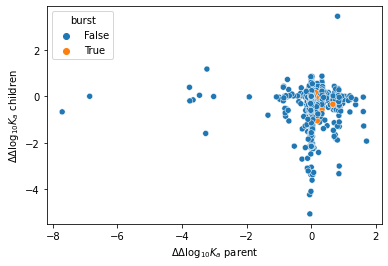

ValueError: Could not interpret input '$\Delta\Delta\log_{10}K_a$'

In [163]:
sns.scatterplot(data=burst_df, x=r"$\Delta\Delta\log_{10}K_a$ parent", y=r"$\Delta\Delta\log_{10}K_a$ children", hue="burst")
plt.show()

sns.violinplot(data=burst_df, y=r"$\Delta\Delta\log_{10}K_a$", x="burst")
plt.show()

### DMS-view

In [211]:
site_df = dms_df.groupby('position')[['delta_bind', 'delta_expr', 'delta_psr']].mean().reset_index()
site_df = (site_df.melt(id_vars=['position'], var_name='condition', value_name='site_mean')
           .rename(columns={'position': 'site'}))
site_df['condition'] = site_df['condition'].map({'delta_bind': 'binding',
                                                'delta_expr': 'expression',
                                                'delta_psr': 'polyspecificity'})
site_df

site        condition  site_mean
0       1          binding   0.081294
1       2          binding  -0.059908
2       3          binding  -0.011900
3       4          binding   0.037558
4       5          binding  -0.002107
..    ...              ...        ...
655   231  polyspecificity   0.710525
656   232  polyspecificity   0.101387
657   233  polyspecificity   0.068829
658   234  polyspecificity  -0.006957
659   235  polyspecificity   0.008772

[660 rows x 3 columns]

In [212]:
mut_df = (dms_df[['position', 'delta_bind', 'delta_expr', 'delta_psr', 'mutant']]
          .rename(columns={'position': 'site', 'mutant': 'mutation'}))
mut_df = mut_df.melt(id_vars=['site', 'mutation'],
                     var_name='condition',
                     value_name='mut_delta')
mut_df['condition'] = mut_df['condition'].map({'delta_bind': 'binding',
                                              'delta_expr': 'expression',
                                              'delta_psr': 'polyspecificity'})
mut_df

site mutation        condition  mut_delta
0         1        A          binding    0.03110
1         1        C          binding   -0.01243
2         1        D          binding   -0.02948
3         1        E          binding    0.00000
4         1        F          binding    0.06180
...     ...      ...              ...        ...
13195   235        S  polyspecificity    0.07866
13196   235        T  polyspecificity    0.02896
13197   235        V  polyspecificity   -0.07899
13198   235        W  polyspecificity    0.05415
13199   235        Y  polyspecificity    0.10318

[13200 rows x 4 columns]

In [213]:
meta_df = dms_df[['position', 'wildtype', 'chain', 'position_IMTG']].copy()
meta_df['label_site'] = meta_df[['chain', 'position_IMTG', 'wildtype']].apply(lambda x: f'{x[2]}{x[1]}({x[0]})', axis=1)
meta_df = (meta_df[['position', 'wildtype', 'label_site']]
           .rename(columns={'position': 'site', 'chain': 'protein_chain', 'position_IMTG': 'protein_site'})
          )
meta_df['protein_chain'] = 'A'
meta_df['protein_site'] = meta_df['site']
meta_df

site wildtype label_site protein_chain  protein_site
mutation                                                      
E1(H)A       1        E      E1(H)             A             1
E1(H)C       1        E      E1(H)             A             1
E1(H)D       1        E      E1(H)             A             1
E1(H)E       1        E      E1(H)             A             1
E1(H)F       1        E      E1(H)             A             1
...        ...      ...        ...           ...           ...
R124(L)S   235        R    R124(L)             A           235
R124(L)T   235        R    R124(L)             A           235
R124(L)V   235        R    R124(L)             A           235
R124(L)W   235        R    R124(L)             A           235
R124(L)Y   235        R    R124(L)             A           235

[4400 rows x 5 columns]

In [217]:
dmsview_df = pd.merge(site_df, mut_df, how='outer').merge(meta_df, how='outer').drop_duplicates()
dmsview_df

site        condition  site_mean mutation  mut_delta wildtype  \
0          1          binding   0.081294        A    0.03110        E   
20         1          binding   0.081294        C   -0.01243        E   
40         1          binding   0.081294        D   -0.02948        E   
60         1          binding   0.081294        E    0.00000        E   
80         1          binding   0.081294        F    0.06180        E   
...      ...              ...        ...      ...        ...      ...   
263900   235  polyspecificity   0.008772        S    0.07866        R   
263920   235  polyspecificity   0.008772        T    0.02896        R   
263940   235  polyspecificity   0.008772        V   -0.07899        R   
263960   235  polyspecificity   0.008772        W    0.05415        R   
263980   235  polyspecificity   0.008772        Y    0.10318        R   

       label_site protein_chain  protein_site  
0           E1(H)             A             1  
20          E1(H)             A             1  
40          E1(H)             A             1  
60          E1(H)             A             1  
80          E1(H)             A             1  
...           ...           ...           ...  
263900    R124(L)             A           235  
263920    R124(L)             A           235  
263940    R124(L)             A           235  
263960    R124(L)             A           235  
263980    R124(L)             A           235  

[13200 rows x 9 columns]

In [216]:
dmsview_df.to_csv("output/dms-view.csv")